In [1]:
import matplotlib.pyplot as plt
import gym
from gym import spaces
from tqdm import tqdm
import random
import copy

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

['Lausanne', 'Geneva', 'Sion', 'NeuchÃ¢tel', 'Basel', 'Bern', 'LÃ¼cern', 'St-Gallen', 'ZÃ¼rich']


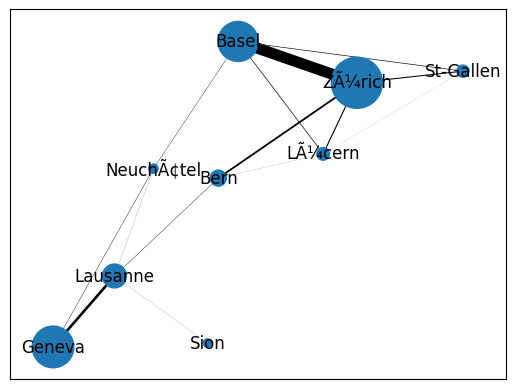

In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities)
dyn.draw_map()

In [3]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

In [4]:
SCALE = 100 # %
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

In [5]:
"""Loading the environment"""
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

## Q1.a No-action-agent "Frozen agent"

In [6]:
class FrozenAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        # here we simply return the action 0 so "ACTION_NULL", which means no action
        return 0

In [7]:
agent = FrozenAgent(env)

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed=1)
agent.reset()
agent.epsilon = 0
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

In [8]:
""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

### Q1.a.1

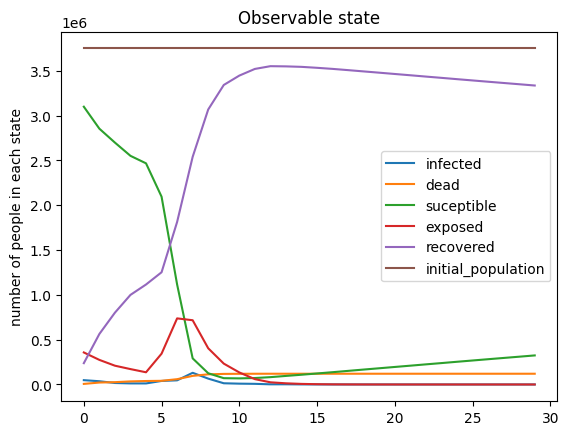

In [9]:
fig, ax = plt.subplots()
#states = total.keys()
states = ['infected', 'dead', 'suceptible', 'exposed', 'recovered', 'initial_population']
#states = ['infected', 'dead', 'exposed', 'recovered']

[ax.plot(total[y]) for y in states]
ax.legend(states)
ax.set_title('Observable state')
ax.set_ylabel('number of people in each state');

### Q1.a.2

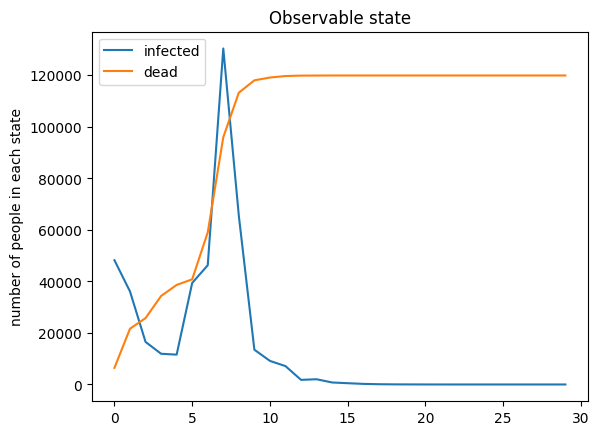

In [10]:
fig, ax = plt.subplots()
#states = total.keys()
#states = ['infected', 'dead', 'suceptible', 'exposed', 'recovered', 'initial_population']
states = ['infected', 'dead']

[ax.plot(total[y]) for y in states]
ax.legend(states)
ax.set_title('Observable state')
ax.set_ylabel('number of people in each state');

### Q1.a.3

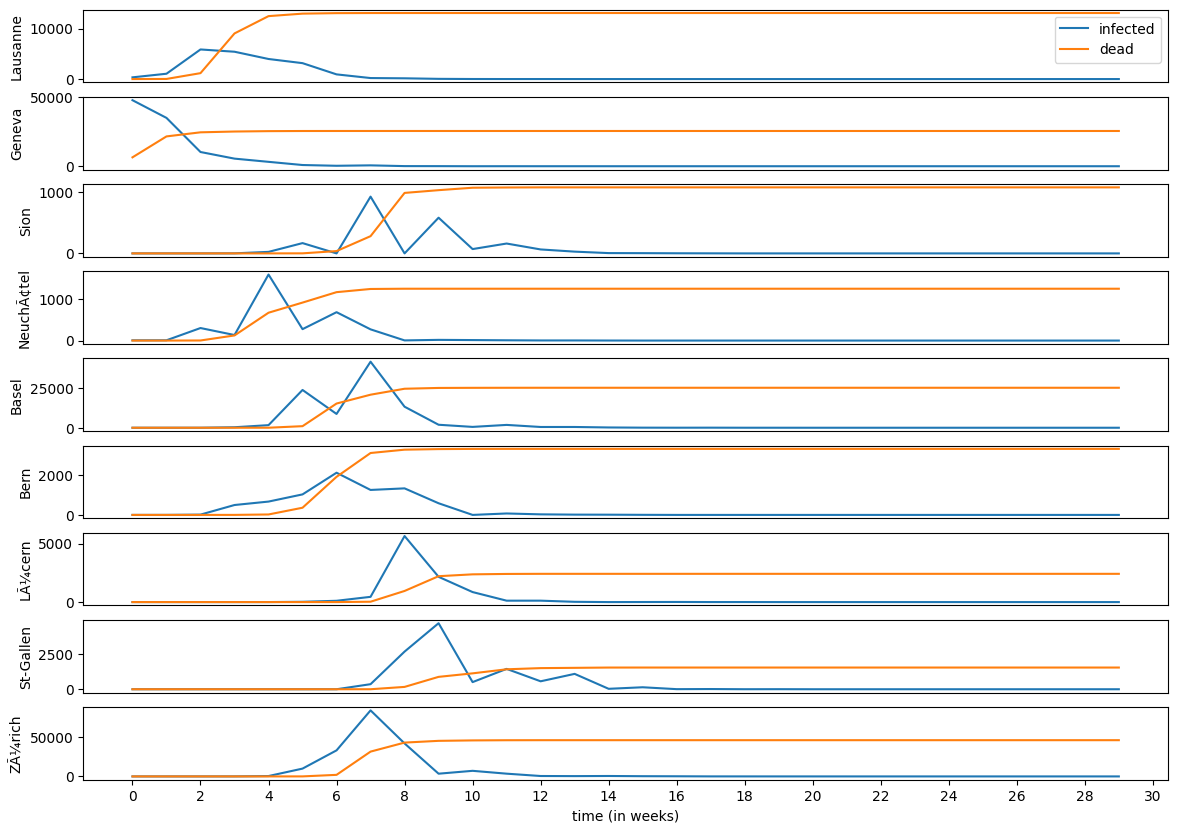

In [11]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_right = [plt.subplot2grid(shape=(9, 1), loc=(0, 0), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 1), loc=(i, 0), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Lausanne'].legend(['infected','dead'])
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

### Discuss the evolution of variables over time:
It seems that the disease is stuck in St-Gallen and that the propagation is mitigated alone

## Q2.a Implement Pr. Russo's Policy

In [12]:
"""Loading the environment"""
# we remove the observation preprocessor because it is easier in this task to deal with the initial data format
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            #observation_preprocessor=observation_preprocessor,
            )

In [13]:
class RussoAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        self.env = env
        self.confined_weeks = 0 # since how many weeks is the country confined
        self.confined = False
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        self.confined_weeks = 0
        self.confined = False
    
    def act(self, obs):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        # here we take the nr of infected people at the end of the week
        i_total = obs.total.infected[-1]
        threshold = 20000
        
        action = 0 
        if self.confined:
            if self.confined_weeks < 4: # confinement is not finished
                self.confined_weeks += 1
                action = 1 # keep confined
            elif i_total > threshold: # confinement is finished but starts again
                self.confined_weeks = 1
                action = 1 # re-confine
            else: # confinement is finished
                self.confined_weeks = 0
                self.confined = False
                action = 0 # release population
        
        elif i_total > threshold: # not confined yet, but threshold is reached
            self.confined = True
            self.confined_weeks +=1
            action = 1 # confine
            
        return action

In [14]:
agent = RussoAgent(env)

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed=1)
agent.reset()
agent.epsilon = 0
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

In [15]:
""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

### Q1.a.1

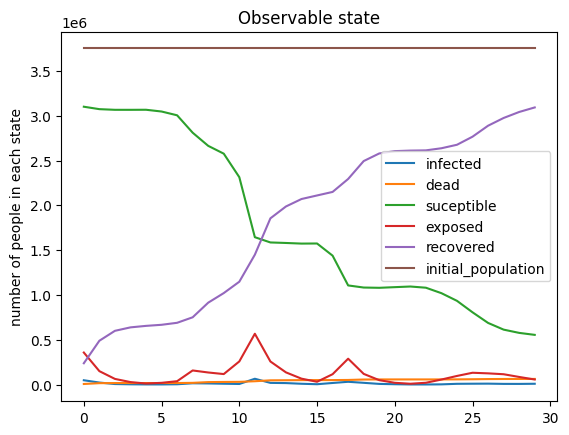

In [16]:
fig, ax = plt.subplots()
#states = total.keys()
states = ['infected', 'dead', 'suceptible', 'exposed', 'recovered', 'initial_population']
#states = ['infected', 'dead', 'exposed', 'recovered']

[ax.plot(total[y]) for y in states]
ax.legend(states)
ax.set_title('Observable state')
ax.set_ylabel('number of people in each state');

### Q1.a.2

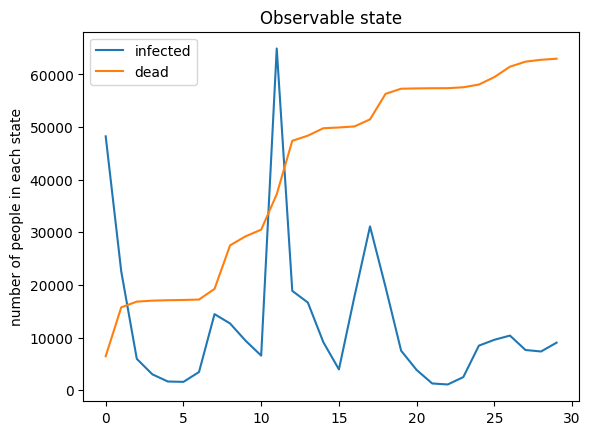

In [17]:
fig, ax = plt.subplots()
#states = total.keys()
#states = ['infected', 'dead', 'suceptible', 'exposed', 'recovered', 'initial_population']
states = ['infected', 'dead']

[ax.plot(total[y]) for y in states]
ax.legend(states)
ax.set_title('Observable state')
ax.set_ylabel('number of people in each state');

### Q1.a.3

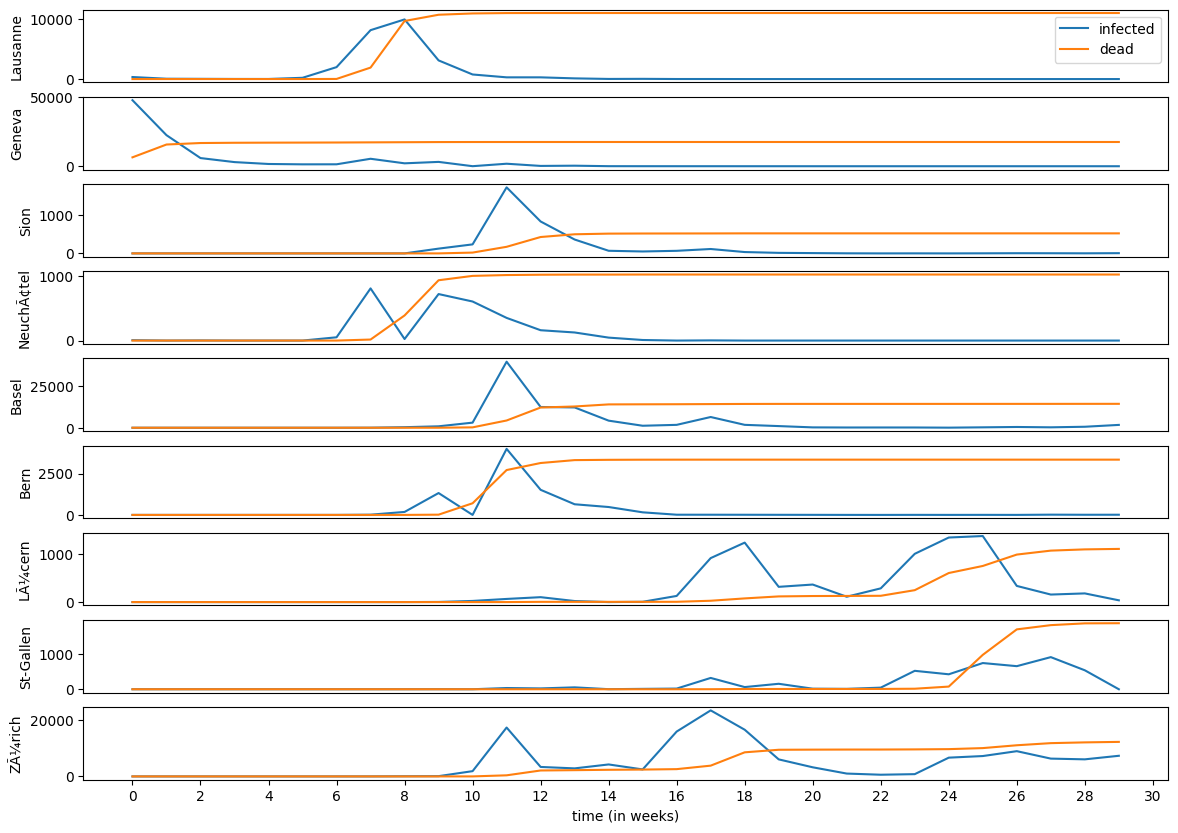

In [18]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_right = [plt.subplot2grid(shape=(9, 1), loc=(0, 0), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 1), loc=(i, 0), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Lausanne'].legend(['infected','dead'])
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

Text(0.5, 0, 'time (in weeks)')

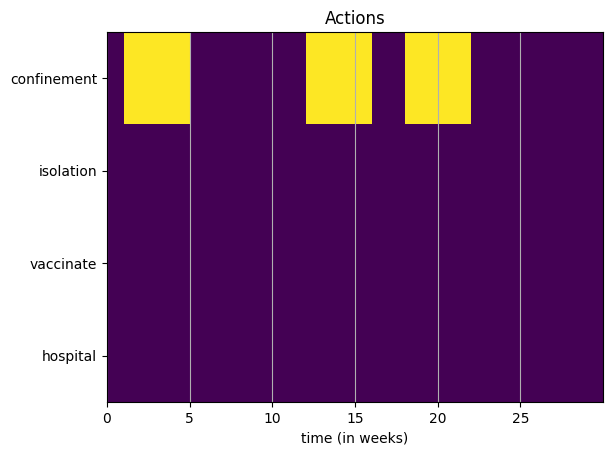

In [19]:
fig, ax = plt.subplots()

ax.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax.set_title('Actions')
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(list(actions.keys()))
ax.set_xticks(np.array([0,5,10,15,20,25]) - 0.5)
ax.set_xticklabels([0,5,10,15,20,25])
ax.grid(True, axis='x')
ax.set_xlabel('time (in weeks)')

### Discuss the difference with the unmitigated scenario

The number of dead is lower as the confinement is decided early

## Q2.b Evaluate Pr. Russo's Policy

In [20]:
agent = RussoAgent(env)
N_episodes = 50
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
seeds = torch.randint(0,100,(N_episodes,))
print("Seeds for episodes: ", seeds)

log = {"N_confinement":[],
      "R_cumulative":[],
      "N_deaths":[],
      }

""" Run the simulation """
for episode in tqdm(range(N_episodes)):
    N_confinement = 0
    R_cumulative = 0
    finished = False
    obs, info = env.reset(seed = int(seeds[episode]))
    agent.reset()
    agent.epsilon = 0
    while not finished:
        action = agent.act(obs)
        obs, R, finished, info = env.step(action)
        N_confinement += info.action['confinement']*7
        R_cumulative += float(R) 
        if finished:
            break
    N_deaths = obs.total.dead[-1]
    log["N_confinement"].append(N_confinement)
    log["R_cumulative"].append(R_cumulative)
    log["N_deaths"].append(N_deaths)

Seeds for episodes:  tensor([44, 39, 33, 60, 63, 79, 27,  3, 97, 83,  1, 66, 56, 99, 78, 76, 56, 68,
        94, 33, 26, 19, 91, 54, 24, 41, 69, 69, 49, 80, 81, 12, 63, 60, 95, 85,
        22, 99, 11, 88, 78, 43, 96, 89, 71, 57, 83, 95, 82, 71])


100%|██████████| 50/50 [01:31<00:00,  1.83s/it]


In [21]:
obs

Observation(pop={'Lausanne': 295000, 'Geneva': 900000, 'Sion': 34978, 'NeuchÃ¢tel': 44531, 'Basel': 830000, 'Bern': 133115, 'LÃ¼cern': 82000, 'St-Gallen': 76213, 'ZÃ¼rich': 1354000}, city={'Lausanne': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[9200, 9200, 9200, 9200, 9200, 9200, 9200]), 'Geneva': Observables(infected=[2, 2, 4, 2, 5, 8, 7], dead=[9300, 9300, 9300, 9300, 9300, 9300, 9300]), 'Sion': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[716, 716, 716, 716, 716, 716, 716]), 'NeuchÃ¢tel': Observables(infected=[0, 0, 1, 4, 3, 2, 1], dead=[474, 474, 474, 474, 474, 474, 474]), 'Basel': Observables(infected=[291, 303, 70, 220, 336, 291, 317], dead=[12597, 12597, 12597, 12597, 12597, 12597, 12597]), 'Bern': Observables(infected=[1, 2, 2, 2, 3, 1, 2], dead=[1303, 1303, 1303, 1303, 1303, 1303, 1303]), 'LÃ¼cern': Observables(infected=[7, 30, 55, 7, 57, 23, 38], dead=[2870, 2870, 2870, 2870, 2870, 2870, 2870]), 'St-Gallen': Observables(infected=[3128, 912, 808, 1366, 1094, 153, 58

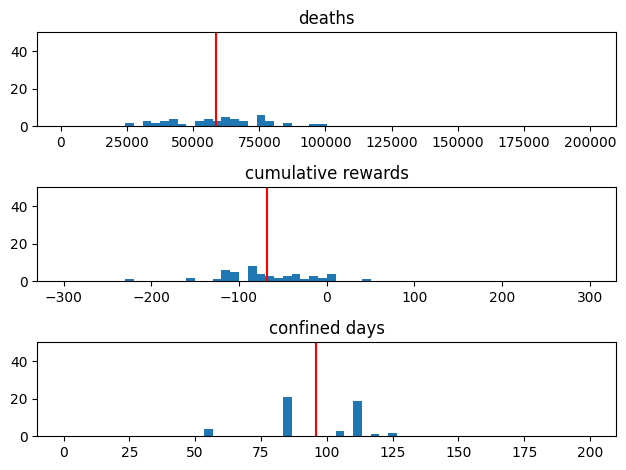

Average death number: 58742.96
Average number of confined days: 96.04
Average cumulative reward: -68.65014925063355


In [22]:
conf_days, rewards, deaths = log['N_confinement'], log['R_cumulative'], log['N_deaths']

fig, ax = plt.subplots(3,1)
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
print(f'Average cumulative reward: {np.mean(rewards)}')

## Q3.a Implementing Deep-Q learning

In [23]:
"""Loading the environment"""

action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

# we remove the observation preprocessor because it is easier in this task to deal with the initial data format
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [68]:
class DQN_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layers = nn.Sequential(
                    nn.Linear(126,64),
                    nn.ReLU(),
                    nn.Linear(64,32),
                    nn.ReLU(),
                    nn.Linear(32,16),
                    nn.ReLU()
        )
        self.output_layer = nn.Linear(16,2)
        
    def forward(self, S):
        S = torch.flatten(S, 1)
        # rescale 
        S = torch.pow(S, 0.25)
        Q = self.hidden_layers(S)
        Q = self.output_layer(Q)
        return Q
    
class BufferWrapper(gym.ObservationWrapper):
    """
    Only every k-th frame is collected by the buffer
    """
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer
    
    
class DQN_agent(Agent):
    def __init__(self, env:Env, states_nr=2*9*7, actions_nr=2, batch_size=2048, max_memory_size=20000, 
                 gamma=0.9, lr=1e3, max_exploration_rate=0.7, min_exploration_rate=0.1,
                 time_max = 500
                # Additionnal parameters to be added here
                ):
        self.env = env
        self.states_nr = states_nr
        self.actions_nr = actions_nr
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.network = DQN_network().to(self.device)
        self.target_network = copy.deepcopy(self.network)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=lr)
        self.memory_sample_size = batch_size
        self.max_memory_size = max_memory_size
        self.gamma = gamma
        self.max_exploration_rate = max_exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_rate = max_exploration_rate
        self.time_max = time_max
        self.l1 = nn.SmoothL1Loss().to(self.device)
        
        self.STATE_MEM = torch.zeros(max_memory_size, states_nr)
        self.ACTION_MEM = torch.zeros(max_memory_size, 1)
        self.REWARD_MEM = torch.zeros(max_memory_size, 1)
        self.STATE2_MEM = torch.zeros(max_memory_size, states_nr)
        self.DONE_MEM = torch.zeros(max_memory_size, 1)
        self.ending_position = 0
        self.num_in_queue = 0
        
    def remember(self, state, action, reward, state2, done):
        """Store the experiences in a buffer to use later"""
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = float(done)
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
    
    def batch_experiences(self):
        """Randomly sample 'batch size' experiences"""
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]      
        return STATE, ACTION, REWARD, STATE2, DONE
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def compute_epsilon(self, time):
        return max(self.max_exploration_rate *(self.time_max-time)/self.time_max, self.min_exploration_rate) 
    
    def act(self, state, time=0, full_greedy=False):
        """Epsilon-greedy action"""
        self.exploration_rate = self.compute_epsilon(time)
        if not full_greedy and random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.actions_nr)]])
        else:
            return torch.argmax(self.network(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
    
    def experience_replay(self):
        if self.memory_sample_size > self.num_in_queue:
            return
        # Sample a batch of experiences
        STATE, ACTION, REWARD, STATE2, DONE = self.batch_experiences()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
        target = REWARD + torch.mul((self.gamma * self.target_network(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)
        current = self.network(STATE).gather(1, ACTION.long())
        print("target",target,"current",current)
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error
    
    def update_target_network(self):
        self.target_network = copy.deepcopy(self.network)

In [72]:
def train_DQN(env, N_episodes=500, C=5):
    env.reset()
    agent = DQN_agent(env, time_max=N_episodes)    
    torch.manual_seed(0)
    torch.use_deterministic_algorithms(True)
    seeds = torch.randint(0,100,(N_episodes,))
    training_trace = []
    eval_trace = []
    
    for episode in tqdm(range(N_episodes)):
        R_cumulative = 0
        finished = False
        obs, info = env.reset(seed = int(seeds[episode]))
        t = 0
        while not finished:
            state1 = torch.flatten(obs, 1).squeeze(0)
            action = agent.act(obs)
            obs, R, finished, info = env.step(action)
            state2 = torch.flatten(obs, 1).squeeze(0)
            agent.remember(state1, action, R, state2, finished)
            agent.experience_replay()
            if t%5==C:
                agent.update_target_network()
            R_cumulative += float(R) 
            if finished:
                break
            t+=1
        training_trace.append(R_cumulative)
        
        if episode%50==0 or episode==N_episodes-1:
            with torch.no_grad():
                eval_rewards = []
                for eval_episode in range(5):
                    R_eval_cumulative = 0
                    finished = False
                    obs, info = env.reset(seed = int(seeds[eval_episode]))
                    print(int(seeds[eval_episode]))
                    while not finished:
                        action = agent.act(obs, full_greedy=True)
                        print("action: ", action)
                        obs, R, finished, info = env.step(action)
                        R_eval_cumulative += float(R) 
                        if finished:
                            break
                    print(R_eval_cumulative)
                    eval_rewards.append(R_eval_cumulative)
                eval_trace.append(np.mean(eval_rewards))
                                      
            
    return training_trace, eval_trace, agent

In [73]:
seeds[range(20)]

tensor([44, 39, 33, 60, 63, 79, 27,  3, 97, 83,  1, 66, 56, 99, 78, 76, 56, 68,
        94, 33])

In [74]:
N_episodes = 200
training_trace, eval_trace, agent = train_DQN(env, N_episodes=N_episodes)

  0%|          | 0/200 [00:00<?, ?it/s]

44
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
23.902928948402405
39
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  

  0%|          | 1/200 [00:10<35:54, 10.83s/it]

22.457266211509705


 25%|██▌       | 50/200 [01:37<04:17,  1.72s/it]

44
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
23.902928948402405
39
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  tensor([[1]])
action:  

 26%|██▌       | 51/200 [01:48<10:53,  4.39s/it]

action:  tensor([[1]])
22.457266211509705


 34%|███▍      | 68/200 [02:17<03:48,  1.73s/it]

target tensor([[ -4.7994],
        [ -2.5395],
        [  7.2020],
        ...,
        [-84.7523],
        [ -6.0292],
        [  6.9791]], grad_fn=<AddBackward0>) current tensor([[0.2334],
        [0.2135],
        [0.2235],
        ...,
        [0.2562],
        [0.1796],
        [0.1757]], grad_fn=<GatherBackward0>)
target tensor([[6.8855],
        [1.2276],
        [7.1891],
        ...,
        [0.8983],
        [1.2245],
        [0.9869]], grad_fn=<AddBackward0>) current tensor([[ 5.2962e+16],
        [-3.1052e+16],
        [ 3.3952e+16],
        ...,
        [-6.0242e+16],
        [-2.7279e+16],
        [ 2.5827e+17]], grad_fn=<GatherBackward0>)
target tensor([[  7.0000],
        [ -6.0136],
        [-11.4207],
        ...,
        [ -4.9515],
        [  0.9123],
        [  3.9275]], grad_fn=<AddBackward0>) current tensor([[-7.2043e+14],
        [ 7.5800e+13],
        [ 7.0033e+14],
        ...,
        [ 2.2003e+14],
        [ 3.4429e+14],
        [-6.1169e+14]], grad_fn=<Gath

 34%|███▍      | 69/200 [02:20<04:55,  2.26s/it]

target tensor([[ 0.7962],
        [ 0.8351],
        [ 7.1448],
        ...,
        [ 1.1840],
        [ 6.9009],
        [-7.7556]], grad_fn=<AddBackward0>) current tensor([[ 2992830.5000],
        [ 2992830.5000],
        [-2220086.5000],
        ...,
        [ 2992830.5000],
        [-2220087.0000],
        [ 2992830.0000]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1815],
        [ 4.3400],
        [ 1.2184],
        ...,
        [-9.0889],
        [ 1.1216],
        [-2.5395]], grad_fn=<AddBackward0>) current tensor([[ 4386657.5000],
        [-1131680.3750],
        [ 4386657.5000],
        ...,
        [ 4386657.5000],
        [ 4386658.5000],
        [ 4386658.5000]], grad_fn=<GatherBackward0>)
target tensor([[ 2.4900],
        [ 1.1880],
        [ 5.9270],
        ...,
        [-3.7178],
        [ 6.1350],
        [ 1.2253]], grad_fn=<AddBackward0>) current tensor([[1977714.0000],
        [2755069.7500],
        [1977714.0000],
        ...,
        [1977714.0000],
        

target tensor([[  1.1990],
        [-50.7532],
        [-45.3203],
        ...,
        [ -9.0889],
        [  1.1747],
        [-14.7626]], grad_fn=<AddBackward0>) current tensor([[-4190940.2500],
        [ 2283404.0000],
        [ 2283404.0000],
        ...,
        [-4190940.2500],
        [-4190940.2500],
        [-4190940.2500]], grad_fn=<GatherBackward0>)
target tensor([[  1.2178],
        [-23.7220],
        [ -4.7757],
        ...,
        [-15.4277],
        [  3.8870],
        [  3.1823]], grad_fn=<AddBackward0>) current tensor([[-1113095.6250],
        [-1113095.6250],
        [-1113095.6250],
        ...,
        [  263636.3750],
        [  263636.1875],
        [  263636.1875]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2295],
        [ 7.1643],
        [ 1.1990],
        ...,
        [-5.8437],
        [ 0.5587],
        [ 3.8822]], grad_fn=<AddBackward0>) current tensor([[ 3298966.2500],
        [-2737729.7500],
        [ 3298966.2500],
        ...,
        [ 3298966

 35%|███▌      | 70/200 [02:23<05:17,  2.44s/it]

target tensor([[7.2298],
        [1.2325],
        [0.9900],
        ...,
        [6.6276],
        [0.9129],
        [1.0396]], grad_fn=<AddBackward0>) current tensor([[ 3387162.5000],
        [-4088110.2500],
        [ 3387162.5000],
        ...,
        [ 3387162.5000],
        [-4088110.5000],
        [-4088110.5000]], grad_fn=<GatherBackward0>)
target tensor([[ 0.8477],
        [ 0.4546],
        [ 7.2000],
        ...,
        [ 6.8856],
        [-4.7806],
        [ 7.0689]], grad_fn=<AddBackward0>) current tensor([[-2500774.2500],
        [-2500774.2500],
        [ 2265884.0000],
        ...,
        [ 2265884.0000],
        [-2500774.2500],
        [ 2265884.0000]], grad_fn=<GatherBackward0>)
target tensor([[ 4.3400],
        [ 1.2161],
        [ 7.1081],
        ...,
        [-4.8143],
        [ 1.0425],
        [ 1.2238]], grad_fn=<AddBackward0>) current tensor([[117955.1406],
        [448370.3125],
        [117955.1406],
        ...,
        [448370.3125],
        [448369.84

target tensor([[ 7.1359],
        [ 6.2409],
        [ 0.5725],
        ...,
        [ 1.2218],
        [-4.9092],
        [ 1.2212]], grad_fn=<AddBackward0>) current tensor([[ 1525650.7500],
        [ 1525650.7500],
        [-1492137.3750],
        ...,
        [-1492137.3750],
        [-1492137.3750],
        [ 1525650.7500]], grad_fn=<GatherBackward0>)
target tensor([[ 2.9410],
        [-5.2342],
        [-4.7806],
        ...,
        [ 7.2171],
        [-5.5447],
        [-5.9678]], grad_fn=<AddBackward0>) current tensor([[354563.5000],
        [ 76051.2812],
        [ 76051.2812],
        ...,
        [354563.5000],
        [ 76051.4688],
        [ 76051.4688]], grad_fn=<GatherBackward0>)
target tensor([[  1.2253],
        [  1.2191],
        [  6.9645],
        ...,
        [  7.1228],
        [-20.1100],
        [ -1.4761]], grad_fn=<AddBackward0>) current tensor([[1112924.1250],
        [1112924.1250],
        [-658605.2500],
        ...,
        [-658605.2500],
        [-6586

 36%|███▌      | 71/200 [02:26<05:27,  2.54s/it]

target tensor([[ 6.9499],
        [ 1.2134],
        [ 4.7235],
        ...,
        [-7.2614],
        [ 6.7395],
        [ 6.8997]], grad_fn=<AddBackward0>) current tensor([[-696407.5625],
        [ 863406.5625],
        [-696407.5625],
        ...,
        [ 863406.5625],
        [-696407.3750],
        [-696407.3750]], grad_fn=<GatherBackward0>)
target tensor([[-45.8641],
        [  7.1943],
        [  0.7084],
        ...,
        [  6.4345],
        [-12.1789],
        [ -8.4890]], grad_fn=<AddBackward0>) current tensor([[ 113220.6797],
        [ 113220.6797],
        [-534378.3750],
        ...,
        [ 113220.6797],
        [-534378.1875],
        [-534378.1875]], grad_fn=<GatherBackward0>)
target tensor([[-50.6514],
        [-11.2123],
        [-15.0015],
        ...,
        [-14.9843],
        [ -5.1717],
        [  5.3368]], grad_fn=<AddBackward0>) current tensor([[ -14547.2617],
        [ -14547.2617],
        [-614298.1875],
        ...,
        [-614298.1875],
        

target tensor([[-5.1952],
        [-0.0391],
        [ 7.2113],
        ...,
        [-4.7670],
        [-8.8156],
        [ 0.5874]], grad_fn=<AddBackward0>) current tensor([[-199827.8594],
        [1175489.3750],
        [1175489.3750],
        ...,
        [-199827.8594],
        [1175489.3750],
        [-199827.9531]], grad_fn=<GatherBackward0>)
target tensor([[ -0.1824],
        [  0.6671],
        [  7.2301],
        ...,
        [-36.5976],
        [ -5.3975],
        [  3.8950]], grad_fn=<AddBackward0>) current tensor([[1512286.7500],
        [-570050.6875],
        [1512286.7500],
        ...,
        [-570050.6875],
        [-570050.7500],
        [1512286.7500]], grad_fn=<GatherBackward0>)
target tensor([[-41.4922],
        [ -4.2580],
        [ -8.9062],
        ...,
        [ -7.2614],
        [  1.2281],
        [ -5.1327]], grad_fn=<AddBackward0>) current tensor([[995643.1250],
        [153035.0469],
        [153035.0469],
        ...,
        [153035.0469],
        [153

 36%|███▌      | 72/200 [02:29<05:35,  2.62s/it]

target tensor([[  7.1243],
        [  6.9668],
        [ -2.5059],
        ...,
        [  1.2213],
        [-20.2914],
        [ -5.1228]], grad_fn=<AddBackward0>) current tensor([[121620.5469],
        [121620.5469],
        [  1262.3257],
        ...,
        [  1262.3257],
        [  1262.2793],
        [  1262.2793]], grad_fn=<GatherBackward0>)
target tensor([[  6.4774],
        [ -5.0439],
        [-21.3039],
        ...,
        [  6.8017],
        [  7.1840],
        [ -8.6203]], grad_fn=<AddBackward0>) current tensor([[ 150851.6562],
        [ 150851.6562],
        [-604658.7500],
        ...,
        [ 150851.6562],
        [ 150851.6875],
        [-604658.6875]], grad_fn=<GatherBackward0>)
target tensor([[  1.2642],
        [  6.9316],
        [  7.2025],
        ...,
        [-11.5090],
        [ -5.7704],
        [  1.2252]], grad_fn=<AddBackward0>) current tensor([[-535996.6250],
        [-535996.6250],
        [-535996.6250],
        ...,
        [ -84172.9688],
        

target tensor([[-21.3039],
        [  1.1398],
        [  1.1910],
        ...,
        [  7.2305],
        [  1.2301],
        [  7.0124]], grad_fn=<AddBackward0>) current tensor([[ 7240.7485],
        [ 7240.7485],
        [ 7240.7485],
        ...,
        [-5099.0352],
        [ 7240.7485],
        [-5099.0352]], grad_fn=<GatherBackward0>)
target tensor([[  7.2104],
        [ -7.7796],
        [  1.2154],
        ...,
        [-30.1032],
        [  1.2259],
        [-45.8641]], grad_fn=<AddBackward0>) current tensor([[-4554.5229],
        [ 6778.1104],
        [ 6778.1104],
        ...,
        [-4554.5229],
        [ 6778.1104],
        [-4554.5229]], grad_fn=<GatherBackward0>)
target tensor([[ 6.2057],
        [-4.7973],
        [ 7.0000],
        ...,
        [-0.7174],
        [ 1.2002],
        [ 6.4261]], grad_fn=<AddBackward0>) current tensor([[-3962.2742],
        [ 6263.2422],
        [-3962.2742],
        ...,
        [ 6263.2422],
        [ 6263.2422],
        [-3962.274

 36%|███▋      | 73/200 [02:32<05:36,  2.65s/it]

target tensor([[-75.4633],
        [  5.0751],
        [ -1.4392],
        ...,
        [-33.1028],
        [-91.6497],
        [  1.1922]], grad_fn=<AddBackward0>) current tensor([[-3330.6982],
        [-3330.6982],
        [-3330.6982],
        ...,
        [-3330.6982],
        [ 5698.0332],
        [ 5698.0332]], grad_fn=<GatherBackward0>)
target tensor([[-30.3130],
        [  0.7887],
        [  1.2133],
        ...,
        [  7.1290],
        [  7.2064],
        [ -9.9760]], grad_fn=<AddBackward0>) current tensor([[ 5088.5195],
        [ 5088.5195],
        [ 5088.5195],
        ...,
        [-2662.6416],
        [-2662.6416],
        [-2662.6416]], grad_fn=<GatherBackward0>)
target tensor([[  7.1295],
        [ -4.8022],
        [ -4.7725],
        ...,
        [-29.0406],
        [  1.2198],
        [-10.7011]], grad_fn=<AddBackward0>) current tensor([[-1963.1104],
        [ 4437.8945],
        [ 4437.8945],
        ...,
        [-1963.1104],
        [ 4437.8945],
        [ 44

target tensor([[  7.1885],
        [  6.6276],
        [-21.3039],
        ...,
        [  5.4758],
        [  1.1995],
        [  3.0389]], grad_fn=<AddBackward0>) current tensor([[315.8170],
        [315.8170],
        [369.7723],
        ...,
        [315.8170],
        [369.7723],
        [315.8170]], grad_fn=<GatherBackward0>)
target tensor([[  7.1614],
        [  1.2325],
        [  0.4593],
        ...,
        [ -0.4270],
        [  4.3930],
        [-38.7736]], grad_fn=<AddBackward0>) current tensor([[430.5365],
        [ 77.3805],
        [ 77.3805],
        ...,
        [430.5365],
        [430.5365],
        [430.5365]], grad_fn=<GatherBackward0>)
target tensor([[  5.7602],
        [  7.2225],
        [  7.0841],
        ...,
        [-94.7757],
        [-23.7220],
        [  0.9878]], grad_fn=<AddBackward0>) current tensor([[ 430.6630],
        [ 430.6630],
        [ 430.6630],
        ...,
        [-283.3975],
        [-283.3975],
        [-283.3975]], grad_fn=<GatherBack

 37%|███▋      | 74/200 [02:34<05:37,  2.68s/it]

target tensor([[  1.2209],
        [ -5.2226],
        [-37.7529],
        ...,
        [  7.2031],
        [  1.2399],
        [  6.9549]], grad_fn=<AddBackward0>) current tensor([[-507.8877],
        [-507.8877],
        [ 330.5480],
        ...,
        [ 330.5480],
        [-507.8877],
        [ 330.5480]], grad_fn=<GatherBackward0>)
target tensor([[ -4.7932],
        [-15.0828],
        [ -5.5260],
        ...,
        [  1.1600],
        [  5.8995],
        [  1.2072]], grad_fn=<AddBackward0>) current tensor([[-610.4761],
        [ 139.4084],
        [-610.4761],
        ...,
        [-610.4761],
        [ 139.4084],
        [-610.4761]], grad_fn=<GatherBackward0>)
target tensor([[ 7.2110],
        [ 7.2168],
        [-4.8247],
        ...,
        [ 1.0195],
        [-4.8021],
        [-4.8637]], grad_fn=<AddBackward0>) current tensor([[-133.5403],
        [-133.5403],
        [-603.2519],
        ...,
        [-603.2519],
        [-603.2519],
        [-603.2519]], grad_fn=<Gath

target tensor([[ 7.1943],
        [ 7.0517],
        [ 1.2279],
        ...,
        [-4.7677],
        [ 6.7172],
        [ 6.3821]], grad_fn=<AddBackward0>) current tensor([[ 72.9408],
        [ 72.9408],
        [-48.7831],
        ...,
        [-48.7831],
        [ 72.9408],
        [ 72.9408]], grad_fn=<GatherBackward0>)
target tensor([[  6.6724],
        [-39.3257],
        [-62.5713],
        ...,
        [ -4.8000],
        [ -5.8562],
        [ -5.2226]], grad_fn=<AddBackward0>) current tensor([[107.5086],
        [107.5086],
        [107.5086],
        ...,
        [ 64.1824],
        [ 64.1824],
        [ 64.1824]], grad_fn=<GatherBackward0>)
target tensor([[1.2042],
        [6.9906],
        [1.0993],
        ...,
        [1.2209],
        [1.1923],
        [1.1482]], grad_fn=<AddBackward0>) current tensor([[64.1560],
        [39.4534],
        [64.1560],
        ...,
        [64.1560],
        [64.1560],
        [64.1560]], grad_fn=<GatherBackward0>)
target tensor([[ 7.012

 38%|███▊      | 75/200 [02:37<05:37,  2.70s/it]

target tensor([[  7.2127],
        [-11.6185],
        [  1.1990],
        ...,
        [  7.2305],
        [ -5.3189],
        [ -5.1003]], grad_fn=<AddBackward0>) current tensor([[51.3677],
        [50.8377],
        [50.8377],
        ...,
        [51.3677],
        [50.8377],
        [50.8377]], grad_fn=<GatherBackward0>)
target tensor([[-5.9744],
        [ 6.5352],
        [ 1.1910],
        ...,
        [-5.2226],
        [-4.7932],
        [ 1.2209]], grad_fn=<AddBackward0>) current tensor([[-58.9327],
        [ 88.9816],
        [-58.9327],
        ...,
        [-58.9327],
        [-58.9327],
        [-58.9327]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2189],
        [ 7.1904],
        [ 0.9900],
        ...,
        [ 7.0517],
        [-5.1974],
        [ 1.2238]], grad_fn=<AddBackward0>) current tensor([[-53.7732],
        [ 26.4999],
        [ 26.4999],
        ...,
        [ 26.4999],
        [-53.7732],
        [-53.7732]], grad_fn=<GatherBackward0>)
target tensor([[

 38%|███▊      | 76/200 [02:40<05:36,  2.71s/it]

target tensor([[ 6.3135],
        [-4.7856],
        [ 7.2344],
        ...,
        [-4.7770],
        [ 1.2218],
        [ 7.1359]], grad_fn=<AddBackward0>) current tensor([[-8.7719],
        [54.9646],
        [-8.7719],
        ...,
        [54.9646],
        [54.9646],
        [-8.7719]], grad_fn=<GatherBackward0>)
target tensor([[  4.5124],
        [-16.6741],
        [ -8.4880],
        ...,
        [  6.4774],
        [  6.3480],
        [  7.1023]], grad_fn=<AddBackward0>) current tensor([[ 70.7356],
        [-55.5238],
        [ 70.7356],
        ...,
        [ 70.7356],
        [ 70.7356],
        [ 70.7356]], grad_fn=<GatherBackward0>)
target tensor([[  7.2154],
        [-31.7972],
        [  7.2100],
        ...,
        [  7.2187],
        [-11.4207],
        [  2.4900]], grad_fn=<AddBackward0>) current tensor([[ 36.2294],
        [ 36.2294],
        [ 36.2294],
        ...,
        [ 36.2294],
        [-60.5801],
        [ 36.2294]], grad_fn=<GatherBackward0>)
target ten

target tensor([[-8.9062],
        [ 5.4758],
        [ 6.0577],
        ...,
        [ 7.1885],
        [ 2.1568],
        [ 0.9574]], grad_fn=<AddBackward0>) current tensor([[-185.3867],
        [ -22.8748],
        [ -22.8748],
        ...,
        [ -22.8748],
        [ -22.8748],
        [-185.3867]], grad_fn=<GatherBackward0>)
target tensor([[  -2.0699],
        [   4.9604],
        [   7.2237],
        ...,
        [  -5.2741],
        [-100.6079],
        [  -4.7835]], grad_fn=<AddBackward0>) current tensor([[-256.7823],
        [  -8.6175],
        [  -8.6175],
        ...,
        [-256.7823],
        [  -8.6175],
        [-256.7823]], grad_fn=<GatherBackward0>)
target tensor([[  1.1677],
        [-11.5830],
        [  1.1722],
        ...,
        [ -5.5101],
        [ -4.8803],
        [ -7.2680]], grad_fn=<AddBackward0>) current tensor([[-219.4476],
        [-219.4476],
        [-219.4476],
        ...,
        [-219.4476],
        [-219.4476],
        [-219.4476]], grad_fn

 38%|███▊      | 77/200 [02:43<05:32,  2.71s/it]

target tensor([[ -6.6349],
        [  0.4802],
        [  1.2198],
        ...,
        [ -6.9044],
        [  6.9645],
        [-31.7972]], grad_fn=<AddBackward0>) current tensor([[-82.9535],
        [-82.9535],
        [-82.9535],
        ...,
        [-82.9535],
        [ 41.2045],
        [ 41.2045]], grad_fn=<GatherBackward0>)
target tensor([[  4.5618],
        [  1.1979],
        [ -3.2321],
        ...,
        [  1.2209],
        [-35.3661],
        [  1.0848]], grad_fn=<AddBackward0>) current tensor([[-90.1688],
        [136.0156],
        [136.0156],
        ...,
        [136.0156],
        [136.0156],
        [136.0156]], grad_fn=<GatherBackward0>)
target tensor([[ -5.1228],
        [  6.0912],
        [-26.2897],
        ...,
        [  6.9965],
        [  6.8143],
        [  1.2125]], grad_fn=<AddBackward0>) current tensor([[ 233.4858],
        [-108.1165],
        [ 233.4858],
        ...,
        [-108.1165],
        [-108.1165],
        [ 233.4858]], grad_fn=<GatherBack

target tensor([[-17.9990],
        [  6.9689],
        [-62.5713],
        ...,
        [ -5.2226],
        [  7.1885],
        [ -4.7787]], grad_fn=<AddBackward0>) current tensor([[212.6626],
        [ 36.7942],
        [ 36.7942],
        ...,
        [212.6626],
        [ 36.7942],
        [212.6626]], grad_fn=<GatherBackward0>)
target tensor([[  3.5792],
        [-15.8182],
        [ -5.0956],
        ...,
        [  1.1437],
        [  1.2259],
        [  6.0449]], grad_fn=<AddBackward0>) current tensor([[ 16.8673],
        [185.0567],
        [185.0567],
        ...,
        [185.0567],
        [185.0567],
        [ 16.8673]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8415],
        [  0.9622],
        [-20.4618],
        ...,
        [  6.9689],
        [  5.7602],
        [  7.1100]], grad_fn=<AddBackward0>) current tensor([[  61.4670],
        [-105.3808],
        [-105.3808],
        ...,
        [-105.3808],
        [-105.3808],
        [-105.3808]], grad_fn=<GatherBack

 39%|███▉      | 78/200 [02:45<05:35,  2.75s/it]

target tensor([[-29.5417],
        [  6.0577],
        [ -1.9760],
        ...,
        [  7.1081],
        [-38.1693],
        [ -6.2379]], grad_fn=<AddBackward0>) current tensor([[ 137.9350],
        [ 137.9350],
        [ 137.9350],
        ...,
        [ 137.9350],
        [ 137.9350],
        [-226.3187]], grad_fn=<GatherBackward0>)
target tensor([[  4.3752],
        [  1.1474],
        [  4.3752],
        ...,
        [-15.8182],
        [ -2.3134],
        [ -2.7739]], grad_fn=<AddBackward0>) current tensor([[ 179.3396],
        [-113.2774],
        [ 179.3396],
        ...,
        [-113.2774],
        [-113.2774],
        [-113.2774]], grad_fn=<GatherBackward0>)
target tensor([[  1.2305],
        [  0.7887],
        [-26.0577],
        ...,
        [  6.9965],
        [  3.8822],
        [  1.2174]], grad_fn=<AddBackward0>) current tensor([[ 89.8305],
        [ 89.8305],
        [115.3726],
        ...,
        [115.3726],
        [115.3726],
        [ 89.8305]], grad_fn=<Gath

target tensor([[-5.8562],
        [ 7.0953],
        [ 7.2258],
        ...,
        [ 3.9725],
        [-5.2588],
        [-5.9777]], grad_fn=<AddBackward0>) current tensor([[ 19.9955],
        [-68.3991],
        [-68.3991],
        ...,
        [-68.3991],
        [ 19.9955],
        [ 19.9955]], grad_fn=<GatherBackward0>)
target tensor([[  1.2192],
        [  1.1929],
        [-36.2582],
        ...,
        [  7.1362],
        [  7.1751],
        [  7.2113]], grad_fn=<AddBackward0>) current tensor([[-168.1739],
        [-168.1739],
        [-168.1739],
        ...,
        [  77.3666],
        [  77.3666],
        [  77.3666]], grad_fn=<GatherBackward0>)
target tensor([[ 5.8679],
        [ 4.6429],
        [-4.7917],
        ...,
        [-3.2321],
        [-9.6446],
        [ 6.5380]], grad_fn=<AddBackward0>) current tensor([[ 106.6166],
        [ 106.6166],
        [-236.2831],
        ...,
        [-236.2831],
        [-236.2831],
        [ 106.6166]], grad_fn=<GatherBackward0>

 40%|███▉      | 79/200 [02:48<05:41,  2.83s/it]

target tensor([[ -8.7303],
        [  6.9549],
        [ -7.3642],
        ...,
        [ -5.5101],
        [-16.9202],
        [  0.8477]], grad_fn=<AddBackward0>) current tensor([[ 163.7527],
        [-189.1835],
        [ 163.7527],
        ...,
        [ 163.7527],
        [ 163.7527],
        [ 163.7527]], grad_fn=<GatherBackward0>)
target tensor([[  0.2783],
        [-14.9181],
        [  7.1512],
        ...,
        [  1.2198],
        [  6.5812],
        [ -4.7787]], grad_fn=<AddBackward0>) current tensor([[ 264.5348],
        [-131.0056],
        [-131.0056],
        ...,
        [ 264.5348],
        [-131.0056],
        [ 264.5348]], grad_fn=<GatherBackward0>)
target tensor([[ -5.3130],
        [  0.2747],
        [  3.8270],
        ...,
        [  6.6276],
        [-15.8972],
        [  1.2037]], grad_fn=<AddBackward0>) current tensor([[255.8078],
        [255.8078],
        [ 24.9944],
        ...,
        [ 24.9944],
        [255.8078],
        [255.8078]], grad_fn=<Gath

target tensor([[-5.0956],
        [ 7.0000],
        [-0.1824],
        ...,
        [ 7.1903],
        [ 1.2237],
        [-8.8238]], grad_fn=<AddBackward0>) current tensor([[-103.4349],
        [ -37.7129],
        [ -37.7129],
        ...,
        [ -37.7129],
        [-103.4349],
        [-103.4349]], grad_fn=<GatherBackward0>)
target tensor([[  5.4654],
        [  6.4531],
        [-99.7695],
        ...,
        [-14.9843],
        [  5.8995],
        [  7.2149]], grad_fn=<AddBackward0>) current tensor([[ -16.8562],
        [ -16.8562],
        [ -16.8562],
        ...,
        [-100.0237],
        [ -16.8562],
        [ -16.8562]], grad_fn=<GatherBackward0>)
target tensor([[  0.9276],
        [-25.9826],
        [  1.1699],
        ...,
        [  6.8252],
        [  7.2063],
        [  1.2154]], grad_fn=<AddBackward0>) current tensor([[ 4.6647],
        [79.6840],
        [ 4.6647],
        ...,
        [79.6840],
        [79.6840],
        [ 4.6647]], grad_fn=<GatherBackward0>

 40%|████      | 80/200 [02:51<05:35,  2.80s/it]

target tensor([[-58.6681],
        [  6.5380],
        [ -8.4289],
        ...,
        [  1.2071],
        [  1.2041],
        [  6.9953]], grad_fn=<AddBackward0>) current tensor([[63.4491],
        [63.4491],
        [-1.5966],
        ...,
        [-1.5966],
        [-1.5966],
        [63.4491]], grad_fn=<GatherBackward0>)
target tensor([[-10.6514],
        [ -4.1058],
        [ -4.2792],
        ...,
        [ -6.3658],
        [-15.1473],
        [ -4.8809]], grad_fn=<AddBackward0>) current tensor([[-15.2795],
        [-15.2795],
        [-52.9105],
        ...,
        [-15.2795],
        [-52.9105],
        [-15.2795]], grad_fn=<GatherBackward0>)
target tensor([[  4.1276],
        [  7.0000],
        [-91.6497],
        ...,
        [ -6.7223],
        [-41.8705],
        [  0.7887]], grad_fn=<AddBackward0>) current tensor([[-57.0710],
        [-57.0710],
        [ 53.9367],
        ...,
        [ 53.9367],
        [-57.0710],
        [ 53.9367]], grad_fn=<GatherBackward0>)
targ

target tensor([[  4.8966],
        [-27.0481],
        [  0.9409],
        ...,
        [ -9.0889],
        [  1.1935],
        [  7.2092]], grad_fn=<AddBackward0>) current tensor([[  53.1573],
        [-108.0429],
        [-108.0429],
        ...,
        [-108.0429],
        [-108.0429],
        [  53.1573]], grad_fn=<GatherBackward0>)
target tensor([[  7.1057],
        [  7.0517],
        [-37.0346],
        ...,
        [ -1.5654],
        [ -0.7065],
        [  4.9727]], grad_fn=<AddBackward0>) current tensor([[54.5664],
        [54.5664],
        [54.5664],
        ...,
        [14.5974],
        [54.5664],
        [54.5664]], grad_fn=<GatherBackward0>)
target tensor([[-12.8651],
        [  6.6142],
        [ -5.1717],
        ...,
        [  6.7626],
        [  1.2314],
        [  5.5033]], grad_fn=<AddBackward0>) current tensor([[ 24.0683],
        [-47.6501],
        [ 24.0683],
        ...,
        [-47.6501],
        [ 24.0683],
        [-47.6501]], grad_fn=<GatherBackward0>

 40%|████      | 81/200 [02:54<05:39,  2.85s/it]

target tensor([[ 6.6570],
        [ 0.7887],
        [ 1.1662],
        ...,
        [-7.7757],
        [-9.8545],
        [ 1.1922]], grad_fn=<AddBackward0>) current tensor([[32.6967],
        [68.8343],
        [68.8343],
        ...,
        [68.8343],
        [68.8343],
        [68.8343]], grad_fn=<GatherBackward0>)
target tensor([[ 2.1568],
        [ 7.2380],
        [-4.7857],
        ...,
        [ 7.1359],
        [ 1.0756],
        [ 6.1778]], grad_fn=<AddBackward0>) current tensor([[-83.7710],
        [-83.7710],
        [ 67.6983],
        ...,
        [-83.7710],
        [ 67.6983],
        [-83.7710]], grad_fn=<GatherBackward0>)
target tensor([[-5.0023],
        [ 1.1474],
        [ 7.0866],
        ...,
        [ 1.1770],
        [-4.7711],
        [-5.1755]], grad_fn=<AddBackward0>) current tensor([[-36.0214],
        [-36.0214],
        [-90.6380],
        ...,
        [-36.0214],
        [-36.0214],
        [-36.0214]], grad_fn=<GatherBackward0>)
target tensor([[1.1677

target tensor([[1.0993],
        [5.7633],
        [1.2330],
        ...,
        [0.4546],
        [1.2316],
        [1.0919]], grad_fn=<AddBackward0>) current tensor([[24.2996],
        [24.4164],
        [24.2996],
        ...,
        [24.2996],
        [24.2996],
        [24.2996]], grad_fn=<GatherBackward0>)
target tensor([[ 0.9044],
        [-0.4270],
        [-4.8022],
        ...,
        [ 7.1699],
        [ 6.9306],
        [ 1.1263]], grad_fn=<AddBackward0>) current tensor([[ -92.4311],
        [-166.2688],
        [ -92.4311],
        ...,
        [-166.2688],
        [-166.2688],
        [ -92.4311]], grad_fn=<GatherBackward0>)
target tensor([[ 0.0607],
        [-9.1479],
        [-6.6991],
        ...,
        [ 7.1925],
        [-7.3621],
        [-4.2792]], grad_fn=<AddBackward0>) current tensor([[ -96.1696],
        [ -96.1696],
        [ -96.1696],
        ...,
        [-234.6382],
        [ -96.1696],
        [-234.6382]], grad_fn=<GatherBackward0>)


 41%|████      | 82/200 [02:57<05:34,  2.83s/it]

target tensor([[  3.7296],
        [  1.2012],
        [ -0.3645],
        ...,
        [  1.1719],
        [-10.1852],
        [ -5.9678]], grad_fn=<AddBackward0>) current tensor([[-191.5784],
        [   0.8453],
        [   0.8453],
        ...,
        [   0.8453],
        [   0.8453],
        [   0.8453]], grad_fn=<GatherBackward0>)
target tensor([[0.3786],
        [1.2133],
        [1.2071],
        ...,
        [7.2225],
        [7.1093],
        [7.2083]], grad_fn=<AddBackward0>) current tensor([[ 42.6616],
        [ 42.6616],
        [ 42.6616],
        ...,
        [-46.0616],
        [-46.0616],
        [-46.0616]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1600],
        [-9.0354],
        [ 1.2323],
        ...,
        [ 1.0619],
        [ 7.2226],
        [ 6.9549]], grad_fn=<AddBackward0>) current tensor([[-23.5310],
        [-23.5310],
        [-23.5310],
        ...,
        [-23.5310],
        [177.6732],
        [177.6732]], grad_fn=<GatherBackward0>)
target ten

target tensor([[-14.9181],
        [  7.1961],
        [  1.1866],
        ...,
        [  1.2213],
        [  6.4980],
        [ -6.6349]], grad_fn=<AddBackward0>) current tensor([[112.6179],
        [112.6179],
        [-38.1487],
        ...,
        [-38.1487],
        [112.6179],
        [-38.1487]], grad_fn=<GatherBackward0>)
target tensor([[ 7.0864],
        [ 6.2538],
        [ 6.0365],
        ...,
        [ 1.1348],
        [-5.0154],
        [ 7.1630]], grad_fn=<AddBackward0>) current tensor([[ 82.9986],
        [ 82.9986],
        [ 82.9986],
        ...,
        [192.3830],
        [192.3830],
        [ 82.9986]], grad_fn=<GatherBackward0>)
target tensor([[  7.2064],
        [  0.6267],
        [ -6.7890],
        ...,
        [-14.4823],
        [-10.1965],
        [ -5.3130]], grad_fn=<AddBackward0>) current tensor([[-45.2970],
        [296.6166],
        [296.6166],
        ...,
        [-45.2970],
        [-45.2970],
        [296.6166]], grad_fn=<GatherBackward0>)


 42%|████▏     | 83/200 [03:00<05:25,  2.78s/it]

target tensor([[ 1.2250],
        [-0.0767],
        [ 2.4900],
        ...,
        [ 7.0689],
        [ 0.9900],
        [-5.0224]], grad_fn=<AddBackward0>) current tensor([[286.9154],
        [286.9154],
        [-70.1404],
        ...,
        [-70.1404],
        [-70.1404],
        [286.9154]], grad_fn=<GatherBackward0>)
target tensor([[-27.0835],
        [  7.1964],
        [  0.5411],
        ...,
        [  7.1359],
        [  1.1937],
        [  3.9275]], grad_fn=<AddBackward0>) current tensor([[  5.6702],
        [  5.6702],
        [  5.6702],
        ...,
        [  5.6702],
        [174.9793],
        [  5.6702]], grad_fn=<GatherBackward0>)
target tensor([[ 6.4375],
        [ 1.0268],
        [ 4.8966],
        ...,
        [ 7.1897],
        [-4.9663],
        [-6.6201]], grad_fn=<AddBackward0>) current tensor([[ 83.6594],
        [-30.0903],
        [ 83.6594],
        ...,
        [ 83.6594],
        [-30.0903],
        [-30.0903]], grad_fn=<GatherBackward0>)
target ten

target tensor([[ -4.8168],
        [ -4.8168],
        [  6.5303],
        ...,
        [-15.0828],
        [ -2.5395],
        [  6.6724]], grad_fn=<AddBackward0>) current tensor([[151.7795],
        [151.7795],
        [-76.1603],
        ...,
        [-76.1603],
        [151.7795],
        [-76.1603]], grad_fn=<GatherBackward0>)
target tensor([[  7.2173],
        [ -0.6209],
        [ -4.7735],
        ...,
        [-37.7529],
        [ -5.5199],
        [  0.9635]], grad_fn=<AddBackward0>) current tensor([[ 11.3437],
        [ 11.3437],
        [198.3992],
        ...,
        [ 11.3437],
        [198.3992],
        [198.3992]], grad_fn=<GatherBackward0>)
target tensor([[ 0.8721],
        [-6.4541],
        [-4.9444],
        ...,
        [ 1.1853],
        [-0.6604],
        [ 1.2156]], grad_fn=<AddBackward0>) current tensor([[141.8024],
        [141.8024],
        [141.8024],
        ...,
        [141.8024],
        [-16.7912],
        [141.8024]], grad_fn=<GatherBackward0>)
targ

 42%|████▏     | 84/200 [03:02<05:23,  2.79s/it]

target tensor([[  5.8063],
        [-20.2914],
        [ -4.7890],
        ...,
        [  0.8477],
        [  0.9029],
        [ -5.1974]], grad_fn=<AddBackward0>) current tensor([[ 58.1939],
        [110.5747],
        [110.5747],
        ...,
        [110.5747],
        [110.5747],
        [110.5747]], grad_fn=<GatherBackward0>)
target tensor([[  7.2097],
        [ -4.7917],
        [-88.5756],
        ...,
        [ -7.1018],
        [  1.2331],
        [  0.4783]], grad_fn=<AddBackward0>) current tensor([[  5.6983],
        [127.2236],
        [127.2236],
        ...,
        [127.2236],
        [127.2236],
        [  5.6983]], grad_fn=<GatherBackward0>)
target tensor([[-5.0640],
        [ 6.3258],
        [ 0.4593],
        ...,
        [-5.7704],
        [ 0.8844],
        [ 1.0471]], grad_fn=<AddBackward0>) current tensor([[-32.2701],
        [-32.2701],
        [ 40.2694],
        ...,
        [-32.2701],
        [ 40.2694],
        [ 40.2694]], grad_fn=<GatherBackward0>)
targ

target tensor([[  7.2287],
        [  6.3480],
        [  6.2947],
        ...,
        [  4.9727],
        [ -8.2894],
        [-29.7759]], grad_fn=<AddBackward0>) current tensor([[-139.3292],
        [-139.3292],
        [-139.3292],
        ...,
        [-139.3292],
        [ -34.1310],
        [ -34.1310]], grad_fn=<GatherBackward0>)
target tensor([[  5.1517],
        [  4.7235],
        [-13.8514],
        ...,
        [  7.2122],
        [ -4.2436],
        [  7.2038]], grad_fn=<AddBackward0>) current tensor([[-180.1266],
        [-180.1266],
        [-180.1266],
        ...,
        [-180.1266],
        [ -59.6878],
        [-180.1266]], grad_fn=<GatherBackward0>)
target tensor([[1.1856],
        [7.1723],
        [1.2067],
        ...,
        [6.6142],
        [1.0229],
        [4.3885]], grad_fn=<AddBackward0>) current tensor([[  20.6561],
        [-117.3978],
        [  20.6561],
        ...,
        [-117.3978],
        [  20.6561],
        [-117.3978]], grad_fn=<GatherBack

 42%|████▎     | 85/200 [03:05<05:20,  2.79s/it]

target tensor([[-23.5318],
        [  6.9965],
        [ -4.7973],
        ...,
        [  0.0756],
        [ -4.8918],
        [  1.1722]], grad_fn=<AddBackward0>) current tensor([[-8.5599],
        [42.6034],
        [-8.5599],
        ...,
        [42.6034],
        [-8.5599],
        [-8.5599]], grad_fn=<GatherBackward0>)
target tensor([[-4.8022],
        [-5.3189],
        [ 0.9635],
        ...,
        [ 7.1514],
        [ 7.1740],
        [-4.8454]], grad_fn=<AddBackward0>) current tensor([[33.5389],
        [33.5389],
        [33.5389],
        ...,
        [83.6836],
        [83.6836],
        [33.5389]], grad_fn=<GatherBackward0>)
target tensor([[  0.9011],
        [-17.5252],
        [  6.4046],
        ...,
        [  7.0474],
        [  6.1454],
        [  6.4261]], grad_fn=<AddBackward0>) current tensor([[-30.0655],
        [ 16.5931],
        [ 16.5931],
        ...,
        [ 16.5931],
        [ 16.5931],
        [ 16.5931]], grad_fn=<GatherBackward0>)
target tensor([[

target tensor([[  1.1482],
        [-54.0401],
        [  7.2063],
        ...,
        [-39.3257],
        [  0.9315],
        [  1.1773]], grad_fn=<AddBackward0>) current tensor([[-22.5372],
        [124.8026],
        [124.8026],
        ...,
        [124.8026],
        [-22.5372],
        [-22.5372]], grad_fn=<GatherBackward0>)
target tensor([[  7.2101],
        [-26.5302],
        [  1.1866],
        ...,
        [  4.5892],
        [  7.2073],
        [  3.1185]], grad_fn=<AddBackward0>) current tensor([[ 60.6321],
        [111.8484],
        [111.8484],
        ...,
        [ 60.6321],
        [ 60.6321],
        [ 60.6321]], grad_fn=<GatherBackward0>)
target tensor([[ -5.1755],
        [-13.8421],
        [  1.1294],
        ...,
        [  1.1601],
        [-96.1160],
        [-27.0835]], grad_fn=<AddBackward0>) current tensor([[ 131.1990],
        [-101.1405],
        [ 131.1990],
        ...,
        [ 131.1990],
        [-101.1405],
        [-101.1405]], grad_fn=<GatherBack

 43%|████▎     | 86/200 [03:08<05:23,  2.84s/it]

target tensor([[  7.2092],
        [ -5.0956],
        [  1.2337],
        ...,
        [  4.5124],
        [-13.0904],
        [-30.4757]], grad_fn=<AddBackward0>) current tensor([[ 127.0627],
        [-141.1562],
        [-141.1562],
        ...,
        [ 127.0627],
        [-141.1562],
        [ 127.0627]], grad_fn=<GatherBackward0>)
target tensor([[-5.1974],
        [ 6.4451],
        [ 1.2279],
        ...,
        [ 0.5956],
        [ 1.2062],
        [-7.2614]], grad_fn=<AddBackward0>) current tensor([[ 6.3027],
        [63.9434],
        [ 6.3027],
        ...,
        [ 6.3027],
        [ 6.3027],
        [ 6.3027]], grad_fn=<GatherBackward0>)
target tensor([[  1.0293],
        [ -5.5199],
        [  6.4925],
        ...,
        [-34.5417],
        [  1.0478],
        [  0.9622]], grad_fn=<AddBackward0>) current tensor([[ 38.4048],
        [ 38.4048],
        [-97.8833],
        ...,
        [ 38.4048],
        [ 38.4048],
        [-97.8833]], grad_fn=<GatherBackward0>)
targ

target tensor([[-4.8022],
        [ 1.1888],
        [ 0.2539],
        ...,
        [ 7.2088],
        [ 6.6670],
        [ 7.1942]], grad_fn=<AddBackward0>) current tensor([[63.8215],
        [63.8215],
        [63.8215],
        ...,
        [-0.3672],
        [-0.3672],
        [-0.3672]], grad_fn=<GatherBackward0>)
target tensor([[  1.2087],
        [  7.2250],
        [  1.0791],
        ...,
        [ -0.7065],
        [ -5.0640],
        [-38.1693]], grad_fn=<AddBackward0>) current tensor([[-164.5924],
        [  21.9319],
        [-164.5924],
        ...,
        [  21.9319],
        [  21.9319],
        [  21.9319]], grad_fn=<GatherBackward0>)
target tensor([[  2.9410],
        [-70.5965],
        [  1.1951],
        ...,
        [  7.2154],
        [ -4.8316],
        [  7.1448]], grad_fn=<AddBackward0>) current tensor([[ -60.6490],
        [ -60.6490],
        [-267.2004],
        ...,
        [ -60.6490],
        [-267.2004],
        [ -60.6490]], grad_fn=<GatherBackward0>

 44%|████▎     | 87/200 [03:11<05:19,  2.83s/it]

target tensor([[ -27.2702],
        [  -4.7815],
        [   6.2409],
        ...,
        [ -32.4653],
        [   6.6849],
        [-121.4323]], grad_fn=<AddBackward0>) current tensor([[-258.9940],
        [-258.9940],
        [ -36.3981],
        ...,
        [ -36.3981],
        [ -36.3981],
        [-258.9940]], grad_fn=<GatherBackward0>)
target tensor([[-67.7269],
        [  7.2044],
        [  1.4556],
        ...,
        [ -5.5384],
        [  5.8409],
        [  1.1838]], grad_fn=<AddBackward0>) current tensor([[  77.8211],
        [  77.8211],
        [  77.8211],
        ...,
        [-151.4396],
        [  77.8211],
        [-151.4396]], grad_fn=<GatherBackward0>)
target tensor([[7.0000],
        [1.1929],
        [7.1994],
        ...,
        [1.1840],
        [1.0475],
        [7.2284]], grad_fn=<AddBackward0>) current tensor([[75.2083],
        [45.8135],
        [75.2083],
        ...,
        [45.8135],
        [45.8135],
        [75.2083]], grad_fn=<GatherBackward0>

target tensor([[ 7.0739],
        [-8.9472],
        [ 1.1990],
        ...,
        [ 4.3400],
        [-1.9105],
        [ 7.2226]], grad_fn=<AddBackward0>) current tensor([[26.2570],
        [26.2570],
        [48.8082],
        ...,
        [26.2570],
        [48.8082],
        [26.2570]], grad_fn=<GatherBackward0>)
target tensor([[-20.6195],
        [  6.9792],
        [  1.1747],
        ...,
        [-15.1292],
        [  1.2253],
        [  1.1838]], grad_fn=<AddBackward0>) current tensor([[  37.8144],
        [-112.4703],
        [  37.8144],
        ...,
        [  37.8144],
        [  37.8144],
        [  37.8144]], grad_fn=<GatherBackward0>)
target tensor([[  0.9350],
        [ -4.7920],
        [ -4.8873],
        ...,
        [  6.4531],
        [-29.7428],
        [  6.2149]], grad_fn=<AddBackward0>) current tensor([[ -74.8359],
        [ -74.8359],
        [ -74.8359],
        ...,
        [-134.8548],
        [ -74.8359],
        [-134.8548]], grad_fn=<GatherBackward0>

 44%|████▍     | 88/200 [03:14<05:14,  2.81s/it]

target tensor([[-10.9998],
        [  7.2036],
        [-50.7532],
        ...,
        [  7.1657],
        [  1.2266],
        [ -4.9267]], grad_fn=<AddBackward0>) current tensor([[164.4926],
        [164.4926],
        [164.4926],
        ...,
        [164.4926],
        [ 14.3877],
        [ 14.3877]], grad_fn=<GatherBackward0>)
target tensor([[ 7.2063],
        [ 3.8822],
        [-4.9092],
        ...,
        [-4.1415],
        [ 6.8855],
        [-5.3975]], grad_fn=<AddBackward0>) current tensor([[105.1344],
        [105.1344],
        [-98.8736],
        ...,
        [-98.8736],
        [105.1344],
        [-98.8736]], grad_fn=<GatherBackward0>)
target tensor([[  1.0000],
        [  5.8679],
        [  1.2218],
        ...,
        [-12.5294],
        [-10.6514],
        [  7.2173]], grad_fn=<AddBackward0>) current tensor([[-98.6499],
        [-51.9982],
        [-98.6499],
        ...,
        [-98.6499],
        [-98.6499],
        [-51.9982]], grad_fn=<GatherBackward0>)
targ

target tensor([[-5.1280],
        [ 5.7602],
        [-4.8891],
        ...,
        [ 1.1437],
        [ 7.2228],
        [-1.3692]], grad_fn=<AddBackward0>) current tensor([[-163.7574],
        [ 127.9435],
        [-163.7574],
        ...,
        [-163.7574],
        [ 127.9435],
        [-163.7574]], grad_fn=<GatherBackward0>)
target tensor([[-38.8972],
        [  0.2783],
        [ -0.8933],
        ...,
        [  7.2103],
        [  7.1635],
        [  7.1897]], grad_fn=<AddBackward0>) current tensor([[-214.8180],
        [-214.8180],
        [-214.8180],
        ...,
        [ 167.3373],
        [ 167.3373],
        [ 167.3373]], grad_fn=<GatherBackward0>)
target tensor([[  1.2383],
        [  6.8232],
        [  1.2250],
        ...,
        [ -9.0354],
        [  1.2072],
        [-31.7245]], grad_fn=<AddBackward0>) current tensor([[-162.1942],
        [  95.1118],
        [-162.1942],
        ...,
        [-162.1942],
        [-162.1942],
        [  95.1118]], grad_fn=<Gath

 44%|████▍     | 89/200 [03:16<05:10,  2.80s/it]

target tensor([[-13.3834],
        [  0.8925],
        [  1.2067],
        ...,
        [ -4.8507],
        [  6.9965],
        [  7.0961]], grad_fn=<AddBackward0>) current tensor([[-13.0881],
        [-13.0881],
        [-13.0881],
        ...,
        [-13.0881],
        [-74.0725],
        [-74.0725]], grad_fn=<GatherBackward0>)
target tensor([[ 7.2118],
        [-6.7574],
        [ 1.0475],
        ...,
        [ 7.1851],
        [-6.6349],
        [ 5.8217]], grad_fn=<AddBackward0>) current tensor([[-126.1540],
        [ 201.2347],
        [ 201.2347],
        ...,
        [-126.1540],
        [ 201.2347],
        [-126.1540]], grad_fn=<GatherBackward0>)
target tensor([[  6.2947],
        [-21.2156],
        [  1.2264],
        ...,
        [  7.1729],
        [ -8.9062],
        [ -0.9943]], grad_fn=<AddBackward0>) current tensor([[-70.9525],
        [-70.9525],
        [291.1801],
        ...,
        [-70.9525],
        [291.1801],
        [291.1801]], grad_fn=<GatherBackward0>

target tensor([[ 7.1359],
        [ 7.2349],
        [-4.8829],
        ...,
        [ 1.1851],
        [ 7.2147],
        [ 6.6605]], grad_fn=<AddBackward0>) current tensor([[  -1.5582],
        [  -1.5582],
        [-102.8920],
        ...,
        [-102.8920],
        [  -1.5582],
        [  -1.5582]], grad_fn=<GatherBackward0>)
target tensor([[  7.1758],
        [  6.3436],
        [-26.8005],
        ...,
        [  0.7079],
        [  7.2226],
        [  7.1334]], grad_fn=<AddBackward0>) current tensor([[-41.2605],
        [-41.2605],
        [-97.1152],
        ...,
        [-97.1152],
        [-41.2605],
        [-41.2605]], grad_fn=<GatherBackward0>)
target tensor([[ 7.1729],
        [-9.4061],
        [-6.0102],
        ...,
        [-6.5545],
        [ 1.2012],
        [ 6.6605]], grad_fn=<AddBackward0>) current tensor([[14.7987],
        [14.7987],
        [14.7987],
        ...,
        [14.7987],
        [11.0315],
        [14.7987]], grad_fn=<GatherBackward0>)


 45%|████▌     | 90/200 [03:19<05:08,  2.80s/it]

target tensor([[-6.7174],
        [ 7.1295],
        [ 1.2144],
        ...,
        [-4.8215],
        [-0.5014],
        [-4.7725]], grad_fn=<AddBackward0>) current tensor([[ 10.0252],
        [-42.6683],
        [ 10.0252],
        ...,
        [ 10.0252],
        [ 10.0252],
        [ 10.0252]], grad_fn=<GatherBackward0>)
target tensor([[ 6.9792],
        [-8.1894],
        [ 0.1636],
        ...,
        [-4.7936],
        [ 7.1180],
        [ 7.2101]], grad_fn=<AddBackward0>) current tensor([[  0.6281],
        [-89.2254],
        [  0.6281],
        ...,
        [-89.2254],
        [  0.6281],
        [  0.6281]], grad_fn=<GatherBackward0>)
target tensor([[ 7.0873],
        [ 1.2301],
        [ 0.7611],
        ...,
        [ 7.2110],
        [ 1.0883],
        [-8.3974]], grad_fn=<AddBackward0>) current tensor([[ 83.7705],
        [-73.5808],
        [-73.5808],
        ...,
        [ 83.7705],
        [-73.5808],
        [-73.5808]], grad_fn=<GatherBackward0>)
target tensor([[

target tensor([[ 0.1636],
        [ 4.5841],
        [-4.7725],
        ...,
        [ 5.8185],
        [-5.0154],
        [ 1.1994]], grad_fn=<AddBackward0>) current tensor([[-22.1403],
        [-22.1403],
        [ 28.4512],
        ...,
        [-22.1403],
        [ 28.4512],
        [ 28.4512]], grad_fn=<GatherBackward0>)
target tensor([[-16.5611],
        [  1.1838],
        [  1.2252],
        ...,
        [  7.2281],
        [  1.2279],
        [  1.1882]], grad_fn=<AddBackward0>) current tensor([[23.8760],
        [23.8760],
        [23.8760],
        ...,
        [83.8115],
        [23.8760],
        [23.8760]], grad_fn=<GatherBackward0>)
target tensor([[-4.2580],
        [ 0.9350],
        [ 0.9162],
        ...,
        [ 1.0000],
        [ 4.0066],
        [ 0.9683]], grad_fn=<AddBackward0>) current tensor([[-85.1270],
        [-85.1270],
        [-85.1270],
        ...,
        [-85.1270],
        [ 78.3544],
        [-85.1270]], grad_fn=<GatherBackward0>)


 46%|████▌     | 91/200 [03:22<05:02,  2.77s/it]

target tensor([[-12.8629],
        [  7.1052],
        [ -1.8390],
        ...,
        [ -4.7916],
        [  7.2225],
        [  7.1180]], grad_fn=<AddBackward0>) current tensor([[-32.4225],
        [-32.4225],
        [-32.4225],
        ...,
        [-83.7178],
        [-32.4225],
        [-32.4225]], grad_fn=<GatherBackward0>)
target tensor([[-19.8727],
        [  1.2191],
        [  7.1362],
        ...,
        [  1.1449],
        [-15.8586],
        [ -0.0767]], grad_fn=<AddBackward0>) current tensor([[ 21.2774],
        [ 21.2774],
        [-46.9870],
        ...,
        [ 21.2774],
        [ 21.2774],
        [ 21.2774]], grad_fn=<GatherBackward0>)
target tensor([[ 6.5570],
        [ 6.3664],
        [ 6.2409],
        ...,
        [ 4.8567],
        [ 7.2298],
        [-0.4253]], grad_fn=<AddBackward0>) current tensor([[32.8254],
        [32.8254],
        [32.8254],
        ...,
        [32.8254],
        [32.8254],
        [32.8254]], grad_fn=<GatherBackward0>)
target ten

target tensor([[ 4.5124],
        [ 6.5380],
        [-1.4761],
        ...,
        [-4.8011],
        [-4.7940],
        [-5.6974]], grad_fn=<AddBackward0>) current tensor([[-91.9680],
        [-91.9680],
        [-91.9680],
        ...,
        [-34.6668],
        [-34.6668],
        [-34.6668]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1727],
        [ 1.3266],
        [ 1.0396],
        ...,
        [ 7.2107],
        [ 0.4908],
        [-4.2792]], grad_fn=<AddBackward0>) current tensor([[-2.2328],
        [61.4750],
        [-2.2328],
        ...,
        [61.4750],
        [61.4750],
        [61.4750]], grad_fn=<GatherBackward0>)
target tensor([[ -4.7859],
        [-31.7972],
        [  1.1935],
        ...,
        [-37.0346],
        [-27.7591],
        [  1.1929]], grad_fn=<AddBackward0>) current tensor([[21.5056],
        [91.8180],
        [21.5056],
        ...,
        [91.8180],
        [21.5056],
        [21.5056]], grad_fn=<GatherBackward0>)


 46%|████▌     | 92/200 [03:25<04:59,  2.77s/it]

target tensor([[ -5.1327],
        [  7.1124],
        [  6.4765],
        ...,
        [ -1.5654],
        [-22.4642],
        [  7.1093]], grad_fn=<AddBackward0>) current tensor([[-59.6800],
        [ 15.5175],
        [ 15.5175],
        ...,
        [-59.6800],
        [-59.6800],
        [ 15.5175]], grad_fn=<GatherBackward0>)
target tensor([[6.0781],
        [4.0015],
        [7.2088],
        ...,
        [4.5841],
        [7.1840],
        [6.0577]], grad_fn=<AddBackward0>) current tensor([[-157.6947],
        [-157.6947],
        [-157.6947],
        ...,
        [-157.6947],
        [-157.6947],
        [-157.6947]], grad_fn=<GatherBackward0>)
target tensor([[ 6.8371e+00],
        [ 1.1384e+00],
        [ 9.9336e-01],
        ...,
        [-3.9100e-02],
        [-4.0483e+01],
        [ 6.1350e+00]], grad_fn=<AddBackward0>) current tensor([[-208.1873],
        [  86.7190],
        [  86.7190],
        ...,
        [-208.1873],
        [-208.1873],
        [-208.1873]], grad_fn

target tensor([[ -7.4730],
        [ -2.1960],
        [-14.9843],
        ...,
        [  7.2095],
        [  1.2028],
        [  7.2225]], grad_fn=<AddBackward0>) current tensor([[243.8867],
        [243.8867],
        [243.8867],
        ...,
        [354.5829],
        [243.8867],
        [354.5829]], grad_fn=<GatherBackward0>)
target tensor([[ 7.1290],
        [ 7.0000],
        [-5.3669],
        ...,
        [-4.8495],
        [ 7.1897],
        [-4.8165]], grad_fn=<AddBackward0>) current tensor([[264.2409],
        [264.2409],
        [132.7090],
        ...,
        [132.7090],
        [264.2409],
        [132.7090]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2286],
        [-5.0023],
        [ 0.1237],
        ...,
        [-4.8143],
        [ 6.9645],
        [ 7.1872]], grad_fn=<AddBackward0>) current tensor([[-69.8748],
        [-69.8748],
        [-69.8748],
        ...,
        [-69.8748],
        [ 79.3383],
        [ 79.3383]], grad_fn=<GatherBackward0>)
target ten

 46%|████▋     | 93/200 [03:28<04:58,  2.79s/it]

target tensor([[  3.2183],
        [-31.7972],
        [  5.5033],
        ...,
        [  6.7892],
        [  5.1273],
        [ -0.5043]], grad_fn=<AddBackward0>) current tensor([[-255.7809],
        [-255.7809],
        [-255.7809],
        ...,
        [-255.7809],
        [-255.7809],
        [-255.7809]], grad_fn=<GatherBackward0>)
target tensor([[  7.2154],
        [  5.9762],
        [  7.1290],
        ...,
        [  7.1665],
        [  1.2323],
        [-13.6796]], grad_fn=<AddBackward0>) current tensor([[-70.7905],
        [-70.7905],
        [-70.7905],
        ...,
        [-70.7905],
        [-71.6428],
        [-70.7905]], grad_fn=<GatherBackward0>)
target tensor([[ 4.3646],
        [-4.8168],
        [ 6.7172],
        ...,
        [ 1.1538],
        [ 7.1807],
        [ 4.7250]], grad_fn=<AddBackward0>) current tensor([[193.5057],
        [-51.7182],
        [193.5057],
        ...,
        [-51.7182],
        [193.5057],
        [193.5057]], grad_fn=<GatherBackward0>

target tensor([[ 1.2287e+00],
        [-3.9100e-02],
        [-4.2792e+00],
        ...,
        [ 3.8886e+00],
        [-5.5191e+00],
        [-1.3793e+02]], grad_fn=<AddBackward0>) current tensor([[-80.2110],
        [-65.0429],
        [-65.0429],
        ...,
        [-65.0429],
        [-80.2110],
        [-65.0429]], grad_fn=<GatherBackward0>)
target tensor([[ 6.5812],
        [ 5.7602],
        [-4.8637],
        ...,
        [ 1.0883],
        [ 1.4556],
        [-6.9293]], grad_fn=<AddBackward0>) current tensor([[-138.9184],
        [-138.9184],
        [  20.8935],
        ...,
        [  20.8935],
        [-138.9184],
        [  20.8935]], grad_fn=<GatherBackward0>)
target tensor([[  7.1405],
        [  2.9200],
        [-14.0820],
        ...,
        [ -0.7174],
        [-15.8182],
        [  3.5928]], grad_fn=<AddBackward0>) current tensor([[-101.1247],
        [-101.1247],
        [  10.2530],
        ...,
        [  10.2530],
        [  10.2530],
        [-101.1247]], g

 47%|████▋     | 94/200 [03:30<04:55,  2.78s/it]

target tensor([[  1.2052],
        [ -5.4618],
        [  6.9370],
        ...,
        [ -0.8013],
        [  7.1427],
        [-31.7712]], grad_fn=<AddBackward0>) current tensor([[-101.5275],
        [-101.5275],
        [  35.2657],
        ...,
        [  35.2657],
        [  35.2657],
        [  35.2657]], grad_fn=<GatherBackward0>)
target tensor([[  6.7738],
        [  7.2026],
        [  7.1730],
        ...,
        [ -1.5100],
        [-20.0746],
        [  1.2253]], grad_fn=<AddBackward0>) current tensor([[  53.4283],
        [  53.4283],
        [  53.4283],
        ...,
        [-100.9831],
        [  53.4283],
        [-100.9831]], grad_fn=<GatherBackward0>)
target tensor([[-18.5303],
        [  1.1775],
        [  0.9507],
        ...,
        [  1.2095],
        [  1.1909],
        [  0.4783]], grad_fn=<AddBackward0>) current tensor([[-34.9008],
        [  0.7453],
        [  0.7453],
        ...,
        [  0.7453],
        [  0.7453],
        [-34.9008]], grad_fn=<Gath

target tensor([[-5.4173],
        [-0.6884],
        [-0.1824],
        ...,
        [ 4.5892],
        [ 5.9270],
        [-5.0477]], grad_fn=<AddBackward0>) current tensor([[  57.0452],
        [-134.9761],
        [-134.9761],
        ...,
        [-134.9761],
        [-134.9761],
        [  57.0452]], grad_fn=<GatherBackward0>)
target tensor([[ -5.1228],
        [-16.7018],
        [  1.1990],
        ...,
        [  1.2154],
        [  0.6924],
        [ -4.8320]], grad_fn=<AddBackward0>) current tensor([[100.7054],
        [-56.1168],
        [100.7054],
        ...,
        [100.7054],
        [100.7054],
        [100.7054]], grad_fn=<GatherBackward0>)
target tensor([[-18.1209],
        [  1.2071],
        [  1.1196],
        ...,
        [  1.1895],
        [-20.0746],
        [ -7.5913]], grad_fn=<AddBackward0>) current tensor([[ 40.4008],
        [ 40.4008],
        [ 40.4008],
        ...,
        [ 40.4008],
        [112.9895],
        [ 40.4008]], grad_fn=<GatherBackward0>

 48%|████▊     | 95/200 [03:33<04:51,  2.77s/it]

target tensor([[-2.0080],
        [ 3.1185],
        [ 1.2316],
        ...,
        [ 1.1248],
        [ 1.2078],
        [ 1.1758]], grad_fn=<AddBackward0>) current tensor([[-113.4736],
        [ 158.6110],
        [-113.4736],
        ...,
        [-113.4736],
        [-113.4736],
        [-113.4736]], grad_fn=<GatherBackward0>)
target tensor([[ 1.6856],
        [-1.4121],
        [ 1.2305],
        ...,
        [ 5.3136],
        [ 6.8997],
        [-1.6457]], grad_fn=<AddBackward0>) current tensor([[  93.9643],
        [-151.5913],
        [-151.5913],
        ...,
        [  93.9643],
        [  93.9643],
        [-151.5913]], grad_fn=<GatherBackward0>)
target tensor([[ 5.8217],
        [ 1.0607],
        [ 7.2087],
        ...,
        [-4.8022],
        [ 1.2259],
        [-5.0800]], grad_fn=<AddBackward0>) current tensor([[-69.3774],
        [-85.0494],
        [-69.3774],
        ...,
        [-85.0494],
        [-85.0494],
        [-85.0494]], grad_fn=<GatherBackward0>)
targ

target tensor([[ 1.1747],
        [-9.9384],
        [ 1.2174],
        ...,
        [ 7.2226],
        [ 1.2311],
        [ 5.5999]], grad_fn=<AddBackward0>) current tensor([[55.8042],
        [55.8042],
        [55.8042],
        ...,
        [50.4320],
        [55.8042],
        [50.4320]], grad_fn=<GatherBackward0>)
target tensor([[  1.2309],
        [  1.1765],
        [  7.1440],
        ...,
        [ -4.7856],
        [ -4.7829],
        [-50.2042]], grad_fn=<AddBackward0>) current tensor([[ 98.8936],
        [ 98.8936],
        [-59.0084],
        ...,
        [ 98.8936],
        [ 98.8936],
        [-59.0084]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1984],
        [-4.8323],
        [ 6.8759],
        ...,
        [-5.6140],
        [-5.0396],
        [ 6.1350]], grad_fn=<AddBackward0>) current tensor([[ 35.8112],
        [ 35.8112],
        [-58.4648],
        ...,
        [ 35.8112],
        [ 35.8112],
        [-58.4648]], grad_fn=<GatherBackward0>)


 48%|████▊     | 96/200 [03:36<04:44,  2.74s/it]

target tensor([[ 1.2144],
        [-0.0391],
        [ 7.2011],
        ...,
        [ 7.2118],
        [ 6.9645],
        [ 7.1657]], grad_fn=<AddBackward0>) current tensor([[-123.2985],
        [  37.9970],
        [  37.9970],
        ...,
        [  37.9970],
        [  37.9970],
        [  37.9970]], grad_fn=<GatherBackward0>)
target tensor([[ 0.0756],
        [-0.9461],
        [ 1.2209],
        ...,
        [-8.7303],
        [ 6.8759],
        [-6.6325]], grad_fn=<AddBackward0>) current tensor([[  19.8356],
        [  19.8356],
        [-165.5039],
        ...,
        [-165.5039],
        [  19.8356],
        [-165.5039]], grad_fn=<GatherBackward0>)
target tensor([[1.2161],
        [2.9410],
        [6.7194],
        ...,
        [1.0666],
        [1.1922],
        [5.7317]], grad_fn=<AddBackward0>) current tensor([[-100.2917],
        [ -99.0520],
        [ -99.0520],
        ...,
        [-100.2917],
        [-100.2917],
        [ -99.0520]], grad_fn=<GatherBackward0>)
targ

target tensor([[ 5.0696],
        [ 6.5799],
        [ 1.2399],
        ...,
        [-5.0787],
        [ 1.2174],
        [-0.9943]], grad_fn=<AddBackward0>) current tensor([[215.9930],
        [215.9930],
        [ 36.4675],
        ...,
        [ 36.4675],
        [ 36.4675],
        [ 36.4675]], grad_fn=<GatherBackward0>)
target tensor([[  6.5799],
        [  7.1743],
        [ -5.3669],
        ...,
        [  0.9622],
        [-48.9308],
        [  1.0305]], grad_fn=<AddBackward0>) current tensor([[187.8534],
        [187.8534],
        [ 82.8536],
        ...,
        [187.8534],
        [ 82.8536],
        [ 82.8536]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2334],
        [-4.8165],
        [-5.1204],
        ...,
        [ 1.2287],
        [ 1.0293],
        [-5.0503]], grad_fn=<AddBackward0>) current tensor([[23.5627],
        [23.5627],
        [23.5627],
        ...,
        [23.5627],
        [23.5627],
        [23.5627]], grad_fn=<GatherBackward0>)
target tensor([[

 48%|████▊     | 97/200 [03:38<04:41,  2.73s/it]

target tensor([[  7.1810],
        [  7.2122],
        [  0.9029],
        ...,
        [  2.1113],
        [-11.6871],
        [  1.2189]], grad_fn=<AddBackward0>) current tensor([[-97.1868],
        [-97.1868],
        [ 40.9154],
        ...,
        [-97.1868],
        [ 40.9154],
        [ 40.9154]], grad_fn=<GatherBackward0>)
target tensor([[ -6.5545],
        [  0.9353],
        [  6.1498],
        ...,
        [-19.8310],
        [ -7.3621],
        [ -4.8122]], grad_fn=<AddBackward0>) current tensor([[124.5321],
        [ 81.3855],
        [124.5321],
        ...,
        [124.5321],
        [ 81.3855],
        [ 81.3855]], grad_fn=<GatherBackward0>)
target tensor([[ 0.9487],
        [ 1.1882],
        [ 7.2103],
        ...,
        [ 3.9275],
        [-5.7228],
        [-4.8901]], grad_fn=<AddBackward0>) current tensor([[ 14.8470],
        [ 14.8470],
        [221.4780],
        ...,
        [221.4780],
        [ 14.8470],
        [ 14.8470]], grad_fn=<GatherBackward0>)
targ

 49%|████▉     | 98/200 [03:41<04:37,  2.72s/it]

target tensor([[ 6.7924],
        [ 7.0602],
        [ 4.3400],
        ...,
        [ 5.0613],
        [ 2.8336],
        [-4.8920]], grad_fn=<AddBackward0>) current tensor([[ 125.1146],
        [ 125.1146],
        [ 125.1146],
        ...,
        [ 125.1146],
        [ 125.1146],
        [-141.4325]], grad_fn=<GatherBackward0>)
target tensor([[ 5.9035],
        [-5.0956],
        [-0.0391],
        ...,
        [ 3.3422],
        [ 1.0000],
        [ 1.2198]], grad_fn=<AddBackward0>) current tensor([[  -7.0191],
        [-188.0127],
        [  -7.0191],
        ...,
        [  -7.0191],
        [-188.0127],
        [-188.0127]], grad_fn=<GatherBackward0>)
target tensor([[ 7.2110],
        [ 5.7461],
        [ 1.2150],
        ...,
        [-8.3149],
        [ 1.1530],
        [-3.7815]], grad_fn=<AddBackward0>) current tensor([[ -61.8553],
        [ -61.8553],
        [-129.8866],
        ...,
        [ -61.8553],
        [-129.8866],
        [-129.8866]], grad_fn=<GatherBackward0>

target tensor([[-4.7724],
        [ 0.0607],
        [-4.8070],
        ...,
        [ 5.9443],
        [ 1.1873],
        [ 5.8995]], grad_fn=<AddBackward0>) current tensor([[ -84.1069],
        [ -84.1069],
        [ -84.1069],
        ...,
        [-164.6167],
        [ -84.1069],
        [-164.6167]], grad_fn=<GatherBackward0>)
target tensor([[  7.2088],
        [-10.1852],
        [  1.0799],
        ...,
        [ -4.8199],
        [-30.3433],
        [  1.1699]], grad_fn=<AddBackward0>) current tensor([[-234.4976],
        [-101.5259],
        [-101.5259],
        ...,
        [-101.5259],
        [-101.5259],
        [-101.5259]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2054],
        [ 7.1359],
        [ 7.2136],
        ...,
        [-0.4253],
        [ 0.8556],
        [-6.2039]], grad_fn=<AddBackward0>) current tensor([[ -18.1475],
        [-190.3106],
        [-190.3106],
        ...,
        [-190.3106],
        [ -18.1475],
        [-190.3106]], grad_fn=<GatherBack

 50%|████▉     | 99/200 [03:44<04:40,  2.78s/it]

target tensor([[ -5.1974],
        [  7.0529],
        [  5.4476],
        ...,
        [ -7.3642],
        [-27.0835],
        [  2.3207]], grad_fn=<AddBackward0>) current tensor([[-29.4220],
        [270.8236],
        [270.8236],
        ...,
        [-29.4220],
        [270.8236],
        [270.8236]], grad_fn=<GatherBackward0>)
target tensor([[  1.2259],
        [-46.4527],
        [  0.9276],
        ...,
        [ -5.3227],
        [  7.2036],
        [ -5.3669]], grad_fn=<AddBackward0>) current tensor([[-74.4853],
        [-74.4853],
        [-74.4853],
        ...,
        [-74.4853],
        [153.6501],
        [-74.4853]], grad_fn=<GatherBackward0>)
target tensor([[-72.1007],
        [  7.2092],
        [  1.2195],
        ...,
        [ -5.2665],
        [-13.6796],
        [  7.2036]], grad_fn=<AddBackward0>) current tensor([[-59.2405],
        [-59.2405],
        [-17.2974],
        ...,
        [-17.2974],
        [-59.2405],
        [-59.2405]], grad_fn=<GatherBackward0>

target tensor([[  7.2007],
        [-79.8859],
        [  0.7900],
        ...,
        [  4.8550],
        [  6.9906],
        [ -4.8165]], grad_fn=<AddBackward0>) current tensor([[-115.6910],
        [-115.6910],
        [  73.4267],
        ...,
        [-115.6910],
        [-115.6910],
        [  73.4267]], grad_fn=<GatherBackward0>)
target tensor([[-5.3723],
        [ 7.2240],
        [-6.6325],
        ...,
        [ 0.0756],
        [ 6.4659],
        [-5.1336]], grad_fn=<AddBackward0>) current tensor([[-94.0335],
        [-47.5952],
        [-94.0335],
        ...,
        [-47.5952],
        [-47.5952],
        [-94.0335]], grad_fn=<GatherBackward0>)
target tensor([[  7.2038],
        [  7.1664],
        [-39.6218],
        ...,
        [ -5.2531],
        [ -5.0787],
        [  1.2237]], grad_fn=<AddBackward0>) current tensor([[ 107.0110],
        [ 107.0110],
        [-141.4850],
        ...,
        [-141.4850],
        [-141.4850],
        [-141.4850]], grad_fn=<GatherBack

 50%|█████     | 100/200 [03:47<04:41,  2.82s/it]

target tensor([[  7.0864],
        [  7.2044],
        [ -8.1624],
        ...,
        [-61.4870],
        [  1.2086],
        [  1.0396]], grad_fn=<AddBackward0>) current tensor([[140.4123],
        [140.4123],
        [-83.5430],
        ...,
        [140.4123],
        [-83.5430],
        [-83.5430]], grad_fn=<GatherBackward0>)
target tensor([[-8.3727],
        [ 7.1774],
        [ 6.3480],
        ...,
        [-9.1535],
        [-4.8829],
        [ 0.9029]], grad_fn=<AddBackward0>) current tensor([[69.2676],
        [69.2676],
        [69.2676],
        ...,
        [72.0423],
        [72.0423],
        [72.0423]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8650],
        [-12.8560],
        [ -5.0477],
        ...,
        [  1.1437],
        [  2.6719],
        [  7.1656]], grad_fn=<AddBackward0>) current tensor([[ 111.7162],
        [ 111.7162],
        [ 111.7162],
        ...,
        [ 111.7162],
        [-100.7898],
        [-100.7898]], grad_fn=<GatherBackward0>)
targ

target tensor([[  1.2101],
        [ -6.4587],
        [  7.2173],
        ...,
        [  4.7250],
        [  6.5352],
        [-10.6862]], grad_fn=<AddBackward0>) current tensor([[ 90.9166],
        [ 90.9166],
        [-27.3058],
        ...,
        [-27.3058],
        [-27.3058],
        [ 90.9166]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2287],
        [ 6.8280],
        [-8.4880],
        ...,
        [-5.9690],
        [ 7.2053],
        [ 1.1016]], grad_fn=<AddBackward0>) current tensor([[-4.3034],
        [25.6508],
        [25.6508],
        ...,
        [-4.3034],
        [25.6508],
        [-4.3034]], grad_fn=<GatherBackward0>)
target tensor([[  1.2331],
        [-38.1994],
        [  1.1685],
        ...,
        [  6.9827],
        [ -6.0734],
        [ -5.2999]], grad_fn=<AddBackward0>) current tensor([[-89.2186],
        [-31.0357],
        [-89.2186],
        ...,
        [-31.0357],
        [-31.0357],
        [-89.2186]], grad_fn=<GatherBackward0>)
target ten

 50%|█████     | 101/200 [04:00<09:56,  6.03s/it]

action:  tensor([[0]])
-146.11494326591492
target tensor([[ 0.9315],
        [ 1.2264],
        [-9.9760],
        ...,
        [ 1.2335],
        [-2.5059],
        [-3.3712]], grad_fn=<AddBackward0>) current tensor([[-35.9738],
        [-35.9738],
        [ 92.6212],
        ...,
        [-35.9738],
        [-35.9738],
        [-35.9738]], grad_fn=<GatherBackward0>)
target tensor([[ -6.5443],
        [  0.8721],
        [  7.1976],
        ...,
        [ -4.8634],
        [-10.6862],
        [-39.3257]], grad_fn=<AddBackward0>) current tensor([[-25.9392],
        [-25.9392],
        [ 88.9830],
        ...,
        [-25.9392],
        [-25.9392],
        [ 88.9830]], grad_fn=<GatherBackward0>)
target tensor([[ -6.6991],
        [  7.1243],
        [  3.9275],
        ...,
        [ -7.8954],
        [ -0.7065],
        [-27.0835]], grad_fn=<AddBackward0>) current tensor([[ 75.0846],
        [-18.0275],
        [-18.0275],
        ...,
        [ 75.0846],
        [-18.0275],
        [

target tensor([[  6.4925],
        [-12.5294],
        [  6.8496],
        ...,
        [-61.7434],
        [-24.8527],
        [  7.0000]], grad_fn=<AddBackward0>) current tensor([[36.1945],
        [99.4177],
        [36.1945],
        ...,
        [36.1945],
        [36.1945],
        [36.1945]], grad_fn=<GatherBackward0>)
target tensor([[ -5.9690],
        [  6.2642],
        [-67.3713],
        ...,
        [  4.9652],
        [  1.2184],
        [  7.0000]], grad_fn=<AddBackward0>) current tensor([[150.7257],
        [-41.8916],
        [150.7257],
        ...,
        [-41.8916],
        [150.7257],
        [-41.8916]], grad_fn=<GatherBackward0>)


 51%|█████     | 102/200 [04:04<08:32,  5.23s/it]

target tensor([[ -1.5100],
        [ -4.8624],
        [  1.1851],
        ...,
        [ -2.9492],
        [-12.5294],
        [-20.4618]], grad_fn=<AddBackward0>) current tensor([[ 98.9754],
        [ 98.9754],
        [ 98.9754],
        ...,
        [-15.8536],
        [ 98.9754],
        [-15.8536]], grad_fn=<GatherBackward0>)
target tensor([[  7.0911],
        [  7.1124],
        [  7.2118],
        ...,
        [-10.0163],
        [ -7.4521],
        [-44.2558]], grad_fn=<AddBackward0>) current tensor([[81.5568],
        [81.5568],
        [81.5568],
        ...,
        [81.5568],
        [81.5568],
        [81.5568]], grad_fn=<GatherBackward0>)
target tensor([[  1.1924],
        [  1.2267],
        [  7.1594],
        ...,
        [ -4.1415],
        [  0.8477],
        [-55.7404]], grad_fn=<AddBackward0>) current tensor([[-81.3370],
        [-81.3370],
        [ 66.4185],
        ...,
        [-81.3370],
        [-81.3370],
        [-81.3370]], grad_fn=<GatherBackward0>)
targ

target tensor([[ 5.7602],
        [ 7.0000],
        [-5.0278],
        ...,
        [ 7.1904],
        [-6.5664],
        [ 1.2003]], grad_fn=<AddBackward0>) current tensor([[ 184.2195],
        [ 184.2195],
        [-193.8631],
        ...,
        [ 184.2195],
        [ 184.2195],
        [-193.8631]], grad_fn=<GatherBackward0>)
target tensor([[-39.3257],
        [  1.1853],
        [  7.0873],
        ...,
        [  7.1614],
        [ -4.7820],
        [  1.2014]], grad_fn=<AddBackward0>) current tensor([[  27.7693],
        [-143.8537],
        [  27.7693],
        ...,
        [  27.7693],
        [-143.8537],
        [-143.8537]], grad_fn=<GatherBackward0>)
target tensor([[ 7.1898],
        [ 1.2189],
        [-9.0889],
        ...,
        [-1.8390],
        [ 1.1699],
        [ 1.1958]], grad_fn=<AddBackward0>) current tensor([[-220.0871],
        [   1.1098],
        [   1.1098],
        ...,
        [-220.0871],
        [   1.1098],
        [   1.1098]], grad_fn=<GatherBack

 52%|█████▏    | 103/200 [04:07<07:24,  4.58s/it]

target tensor([[  0.9907],
        [  1.2245],
        [-20.6378],
        ...,
        [ -4.7968],
        [  5.1517],
        [  7.2249]], grad_fn=<AddBackward0>) current tensor([[ -98.8220],
        [ -98.8220],
        [-228.2304],
        ...,
        [ -98.8220],
        [-228.2304],
        [-228.2304]], grad_fn=<GatherBackward0>)
target tensor([[ -4.2580],
        [ -4.8045],
        [  7.1943],
        ...,
        [  7.1851],
        [-58.9052],
        [  1.2287]], grad_fn=<AddBackward0>) current tensor([[-119.3831],
        [-119.3831],
        [ -26.0956],
        ...,
        [ -26.0956],
        [ -26.0956],
        [-119.3831]], grad_fn=<GatherBackward0>)
target tensor([[  4.6383],
        [-38.0402],
        [  1.1384],
        ...,
        [ -3.7815],
        [ -4.9005],
        [ -6.1484]], grad_fn=<AddBackward0>) current tensor([[242.1590],
        [242.1590],
        [-40.8863],
        ...,
        [-40.8863],
        [-40.8863],
        [-40.8863]], grad_fn=<Gath

target tensor([[  0.3559],
        [  7.2117],
        [ -4.7806],
        ...,
        [  1.2308],
        [-13.6779],
        [  3.8950]], grad_fn=<AddBackward0>) current tensor([[264.5822],
        [  3.5447],
        [264.5822],
        ...,
        [264.5822],
        [264.5822],
        [  3.5447]], grad_fn=<GatherBackward0>)
target tensor([[ -5.2999],
        [  0.8943],
        [-10.4838],
        ...,
        [  6.6845],
        [ -7.6790],
        [  7.1378]], grad_fn=<AddBackward0>) current tensor([[241.7772],
        [241.7772],
        [241.7772],
        ...,
        [ 31.2539],
        [241.7772],
        [ 31.2539]], grad_fn=<GatherBackward0>)
target tensor([[-32.4653],
        [  7.1991],
        [  1.2054],
        ...,
        [  0.4518],
        [  1.1951],
        [ -4.8891]], grad_fn=<AddBackward0>) current tensor([[-48.9810],
        [-48.9810],
        [119.5111],
        ...,
        [119.5111],
        [119.5111],
        [119.5111]], grad_fn=<GatherBackward0>

 52%|█████▏    | 104/200 [04:10<06:30,  4.06s/it]

target tensor([[ 1.2150],
        [ 1.0949],
        [-4.1103],
        ...,
        [ 1.2134],
        [ 1.2081],
        [-4.7997]], grad_fn=<AddBackward0>) current tensor([[-168.5663],
        [-168.5663],
        [  59.6580],
        ...,
        [-168.5663],
        [-168.5663],
        [-168.5663]], grad_fn=<GatherBackward0>)
target tensor([[ 1.0949],
        [ 6.7363],
        [-2.7528],
        ...,
        [ 1.1947],
        [ 1.1882],
        [ 0.7962]], grad_fn=<AddBackward0>) current tensor([[-48.6530],
        [-56.1029],
        [-48.6530],
        ...,
        [-48.6530],
        [-48.6530],
        [-48.6530]], grad_fn=<GatherBackward0>)
target tensor([[-4.7890],
        [ 1.1192],
        [ 5.3910],
        ...,
        [-4.9663],
        [ 1.0471],
        [-4.8000]], grad_fn=<AddBackward0>) current tensor([[158.8679],
        [158.8679],
        [-60.8047],
        ...,
        [158.8679],
        [158.8679],
        [158.8679]], grad_fn=<GatherBackward0>)
target ten

target tensor([[-4.7815],
        [ 6.4345],
        [ 7.2305],
        ...,
        [-4.8154],
        [ 7.1417],
        [ 0.4977]], grad_fn=<AddBackward0>) current tensor([[-105.0173],
        [ -90.6957],
        [ -90.6957],
        ...,
        [-105.0173],
        [ -90.6957],
        [ -90.6957]], grad_fn=<GatherBackward0>)
target tensor([[-9.4487],
        [ 6.9861],
        [ 6.1992],
        ...,
        [ 1.2309],
        [ 5.8409],
        [ 1.2310]], grad_fn=<AddBackward0>) current tensor([[-190.2487],
        [-190.2487],
        [-190.2487],
        ...,
        [ 103.9182],
        [-190.2487],
        [ 103.9182]], grad_fn=<GatherBackward0>)
target tensor([[ 7.0000],
        [ 7.0961],
        [-4.7725],
        ...,
        [ 1.1474],
        [ 7.0000],
        [ 7.2135]], grad_fn=<AddBackward0>) current tensor([[-168.4455],
        [-168.4455],
        [ 196.0750],
        ...,
        [ 196.0750],
        [-168.4455],
        [-168.4455]], grad_fn=<GatherBackward0>

 52%|█████▎    | 105/200 [04:13<05:50,  3.69s/it]

target tensor([[  4.2975],
        [  6.8269],
        [  7.2168],
        ...,
        [  6.2597],
        [ -4.8247],
        [-27.2702]], grad_fn=<AddBackward0>) current tensor([[ 216.3098],
        [ 216.3098],
        [ 216.3098],
        ...,
        [ 216.3098],
        [-223.5323],
        [-223.5323]], grad_fn=<GatherBackward0>)
target tensor([[  7.2105],
        [-22.7512],
        [ -4.9092],
        ...,
        [  1.2298],
        [ -0.8933],
        [  7.2249]], grad_fn=<AddBackward0>) current tensor([[  82.3868],
        [-195.9795],
        [-195.9795],
        ...,
        [-195.9795],
        [-195.9795],
        [  82.3868]], grad_fn=<GatherBackward0>)
target tensor([[ -5.2987],
        [ -5.2642],
        [-96.1160],
        ...,
        [  7.2024],
        [  7.2060],
        [-41.8705]], grad_fn=<AddBackward0>) current tensor([[ -65.9119],
        [ -65.9119],
        [-139.2692],
        ...,
        [-139.2692],
        [-139.2692],
        [-139.2692]], grad_fn

target tensor([[ 0.9635],
        [ 6.7936],
        [-5.9690],
        ...,
        [ 1.2234],
        [ 7.2255],
        [ 6.0092]], grad_fn=<AddBackward0>) current tensor([[-95.0114],
        [-57.4859],
        [-95.0114],
        ...,
        [-95.0114],
        [-57.4859],
        [-57.4859]], grad_fn=<GatherBackward0>)
target tensor([[ 4.6383],
        [ 6.7472],
        [-4.7948],
        ...,
        [ 7.2063],
        [ 5.8325],
        [-4.7932]], grad_fn=<AddBackward0>) current tensor([[ 15.7815],
        [ 15.7815],
        [106.7001],
        ...,
        [ 15.7815],
        [ 15.7815],
        [106.7001]], grad_fn=<GatherBackward0>)
target tensor([[-27.3586],
        [  7.1366],
        [  7.1888],
        ...,
        [  7.0000],
        [  1.1924],
        [  6.8176]], grad_fn=<AddBackward0>) current tensor([[-19.8102],
        [-19.8102],
        [-19.8102],
        ...,
        [-19.8102],
        [183.5083],
        [-19.8102]], grad_fn=<GatherBackward0>)
target ten

 53%|█████▎    | 106/200 [04:16<05:42,  3.65s/it]

target tensor([[  1.2305],
        [  5.9764],
        [ -5.0718],
        ...,
        [  1.2333],
        [-29.7759],
        [-13.9777]], grad_fn=<AddBackward0>) current tensor([[-198.2819],
        [  -8.5593],
        [-198.2819],
        ...,
        [-198.2819],
        [-198.2819],
        [  -8.5593]], grad_fn=<GatherBackward0>)
target tensor([[ -0.8518],
        [ -8.3079],
        [  4.0022],
        ...,
        [  1.2263],
        [  5.9510],
        [-10.7042]], grad_fn=<AddBackward0>) current tensor([[  82.7995],
        [  82.7995],
        [  82.7995],
        ...,
        [-294.7932],
        [  82.7995],
        [  82.7995]], grad_fn=<GatherBackward0>)
target tensor([[  7.1740],
        [-45.8363],
        [  7.2084],
        ...,
        [  6.9965],
        [  6.0646],
        [ -6.4925]], grad_fn=<AddBackward0>) current tensor([[  62.1497],
        [  62.1497],
        [  62.1497],
        ...,
        [  62.1497],
        [  62.1497],
        [-278.1064]], grad_fn

target tensor([[ 6.6895],
        [-1.6973],
        [ 6.0577],
        ...,
        [ 7.2097],
        [ 2.0970],
        [ 7.0986]], grad_fn=<AddBackward0>) current tensor([[-136.9099],
        [-136.9099],
        [-136.9099],
        ...,
        [-136.9099],
        [-136.9099],
        [-136.9099]], grad_fn=<GatherBackward0>)
target tensor([[-5.3742],
        [ 3.7047],
        [ 1.1815],
        ...,
        [-0.7847],
        [ 7.2087],
        [ 1.1100]], grad_fn=<AddBackward0>) current tensor([[-199.7057],
        [-199.7057],
        [  64.6101],
        ...,
        [  64.6101],
        [-199.7057],
        [  64.6101]], grad_fn=<GatherBackward0>)
target tensor([[  1.1965],
        [  7.1933],
        [-11.7299],
        ...,
        [ -0.5398],
        [-10.2662],
        [ -8.8169]], grad_fn=<AddBackward0>) current tensor([[-214.6362],
        [-152.1234],
        [-214.6362],
        ...,
        [-214.6362],
        [-152.1234],
        [-152.1234]], grad_fn=<GatherBack

 54%|█████▎    | 107/200 [04:19<05:30,  3.55s/it]

target tensor([[7.2281],
        [1.2317],
        [4.3646],
        ...,
        [1.2238],
        [7.2287],
        [0.7286]], grad_fn=<AddBackward0>) current tensor([[  -4.6872],
        [-363.8733],
        [  -4.6872],
        ...,
        [-363.8733],
        [  -4.6872],
        [-363.8733]], grad_fn=<GatherBackward0>)
target tensor([[ -8.2894],
        [  2.1568],
        [  1.0000],
        ...,
        [-20.7439],
        [ -4.8320],
        [-72.1007]], grad_fn=<AddBackward0>) current tensor([[-396.7858],
        [ 185.8702],
        [-396.7858],
        ...,
        [ 185.8702],
        [-396.7858],
        [ 185.8702]], grad_fn=<GatherBackward0>)
target tensor([[  7.0449],
        [  7.1664],
        [  5.7602],
        ...,
        [-22.2507],
        [  5.8247],
        [-27.9571]], grad_fn=<AddBackward0>) current tensor([[ 257.8766],
        [ 257.8766],
        [ 257.8766],
        ...,
        [-319.6037],
        [ 257.8766],
        [ 257.8766]], grad_fn=<GatherBack

target tensor([[  7.2118],
        [  1.1408],
        [-21.6192],
        ...,
        [  2.1709],
        [  2.9410],
        [  7.1827]], grad_fn=<AddBackward0>) current tensor([[ 20.5774],
        [297.4971],
        [ 20.5774],
        ...,
        [ 20.5774],
        [ 20.5774],
        [ 20.5774]], grad_fn=<GatherBackward0>)
target tensor([[ -4.7806],
        [  0.9011],
        [-14.0820],
        ...,
        [  5.3006],
        [  7.1052],
        [  1.2075]], grad_fn=<AddBackward0>) current tensor([[289.0397],
        [289.0397],
        [289.0397],
        ...,
        [-30.6297],
        [-30.6297],
        [289.0397]], grad_fn=<GatherBackward0>)
target tensor([[ 7.1847],
        [-5.0548],
        [ 7.0221],
        ...,
        [ 7.1946],
        [ 1.1832],
        [-5.0640]], grad_fn=<AddBackward0>) current tensor([[  7.8368],
        [177.8427],
        [  7.8368],
        ...,
        [  7.8368],
        [177.8427],
        [  7.8368]], grad_fn=<GatherBackward0>)


 54%|█████▍    | 108/200 [04:22<05:06,  3.33s/it]

target tensor([[  6.3830],
        [  0.9353],
        [-11.1031],
        ...,
        [ -5.4295],
        [ -7.9268],
        [ -7.7816]], grad_fn=<AddBackward0>) current tensor([[-54.7953],
        [-20.5057],
        [-54.7953],
        ...,
        [-20.5057],
        [-54.7953],
        [-20.5057]], grad_fn=<GatherBackward0>)
target tensor([[  4.9652],
        [ -6.6991],
        [-18.5487],
        ...,
        [  6.7235],
        [  1.1965],
        [  1.1601]], grad_fn=<AddBackward0>) current tensor([[ -13.9913],
        [-110.4191],
        [-110.4191],
        ...,
        [ -13.9913],
        [-110.4191],
        [-110.4191]], grad_fn=<GatherBackward0>)
target tensor([[  1.2067],
        [ -8.3149],
        [-15.1292],
        ...,
        [  5.2579],
        [-28.0006],
        [ -5.9222]], grad_fn=<AddBackward0>) current tensor([[-92.4767],
        [ 99.6212],
        [-92.4767],
        ...,
        [ 99.6212],
        [ 99.6212],
        [-92.4767]], grad_fn=<GatherBack

target tensor([[  1.1815],
        [  7.2064],
        [-14.4823],
        ...,
        [ -3.5667],
        [ -9.6673],
        [  4.0015]], grad_fn=<AddBackward0>) current tensor([[ 18.7054],
        [118.1484],
        [118.1484],
        ...,
        [118.1484],
        [ 18.7054],
        [118.1484]], grad_fn=<GatherBackward0>)
target tensor([[ -8.3974],
        [  1.2160],
        [  1.1098],
        ...,
        [-44.0007],
        [ -5.1003],
        [ -9.9384]], grad_fn=<AddBackward0>) current tensor([[-167.0789],
        [-167.0789],
        [-167.0789],
        ...,
        [-167.0789],
        [-167.0789],
        [-167.0789]], grad_fn=<GatherBackward0>)


 55%|█████▍    | 109/200 [04:26<05:06,  3.37s/it]

target tensor([[ -4.2580],
        [  0.9969],
        [-79.8859],
        ...,
        [-33.3179],
        [  4.4209],
        [ -1.6220]], grad_fn=<AddBackward0>) current tensor([[-233.3732],
        [-233.3732],
        [-152.6536],
        ...,
        [-152.6536],
        [-152.6536],
        [-233.3732]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2266],
        [-7.3621],
        [ 7.1859],
        ...,
        [ 4.5421],
        [ 1.1530],
        [-4.7900]], grad_fn=<AddBackward0>) current tensor([[-191.3550],
        [-191.3550],
        [-212.9989],
        ...,
        [-212.9989],
        [-191.3550],
        [-191.3550]], grad_fn=<GatherBackward0>)
target tensor([[ -2.5395],
        [  5.0613],
        [-47.5536],
        ...,
        [ -9.0829],
        [  1.2279],
        [ -3.4910]], grad_fn=<AddBackward0>) current tensor([[ -51.6670],
        [-162.0943],
        [ -51.6670],
        ...,
        [ -51.6670],
        [ -51.6670],
        [-162.0943]], grad_fn=<Gath

target tensor([[-12.8629],
        [ -6.4707],
        [  1.1978],
        ...,
        [  3.2891],
        [-44.2558],
        [  1.2044]], grad_fn=<AddBackward0>) current tensor([[ 104.3346],
        [ 104.3346],
        [-122.5754],
        ...,
        [ 104.3346],
        [ 104.3346],
        [-122.5754]], grad_fn=<GatherBackward0>)
target tensor([[ -0.7776],
        [ -4.7886],
        [ -9.9760],
        ...,
        [ -0.9839],
        [-38.4526],
        [ -7.3536]], grad_fn=<AddBackward0>) current tensor([[ 97.0933],
        [-41.0653],
        [ 97.0933],
        ...,
        [-41.0653],
        [-41.0653],
        [-41.0653]], grad_fn=<GatherBackward0>)
target tensor([[ 1.5848],
        [-1.6973],
        [-4.7815],
        ...,
        [ 6.4774],
        [-8.6203],
        [ 1.1587]], grad_fn=<AddBackward0>) current tensor([[-15.6268],
        [-15.6268],
        [129.4695],
        ...,
        [-15.6268],
        [129.4695],
        [129.4695]], grad_fn=<GatherBackward0>

 55%|█████▌    | 110/200 [04:29<04:46,  3.19s/it]

target tensor([[-11.6871],
        [  2.9790],
        [  7.2173],
        ...,
        [  1.6856],
        [ -4.8637],
        [-14.5457]], grad_fn=<AddBackward0>) current tensor([[-72.6981],
        [ 27.0503],
        [ 27.0503],
        ...,
        [ 27.0503],
        [-72.6981],
        [-72.6981]], grad_fn=<GatherBackward0>)
target tensor([[ -5.5246],
        [-24.6859],
        [  7.0000],
        ...,
        [ -5.1978],
        [-12.5322],
        [-14.4823]], grad_fn=<AddBackward0>) current tensor([[-14.3244],
        [-14.3244],
        [-37.1335],
        ...,
        [-14.3244],
        [-14.3244],
        [-37.1335]], grad_fn=<GatherBackward0>)
target tensor([[  7.1883],
        [ -6.7770],
        [  7.1840],
        ...,
        [  0.1225],
        [-13.5192],
        [  7.2228]], grad_fn=<AddBackward0>) current tensor([[ -4.4057],
        [122.9754],
        [ -4.4057],
        ...,
        [ -4.4057],
        [122.9754],
        [ -4.4057]], grad_fn=<GatherBackward0>

target tensor([[ 1.1840],
        [ 4.6429],
        [-4.7989],
        ...,
        [ 5.7461],
        [ 4.5124],
        [ 1.2086]], grad_fn=<AddBackward0>) current tensor([[ -38.9739],
        [-224.4174],
        [ -38.9739],
        ...,
        [-224.4174],
        [-224.4174],
        [ -38.9739]], grad_fn=<GatherBackward0>)
target tensor([[ -8.3149],
        [  5.9371],
        [ -5.4618],
        ...,
        [-20.1357],
        [ -1.6465],
        [  1.2266]], grad_fn=<AddBackward0>) current tensor([[-172.9697],
        [-172.9697],
        [ 139.4356],
        ...,
        [ 139.4356],
        [-172.9697],
        [ 139.4356]], grad_fn=<GatherBackward0>)
target tensor([[  1.2201],
        [  7.1289],
        [  1.1918],
        ...,
        [  3.1185],
        [ -5.4174],
        [-21.6975]], grad_fn=<AddBackward0>) current tensor([[197.9505],
        [-21.4206],
        [197.9505],
        ...,
        [-21.4206],
        [197.9505],
        [-21.4206]], grad_fn=<GatherBack

 56%|█████▌    | 111/200 [04:31<04:32,  3.06s/it]

target tensor([[-36.2582],
        [  1.1409],
        [  6.8448],
        ...,
        [-25.9150],
        [  7.2146],
        [-28.0006]], grad_fn=<AddBackward0>) current tensor([[145.8523],
        [145.8523],
        [189.1308],
        ...,
        [145.8523],
        [189.1308],
        [189.1308]], grad_fn=<GatherBackward0>)
target tensor([[-4.1415],
        [ 3.4469],
        [ 0.9900],
        ...,
        [ 1.1015],
        [ 7.2246],
        [-5.0956]], grad_fn=<AddBackward0>) current tensor([[ -3.6547],
        [273.9732],
        [273.9732],
        ...,
        [ -3.6547],
        [273.9732],
        [ -3.6547]], grad_fn=<GatherBackward0>)
target tensor([[5.8846],
        [7.2177],
        [2.9200],
        ...,
        [7.2049],
        [5.0613],
        [4.2811]], grad_fn=<AddBackward0>) current tensor([[236.1850],
        [236.1850],
        [236.1850],
        ...,
        [236.1850],
        [236.1850],
        [236.1850]], grad_fn=<GatherBackward0>)
target tensor([[

 56%|█████▌    | 112/200 [04:34<04:21,  2.97s/it]

target tensor([[7.0866],
        [0.8410],
        [6.5787],
        ...,
        [6.5159],
        [1.2191],
        [1.2238]], grad_fn=<AddBackward0>) current tensor([[ 39.0891],
        [-20.8685],
        [ 39.0891],
        ...,
        [ 39.0891],
        [-20.8685],
        [-20.8685]], grad_fn=<GatherBackward0>)
target tensor([[6.2993],
        [1.2061],
        [7.0285],
        ...,
        [1.2324],
        [7.2249],
        [5.7196]], grad_fn=<AddBackward0>) current tensor([[82.2105],
        [47.5292],
        [82.2105],
        ...,
        [47.5292],
        [82.2105],
        [82.2105]], grad_fn=<GatherBackward0>)
target tensor([[-7.3642],
        [-5.3083],
        [ 6.3434],
        ...,
        [ 1.1851],
        [ 6.8143],
        [ 1.2330]], grad_fn=<AddBackward0>) current tensor([[ 5.6380],
        [ 5.6380],
        [17.2948],
        ...,
        [ 5.6380],
        [17.2948],
        [ 5.6380]], grad_fn=<GatherBackward0>)
target tensor([[ -5.8437],
        [  1.

target tensor([[7.2225],
        [4.0370],
        [2.1568],
        ...,
        [2.7668],
        [7.0953],
        [5.3136]], grad_fn=<AddBackward0>) current tensor([[12.8291],
        [12.8291],
        [12.8291],
        ...,
        [12.8291],
        [12.8291],
        [12.8291]], grad_fn=<GatherBackward0>)
target tensor([[ 5.6578],
        [ 4.5451],
        [ 7.2082],
        ...,
        [ 7.1813],
        [ 1.1843],
        [-4.7770]], grad_fn=<AddBackward0>) current tensor([[-151.0593],
        [-151.0593],
        [-151.0593],
        ...,
        [-151.0593],
        [ -98.4513],
        [ -98.4513]], grad_fn=<GatherBackward0>)
target tensor([[  7.0000],
        [  7.1366],
        [ -5.0956],
        ...,
        [-11.7299],
        [ -7.0458],
        [  1.4519]], grad_fn=<AddBackward0>) current tensor([[-189.9600],
        [-189.9600],
        [-149.4628],
        ...,
        [-149.4628],
        [-149.4628],
        [-189.9600]], grad_fn=<GatherBackward0>)
target ten

 56%|█████▋    | 113/200 [04:37<04:13,  2.91s/it]

target tensor([[  7.1631],
        [-14.5457],
        [  7.1950],
        ...,
        [  1.2281],
        [  4.9541],
        [-45.6393]], grad_fn=<AddBackward0>) current tensor([[29.9683],
        [21.7636],
        [29.9683],
        ...,
        [21.7636],
        [29.9683],
        [29.9683]], grad_fn=<GatherBackward0>)
target tensor([[  1.1138],
        [ -4.9856],
        [  1.1409],
        ...,
        [-19.4435],
        [ -4.8414],
        [  6.8400]], grad_fn=<AddBackward0>) current tensor([[-146.5763],
        [-146.5763],
        [-146.5763],
        ...,
        [-146.5763],
        [-146.5763],
        [-129.6820]], grad_fn=<GatherBackward0>)
target tensor([[   3.5696],
        [   1.2037],
        [   5.8000],
        ...,
        [ -38.0402],
        [  -5.8124],
        [-122.2678]], grad_fn=<AddBackward0>) current tensor([[-171.6552],
        [-193.4381],
        [-171.6552],
        ...,
        [-171.6552],
        [-193.4381],
        [-171.6552]], grad_fn=<Gath

target tensor([[  6.0092],
        [ -5.7077],
        [  1.0993],
        ...,
        [  7.2147],
        [-10.4691],
        [ -0.8518]], grad_fn=<AddBackward0>) current tensor([[ 36.5007],
        [235.3164],
        [235.3164],
        ...,
        [ 36.5007],
        [235.3164],
        [ 36.5007]], grad_fn=<GatherBackward0>)
target tensor([[  1.2196],
        [ -5.2531],
        [  1.2002],
        ...,
        [-61.6705],
        [  1.2209],
        [  5.8040]], grad_fn=<AddBackward0>) current tensor([[219.6769],
        [219.6769],
        [219.6769],
        ...,
        [-14.1459],
        [219.6769],
        [-14.1459]], grad_fn=<GatherBackward0>)
target tensor([[-6.3664],
        [ 1.2246],
        [ 7.2082],
        ...,
        [-4.5648],
        [-4.8021],
        [ 4.8161]], grad_fn=<AddBackward0>) current tensor([[104.2392],
        [104.2392],
        [ 13.7459],
        ...,
        [ 13.7459],
        [104.2392],
        [ 13.7459]], grad_fn=<GatherBackward0>)


 57%|█████▋    | 114/200 [04:40<04:09,  2.90s/it]

target tensor([[ 7.1744],
        [ 1.0305],
        [ 0.7913],
        ...,
        [-8.5193],
        [ 0.8267],
        [ 0.9507]], grad_fn=<AddBackward0>) current tensor([[ -65.5493],
        [-102.5683],
        [-102.5683],
        ...,
        [ -65.5493],
        [-102.5683],
        [-102.5683]], grad_fn=<GatherBackward0>)
target tensor([[  1.2323],
        [ -0.1824],
        [ -2.0933],
        ...,
        [  1.2142],
        [  6.1727],
        [-62.5713]], grad_fn=<AddBackward0>) current tensor([[-185.6765],
        [ -38.7271],
        [-185.6765],
        ...,
        [-185.6765],
        [ -38.7271],
        [ -38.7271]], grad_fn=<GatherBackward0>)
target tensor([[  1.9503],
        [-23.6704],
        [ -6.9921],
        ...,
        [ -9.0354],
        [  1.1843],
        [ -5.2863]], grad_fn=<AddBackward0>) current tensor([[  80.2987],
        [  80.2987],
        [  80.2987],
        ...,
        [-159.1201],
        [-159.1201],
        [-159.1201]], grad_fn=<Gath

target tensor([[  1.3510],
        [-58.6681],
        [ -4.8085],
        ...,
        [ -6.9755],
        [  3.9717],
        [ -4.7993]], grad_fn=<AddBackward0>) current tensor([[119.4119],
        [119.4119],
        [-98.9327],
        ...,
        [-98.9327],
        [119.4119],
        [-98.9327]], grad_fn=<GatherBackward0>)
target tensor([[  1.2335],
        [-62.1591],
        [-37.4333],
        ...,
        [  1.0607],
        [  6.8485],
        [  6.6845]], grad_fn=<AddBackward0>) current tensor([[110.1479],
        [ 25.9861],
        [110.1479],
        ...,
        [110.1479],
        [ 25.9861],
        [ 25.9861]], grad_fn=<GatherBackward0>)
target tensor([[ 6.6849],
        [-4.8429],
        [ 7.2250],
        ...,
        [-4.7837],
        [-1.4121],
        [ 7.1699]], grad_fn=<AddBackward0>) current tensor([[-160.9924],
        [ 194.0109],
        [-160.9924],
        ...,
        [ 194.0109],
        [ 194.0109],
        [-160.9924]], grad_fn=<GatherBackward0>

 57%|█████▊    | 115/200 [04:43<04:13,  2.98s/it]

target tensor([[  5.8409],
        [-22.4672],
        [  5.9319],
        ...,
        [ -4.7793],
        [ -8.5040],
        [ -4.8634]], grad_fn=<AddBackward0>) current tensor([[-226.2665],
        [ 165.2881],
        [-226.2665],
        ...,
        [ 165.2881],
        [ 165.2881],
        [ 165.2881]], grad_fn=<GatherBackward0>)
target tensor([[-44.0007],
        [  1.2246],
        [  5.1845],
        ...,
        [  0.3391],
        [-38.0402],
        [-16.8677]], grad_fn=<AddBackward0>) current tensor([[  36.4160],
        [  36.4160],
        [-180.7524],
        ...,
        [  36.4160],
        [-180.7524],
        [  36.4160]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8540],
        [  5.6286],
        [ -4.8070],
        ...,
        [  1.0117],
        [  7.1484],
        [-86.8921]], grad_fn=<AddBackward0>) current tensor([[ -33.3337],
        [ -33.3337],
        [-180.5436],
        ...,
        [-180.5436],
        [ -33.3337],
        [ -33.3337]], grad_fn

target tensor([[  7.0327],
        [  7.1289],
        [  7.0000],
        ...,
        [-28.0006],
        [  7.0449],
        [ -1.8730]], grad_fn=<AddBackward0>) current tensor([[-302.5389],
        [-302.5389],
        [-302.5389],
        ...,
        [-302.5389],
        [-302.5389],
        [  92.6279]], grad_fn=<GatherBackward0>)
target tensor([[  7.2177],
        [  7.2154],
        [-44.0007],
        ...,
        [-14.9843],
        [  7.2082],
        [  6.9212]], grad_fn=<AddBackward0>) current tensor([[-188.2100],
        [-188.2100],
        [-119.6061],
        ...,
        [-119.6061],
        [-188.2100],
        [-188.2100]], grad_fn=<GatherBackward0>)
target tensor([[ 0.8925],
        [ 7.1758],
        [ 1.2337],
        ...,
        [ 7.2243],
        [ 1.1765],
        [-4.7904]], grad_fn=<AddBackward0>) current tensor([[-211.1627],
        [  22.5637],
        [-211.1627],
        ...,
        [  22.5637],
        [-211.1627],
        [-211.1627]], grad_fn=<Gath

 58%|█████▊    | 116/200 [04:46<04:10,  2.99s/it]

target tensor([[-0.9033],
        [ 7.0529],
        [ 6.1477],
        ...,
        [ 7.1228],
        [ 0.3391],
        [ 1.0425]], grad_fn=<AddBackward0>) current tensor([[138.9750],
        [-50.9749],
        [-50.9749],
        ...,
        [-50.9749],
        [138.9750],
        [138.9750]], grad_fn=<GatherBackward0>)
target tensor([[ 0.3797],
        [-4.7993],
        [ 1.2259],
        ...,
        [-4.7929],
        [ 1.1747],
        [ 1.2267]], grad_fn=<AddBackward0>) current tensor([[223.0811],
        [223.0811],
        [223.0811],
        ...,
        [223.0811],
        [223.0811],
        [223.0811]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2305],
        [-4.2720],
        [ 5.8325],
        ...,
        [-4.9274],
        [-6.9921],
        [ 7.1915]], grad_fn=<AddBackward0>) current tensor([[195.5449],
        [195.5449],
        [  5.6342],
        ...,
        [195.5449],
        [  5.6342],
        [  5.6342]], grad_fn=<GatherBackward0>)
target tensor([[

target tensor([[  4.9165],
        [-27.2209],
        [ -2.6046],
        ...,
        [ -4.8918],
        [ -4.2807],
        [  1.1847]], grad_fn=<AddBackward0>) current tensor([[90.9894],
        [90.9894],
        [90.9894],
        ...,
        [99.7845],
        [90.9894],
        [99.7845]], grad_fn=<GatherBackward0>)
target tensor([[-3.8376],
        [ 7.0529],
        [ 1.2161],
        ...,
        [ 7.1647],
        [ 1.2149],
        [-4.7732]], grad_fn=<AddBackward0>) current tensor([[23.2681],
        [23.2681],
        [ 1.9603],
        ...,
        [23.2681],
        [ 1.9603],
        [ 1.9603]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1449],
        [ 6.7172],
        [-5.0503],
        ...,
        [ 1.0072],
        [-5.3130],
        [ 7.1976]], grad_fn=<AddBackward0>) current tensor([[-179.7143],
        [-144.2346],
        [-179.7143],
        ...,
        [-179.7143],
        [-179.7143],
        [-144.2346]], grad_fn=<GatherBackward0>)


 58%|█████▊    | 117/200 [04:49<04:10,  3.02s/it]

target tensor([[  7.2153],
        [  1.2150],
        [ -8.7365],
        ...,
        [-61.6705],
        [ -9.8545],
        [  6.1992]], grad_fn=<AddBackward0>) current tensor([[-189.0551],
        [-242.0159],
        [-242.0159],
        ...,
        [-189.0551],
        [-242.0159],
        [-189.0551]], grad_fn=<GatherBackward0>)
target tensor([[ -0.4253],
        [  7.0177],
        [ -8.5988],
        ...,
        [ -4.8803],
        [ -4.8022],
        [-44.9922]], grad_fn=<AddBackward0>) current tensor([[-126.1033],
        [-126.1033],
        [-194.4538],
        ...,
        [-194.4538],
        [-194.4538],
        [-194.4538]], grad_fn=<GatherBackward0>)
target tensor([[  0.9507],
        [-27.0505],
        [  6.8411],
        ...,
        [  7.1701],
        [ -4.8444],
        [ -5.3742]], grad_fn=<AddBackward0>) current tensor([[-54.0458],
        [ 40.0129],
        [ 40.0129],
        ...,
        [ 40.0129],
        [-54.0458],
        [ 40.0129]], grad_fn=<Gath

target tensor([[  5.9443],
        [ -6.8873],
        [ -4.8891],
        ...,
        [  7.0912],
        [  7.1445],
        [-28.2427]], grad_fn=<AddBackward0>) current tensor([[-62.8676],
        [-27.9626],
        [-27.9626],
        ...,
        [-62.8676],
        [-62.8676],
        [-62.8676]], grad_fn=<GatherBackward0>)
target tensor([[  1.1777],
        [  1.2309],
        [ -5.9678],
        ...,
        [ -4.7705],
        [-19.9337],
        [ -0.0767]], grad_fn=<AddBackward0>) current tensor([[-82.6166],
        [-82.6166],
        [-82.6166],
        ...,
        [-82.6166],
        [-93.2244],
        [-82.6166]], grad_fn=<GatherBackward0>)
target tensor([[ -5.0303],
        [  3.3280],
        [  3.5568],
        ...,
        [-36.9911],
        [-15.0828],
        [  3.8822]], grad_fn=<AddBackward0>) current tensor([[-32.9285],
        [-14.9716],
        [-14.9716],
        ...,
        [-14.9716],
        [-14.9716],
        [-14.9716]], grad_fn=<GatherBackward0>

 59%|█████▉    | 118/200 [04:52<04:15,  3.12s/it]

target tensor([[-30.1406],
        [  7.2140],
        [ -6.2996],
        ...,
        [ -5.4607],
        [  2.7591],
        [  1.0883]], grad_fn=<AddBackward0>) current tensor([[ -95.8977],
        [ -95.8977],
        [-134.8143],
        ...,
        [-134.8143],
        [ -95.8977],
        [-134.8143]], grad_fn=<GatherBackward0>)
target tensor([[-17.7156],
        [ -2.5059],
        [  1.2037],
        ...,
        [ -5.0800],
        [-28.0006],
        [  6.0831]], grad_fn=<AddBackward0>) current tensor([[-196.1746],
        [-196.1746],
        [-196.1746],
        ...,
        [-196.1746],
        [-146.6197],
        [-146.6197]], grad_fn=<GatherBackward0>)
target tensor([[-12.0343],
        [ -8.4890],
        [ -5.3130],
        ...,
        [-16.4746],
        [  1.2195],
        [  7.2113]], grad_fn=<AddBackward0>) current tensor([[-150.6918],
        [-150.6918],
        [-150.6918],
        ...,
        [-150.6918],
        [-150.6918],
        [ -85.8958]], grad_fn

 60%|█████▉    | 119/200 [04:55<04:06,  3.04s/it]

target tensor([[  1.0919],
        [  0.8477],
        [-39.9161],
        ...,
        [ -0.6884],
        [  1.2167],
        [  7.0866]], grad_fn=<AddBackward0>) current tensor([[-114.3920],
        [-114.3920],
        [ -26.0591],
        ...,
        [ -26.0591],
        [-114.3920],
        [ -26.0591]], grad_fn=<GatherBackward0>)
target tensor([[-9.4190],
        [ 7.1933],
        [ 1.0000],
        ...,
        [-9.1535],
        [ 7.2058],
        [ 7.2104]], grad_fn=<AddBackward0>) current tensor([[-121.5763],
        [  25.7477],
        [-121.5763],
        ...,
        [-121.5763],
        [  25.7477],
        [  25.7477]], grad_fn=<GatherBackward0>)
target tensor([[ -5.8437],
        [  1.1855],
        [-24.8139],
        ...,
        [  7.2032],
        [  1.2026],
        [  7.1835]], grad_fn=<AddBackward0>) current tensor([[-27.0813],
        [-27.0813],
        [-33.7393],
        ...,
        [-33.7393],
        [-27.0813],
        [-33.7393]], grad_fn=<GatherBack

target tensor([[ 7.2303],
        [-5.9222],
        [ 3.1347],
        ...,
        [-4.8053],
        [ 7.1478],
        [ 1.2087]], grad_fn=<AddBackward0>) current tensor([[-169.3136],
        [-106.3803],
        [-169.3136],
        ...,
        [-106.3803],
        [-169.3136],
        [-106.3803]], grad_fn=<GatherBackward0>)
target tensor([[-28.7594],
        [  1.1777],
        [-30.2168],
        ...,
        [  7.2249],
        [  7.1706],
        [  7.0517]], grad_fn=<AddBackward0>) current tensor([[-151.6275],
        [  50.0826],
        [-151.6275],
        ...,
        [-151.6275],
        [-151.6275],
        [-151.6275]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2122],
        [ 7.1409],
        [ 1.1894],
        ...,
        [-5.6427],
        [ 7.2039],
        [ 7.2155]], grad_fn=<AddBackward0>) current tensor([[ 88.4631],
        [-31.1781],
        [ 88.4631],
        ...,
        [ 88.4631],
        [-31.1781],
        [-31.1781]], grad_fn=<GatherBackward0>

 60%|██████    | 120/200 [04:58<03:57,  2.96s/it]

target tensor([[  7.1745],
        [  2.9410],
        [ -4.8247],
        ...,
        [-31.3491],
        [ -4.8112],
        [  1.2134]], grad_fn=<AddBackward0>) current tensor([[162.4466],
        [162.4466],
        [ 22.6168],
        ...,
        [162.4466],
        [ 22.6168],
        [ 22.6168]], grad_fn=<GatherBackward0>)
target tensor([[-4.7904],
        [-5.3204],
        [ 1.0000],
        ...,
        [ 5.3022],
        [-4.7787],
        [ 3.3280]], grad_fn=<AddBackward0>) current tensor([[-142.8564],
        [-142.8564],
        [-142.8564],
        ...,
        [ 236.2556],
        [-142.8564],
        [ 236.2556]], grad_fn=<GatherBackward0>)
target tensor([[-15.3168],
        [ -5.0000],
        [  6.3664],
        ...,
        [  1.1482],
        [  1.1894],
        [  1.1741]], grad_fn=<AddBackward0>) current tensor([[-192.6671],
        [-192.6671],
        [ 194.5652],
        ...,
        [-192.6671],
        [-192.6671],
        [-192.6671]], grad_fn=<GatherBack

target tensor([[ -4.8357],
        [-13.6779],
        [ -4.8495],
        ...,
        [ -7.9268],
        [  7.2281],
        [ -9.6673]], grad_fn=<AddBackward0>) current tensor([[135.6765],
        [135.6765],
        [135.6765],
        ...,
        [ 81.8005],
        [ 81.8005],
        [135.6765]], grad_fn=<GatherBackward0>)
target tensor([[  7.0285],
        [  6.7405],
        [  0.9409],
        ...,
        [ -5.5384],
        [-16.6741],
        [  4.3400]], grad_fn=<AddBackward0>) current tensor([[120.4220],
        [120.4220],
        [188.8555],
        ...,
        [188.8555],
        [188.8555],
        [120.4220]], grad_fn=<GatherBackward0>)
target tensor([[   7.1710],
        [-115.1565],
        [  -6.2379],
        ...,
        [ -13.8346],
        [  -6.6349],
        [ -20.6378]], grad_fn=<AddBackward0>) current tensor([[ 48.4694],
        [ 48.4694],
        [136.3223],
        ...,
        [136.3223],
        [136.3223],
        [ 48.4694]], grad_fn=<GatherBack

 60%|██████    | 121/200 [05:01<03:50,  2.92s/it]

target tensor([[ 7.0000],
        [ 7.1853],
        [ 1.1857],
        ...,
        [ 0.8538],
        [-4.8634],
        [-5.0379]], grad_fn=<AddBackward0>) current tensor([[ 50.2502],
        [ 50.2502],
        [112.1753],
        ...,
        [112.1753],
        [112.1753],
        [112.1753]], grad_fn=<GatherBackward0>)
target tensor([[-18.1209],
        [  4.4352],
        [ -4.8199],
        ...,
        [-35.6966],
        [  7.2066],
        [  7.2049]], grad_fn=<AddBackward0>) current tensor([[126.5602],
        [ 89.8037],
        [126.5602],
        ...,
        [126.5602],
        [ 89.8037],
        [ 89.8037]], grad_fn=<GatherBackward0>)
target tensor([[ 7.2281],
        [-3.8051],
        [-1.8300],
        ...,
        [ 3.5215],
        [-5.2418],
        [-9.1707]], grad_fn=<AddBackward0>) current tensor([[19.3630],
        [19.3630],
        [19.3630],
        ...,
        [19.3630],
        [38.4915],
        [19.3630]], grad_fn=<GatherBackward0>)
target tensor([[

target tensor([[  0.6195],
        [ -1.9985],
        [  1.1880],
        ...,
        [  7.2092],
        [-32.3116],
        [  1.1558]], grad_fn=<AddBackward0>) current tensor([[-84.9392],
        [ 67.9676],
        [-84.9392],
        ...,
        [ 67.9676],
        [ 67.9676],
        [-84.9392]], grad_fn=<GatherBackward0>)
target tensor([[  6.1498],
        [  4.1739],
        [-85.7727],
        ...,
        [-11.6185],
        [ -9.4487],
        [  6.9645]], grad_fn=<AddBackward0>) current tensor([[-6.0068],
        [-6.0068],
        [ 9.6570],
        ...,
        [ 9.6570],
        [-6.0068],
        [-6.0068]], grad_fn=<GatherBackward0>)
target tensor([[ -0.4253],
        [ -5.4174],
        [  7.2179],
        ...,
        [ -4.7711],
        [-28.2427],
        [  6.0912]], grad_fn=<AddBackward0>) current tensor([[-15.7554],
        [ -8.1337],
        [-15.7554],
        ...,
        [ -8.1337],
        [-15.7554],
        [-15.7554]], grad_fn=<GatherBackward0>)
targ

 61%|██████    | 122/200 [05:04<03:44,  2.88s/it]

target tensor([[1.1983],
        [7.1477],
        [6.4721],
        ...,
        [0.7807],
        [7.2287],
        [5.8995]], grad_fn=<AddBackward0>) current tensor([[-65.3463],
        [ 45.7580],
        [ 45.7580],
        ...,
        [-65.3463],
        [ 45.7580],
        [ 45.7580]], grad_fn=<GatherBackward0>)
target tensor([[-126.1672],
        [  -5.6269],
        [  -5.9222],
        ...,
        [   7.2110],
        [   0.4546],
        [   7.2247]], grad_fn=<AddBackward0>) current tensor([[-18.2927],
        [-33.4145],
        [-33.4145],
        ...,
        [-18.2927],
        [-33.4145],
        [-18.2927]], grad_fn=<GatherBackward0>)
target tensor([[-20.2914],
        [  6.3821],
        [  7.1052],
        ...,
        [-96.1160],
        [-11.5830],
        [-15.8182]], grad_fn=<AddBackward0>) current tensor([[90.4795],
        [ 3.7335],
        [ 3.7335],
        ...,
        [ 3.7335],
        [90.4795],
        [90.4795]], grad_fn=<GatherBackward0>)
target ten

target tensor([[-12.2942],
        [  5.9281],
        [  4.5738],
        ...,
        [  7.1770],
        [  0.9507],
        [ -4.7770]], grad_fn=<AddBackward0>) current tensor([[122.9904],
        [ 63.4567],
        [ 63.4567],
        ...,
        [ 63.4567],
        [122.9904],
        [122.9904]], grad_fn=<GatherBackward0>)
target tensor([[-44.0007],
        [  5.5391],
        [ -4.8873],
        ...,
        [  6.7914],
        [  7.2007],
        [  1.1855]], grad_fn=<AddBackward0>) current tensor([[  94.1858],
        [-102.9509],
        [  94.1858],
        ...,
        [-102.9509],
        [-102.9509],
        [  94.1858]], grad_fn=<GatherBackward0>)
target tensor([[7.2095],
        [7.1901],
        [1.1880],
        ...,
        [2.5229],
        [6.5799],
        [3.7047]], grad_fn=<AddBackward0>) current tensor([[-148.4129],
        [-148.4129],
        [ -33.6098],
        ...,
        [-148.4129],
        [-148.4129],
        [-148.4129]], grad_fn=<GatherBackward0>

 62%|██████▏   | 123/200 [05:07<03:46,  2.94s/it]

target tensor([[ 1.1815],
        [ 7.0873],
        [ 7.1562],
        ...,
        [-5.1657],
        [-4.7857],
        [ 7.2110]], grad_fn=<AddBackward0>) current tensor([[-54.3452],
        [-81.2540],
        [-81.2540],
        ...,
        [-54.3452],
        [-54.3452],
        [-81.2540]], grad_fn=<GatherBackward0>)
target tensor([[  1.1294],
        [ -4.8454],
        [  5.8185],
        ...,
        [  7.1888],
        [-72.5584],
        [ -4.8007]], grad_fn=<AddBackward0>) current tensor([[27.0217],
        [27.0217],
        [83.5709],
        ...,
        [83.5709],
        [83.5709],
        [27.0217]], grad_fn=<GatherBackward0>)
target tensor([[ 1.0661],
        [ 7.1985],
        [ 1.2096],
        ...,
        [-1.4058],
        [ 6.3821],
        [-4.9993]], grad_fn=<AddBackward0>) current tensor([[ -2.4056],
        [127.4204],
        [ -2.4056],
        ...,
        [ -2.4056],
        [127.4204],
        [ -2.4056]], grad_fn=<GatherBackward0>)
target tensor([[

target tensor([[  1.2209],
        [-36.2039],
        [-70.5965],
        ...,
        [ -5.1308],
        [  1.2028],
        [ -9.4190]], grad_fn=<AddBackward0>) current tensor([[59.1432],
        [59.1432],
        [50.5101],
        ...,
        [59.1432],
        [59.1432],
        [59.1432]], grad_fn=<GatherBackward0>)
target tensor([[1.1984],
        [6.7395],
        [7.1871],
        ...,
        [7.0986],
        [7.1497],
        [1.1401]], grad_fn=<AddBackward0>) current tensor([[-103.7165],
        [-116.6965],
        [-116.6965],
        ...,
        [-116.6965],
        [-116.6965],
        [-103.7165]], grad_fn=<GatherBackward0>)
target tensor([[-10.4195],
        [  4.0485],
        [ -5.9678],
        ...,
        [ -7.3621],
        [  0.6635],
        [ -5.5199]], grad_fn=<AddBackward0>) current tensor([[-162.2005],
        [-162.2005],
        [-148.6698],
        ...,
        [-148.6698],
        [-148.6698],
        [-148.6698]], grad_fn=<GatherBackward0>)


 62%|██████▏   | 124/200 [05:09<03:41,  2.91s/it]

target tensor([[ -5.3742],
        [ -4.8414],
        [-10.7938],
        ...,
        [  1.2037],
        [  5.7666],
        [ -4.8011]], grad_fn=<AddBackward0>) current tensor([[-97.5562],
        [-87.5114],
        [-87.5114],
        ...,
        [-87.5114],
        [-97.5562],
        [-87.5114]], grad_fn=<GatherBackward0>)
target tensor([[  0.8844],
        [  1.1262],
        [  2.9200],
        ...,
        [-23.1711],
        [ -1.6465],
        [  7.1362]], grad_fn=<AddBackward0>) current tensor([[70.2141],
        [70.2141],
        [63.3790],
        ...,
        [70.2141],
        [63.3790],
        [63.3790]], grad_fn=<GatherBackward0>)
target tensor([[ -5.9844],
        [  1.2312],
        [  6.9594],
        ...,
        [  4.5124],
        [-30.1032],
        [-38.7736]], grad_fn=<AddBackward0>) current tensor([[108.0176],
        [108.0176],
        [105.3569],
        ...,
        [105.3569],
        [105.3569],
        [105.3569]], grad_fn=<GatherBackward0>)
targ

target tensor([[ -4.8513],
        [-22.4642],
        [-39.4339],
        ...,
        [  6.8073],
        [  7.2073],
        [  1.2290]], grad_fn=<AddBackward0>) current tensor([[ 152.7538],
        [ 152.7538],
        [-212.0309],
        ...,
        [-212.0309],
        [-212.0309],
        [ 152.7538]], grad_fn=<GatherBackward0>)
target tensor([[ 5.8040],
        [ 1.2114],
        [ 7.0682],
        ...,
        [-5.0000],
        [ 1.2280],
        [ 0.4821]], grad_fn=<AddBackward0>) current tensor([[-164.0444],
        [  85.9781],
        [-164.0444],
        ...,
        [  85.9781],
        [  85.9781],
        [  85.9781]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2002],
        [-4.7705],
        [-6.2379],
        ...,
        [-4.9515],
        [ 7.2315],
        [ 1.4519]], grad_fn=<AddBackward0>) current tensor([[-79.1397],
        [-79.1397],
        [-79.1397],
        ...,
        [-79.1397],
        [-19.0424],
        [-19.0424]], grad_fn=<GatherBackward0>

 62%|██████▎   | 125/200 [05:12<03:35,  2.87s/it]

target tensor([[-6.3961],
        [ 1.1362],
        [ 1.2086],
        ...,
        [ 1.0397],
        [ 4.8156],
        [ 6.9896]], grad_fn=<AddBackward0>) current tensor([[-124.6690],
        [-124.6690],
        [-124.6690],
        ...,
        [-124.6690],
        [ 186.5304],
        [ 186.5304]], grad_fn=<GatherBackward0>)
target tensor([[-21.3950],
        [  1.1530],
        [  1.2072],
        ...,
        [  1.0345],
        [  5.5981],
        [-20.3383]], grad_fn=<AddBackward0>) current tensor([[-62.4794],
        [-62.4794],
        [-62.4794],
        ...,
        [-62.4794],
        [267.7048],
        [267.7048]], grad_fn=<GatherBackward0>)
target tensor([[-25.6996],
        [  1.1148],
        [-34.8338],
        ...,
        [  0.9029],
        [ -1.5660],
        [  7.2289]], grad_fn=<AddBackward0>) current tensor([[ 93.9271],
        [ 93.9271],
        [ 93.9271],
        ...,
        [ 93.9271],
        [ 93.9271],
        [234.8320]], grad_fn=<GatherBackward0>

target tensor([[-0.8518],
        [ 7.2118],
        [ 1.2017],
        ...,
        [-8.9472],
        [ 6.8227],
        [-6.8641]], grad_fn=<AddBackward0>) current tensor([[ -75.1896],
        [ -75.1896],
        [-116.5695],
        ...,
        [ -75.1896],
        [ -75.1896],
        [ -75.1896]], grad_fn=<GatherBackward0>)
target tensor([[  7.1656],
        [  1.2153],
        [  7.1440],
        ...,
        [ -5.3669],
        [  1.2035],
        [-16.4746]], grad_fn=<AddBackward0>) current tensor([[29.4602],
        [44.2251],
        [29.4602],
        ...,
        [44.2251],
        [44.2251],
        [44.2251]], grad_fn=<GatherBackward0>)
target tensor([[  5.4858],
        [  6.3664],
        [ -4.7937],
        ...,
        [ -5.0139],
        [  7.1704],
        [-27.0835]], grad_fn=<AddBackward0>) current tensor([[20.2977],
        [20.2977],
        [85.4532],
        ...,
        [85.4532],
        [20.2977],
        [20.2977]], grad_fn=<GatherBackward0>)
target ten

 63%|██████▎   | 126/200 [05:15<03:30,  2.85s/it]

target tensor([[-5.7704],
        [-2.5395],
        [ 7.1878],
        ...,
        [ 1.2197],
        [ 1.2335],
        [-4.8154]], grad_fn=<AddBackward0>) current tensor([[  54.2844],
        [-111.2515],
        [  54.2844],
        ...,
        [-111.2515],
        [-111.2515],
        [-111.2515]], grad_fn=<GatherBackward0>)
target tensor([[-4.7681],
        [ 7.0596],
        [ 7.1706],
        ...,
        [ 7.1124],
        [ 7.1966],
        [-7.5588]], grad_fn=<AddBackward0>) current tensor([[49.2867],
        [-6.8489],
        [-6.8489],
        ...,
        [-6.8489],
        [-6.8489],
        [49.2867]], grad_fn=<GatherBackward0>)
target tensor([[-5.3138],
        [ 6.6605],
        [ 7.2287],
        ...,
        [ 1.2153],
        [ 6.8660],
        [-5.1979]], grad_fn=<AddBackward0>) current tensor([[85.1341],
        [-2.5945],
        [-2.5945],
        ...,
        [85.1341],
        [-2.5945],
        [85.1341]], grad_fn=<GatherBackward0>)
target tensor([[ 7.135

target tensor([[-4.7886],
        [-0.9518],
        [ 6.4774],
        ...,
        [ 3.2183],
        [-5.0640],
        [ 2.4074]], grad_fn=<AddBackward0>) current tensor([[111.0547],
        [-11.6027],
        [-11.6027],
        ...,
        [-11.6027],
        [-11.6027],
        [-11.6027]], grad_fn=<GatherBackward0>)
target tensor([[7.1903],
        [0.7611],
        [7.1740],
        ...,
        [0.7096],
        [3.1337],
        [7.0689]], grad_fn=<AddBackward0>) current tensor([[ 13.5661],
        [159.3379],
        [ 13.5661],
        ...,
        [159.3379],
        [ 13.5661],
        [ 13.5661]], grad_fn=<GatherBackward0>)
target tensor([[-10.5265],
        [ -0.5014],
        [  0.4593],
        ...,
        [  0.6535],
        [ -5.1280],
        [  7.2127]], grad_fn=<AddBackward0>) current tensor([[ 99.2006],
        [ 99.2006],
        [ 99.2006],
        ...,
        [ 99.2006],
        [ 99.2006],
        [-67.5852]], grad_fn=<GatherBackward0>)
target tensor([[

 64%|██████▎   | 127/200 [05:18<03:27,  2.85s/it]

target tensor([[  1.2067],
        [-16.4768],
        [  7.1594],
        ...,
        [-10.9998],
        [ -0.0767],
        [  1.2052]], grad_fn=<AddBackward0>) current tensor([[-36.5944],
        [-36.5944],
        [ 75.2069],
        ...,
        [ 75.2069],
        [-36.5944],
        [-36.5944]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8168],
        [  1.0327],
        [ -5.3669],
        ...,
        [  1.2218],
        [-48.2875],
        [  7.1845]], grad_fn=<AddBackward0>) current tensor([[115.5919],
        [115.5919],
        [115.5919],
        ...,
        [115.5919],
        [-33.3652],
        [-33.3652]], grad_fn=<GatherBackward0>)
target tensor([[ -5.9222],
        [ -8.1393],
        [-37.9605],
        ...,
        [  7.1177],
        [-10.0509],
        [  1.2087]], grad_fn=<AddBackward0>) current tensor([[148.1933],
        [148.1933],
        [-44.5034],
        ...,
        [-44.5034],
        [148.1933],
        [148.1933]], grad_fn=<GatherBackward0>

target tensor([[-6.2039],
        [-4.7849],
        [-0.5287],
        ...,
        [-4.8319],
        [-5.0980],
        [-8.3974]], grad_fn=<AddBackward0>) current tensor([[64.6297],
        [69.1340],
        [64.6297],
        ...,
        [69.1340],
        [69.1340],
        [69.1340]], grad_fn=<GatherBackward0>)
target tensor([[   6.8287],
        [   7.1093],
        [  -9.5223],
        ...,
        [   7.1998],
        [   1.2071],
        [-105.9902]], grad_fn=<AddBackward0>) current tensor([[ 97.4514],
        [ 97.4514],
        [-25.8177],
        ...,
        [ 97.4514],
        [-25.8177],
        [ 97.4514]], grad_fn=<GatherBackward0>)
target tensor([[ -5.6919],
        [  7.2085],
        [-26.2897],
        ...,
        [  7.1646],
        [  6.2993],
        [ -4.8255]], grad_fn=<AddBackward0>) current tensor([[-21.6368],
        [ 17.5072],
        [-21.6368],
        ...,
        [ 17.5072],
        [ 17.5072],
        [-21.6368]], grad_fn=<GatherBackward0>)
targ

 64%|██████▍   | 128/200 [05:21<03:31,  2.93s/it]

target tensor([[-4.8634],
        [ 1.1739],
        [ 0.6891],
        ...,
        [-0.6350],
        [ 1.1847],
        [ 3.4792]], grad_fn=<AddBackward0>) current tensor([[  60.4786],
        [  60.4786],
        [  60.4786],
        ...,
        [  60.4786],
        [  60.4786],
        [-207.6387]], grad_fn=<GatherBackward0>)
target tensor([[-44.3268],
        [ -9.2891],
        [  0.5627],
        ...,
        [-23.1711],
        [  6.9645],
        [-62.5776]], grad_fn=<AddBackward0>) current tensor([[-153.1964],
        [-153.1964],
        [-153.1964],
        ...,
        [ -59.7116],
        [-153.1964],
        [-153.1964]], grad_fn=<GatherBackward0>)
target tensor([[  1.2330],
        [  7.1419],
        [  6.7057],
        ...,
        [  7.1745],
        [-26.8005],
        [  7.1149]], grad_fn=<AddBackward0>) current tensor([[-64.5273],
        [ -1.0679],
        [ -1.0679],
        ...,
        [ -1.0679],
        [-64.5273],
        [ -1.0679]], grad_fn=<GatherBack

target tensor([[  1.2025],
        [ -8.3974],
        [ -5.4681],
        ...,
        [  1.1840],
        [ -6.8031],
        [-16.9202]], grad_fn=<AddBackward0>) current tensor([[185.8941],
        [185.8941],
        [185.8941],
        ...,
        [185.8941],
        [176.1932],
        [185.8941]], grad_fn=<GatherBackward0>)
target tensor([[  5.5439],
        [-13.3292],
        [-46.4527],
        ...,
        [-11.4068],
        [ -6.1805],
        [ -9.4487]], grad_fn=<AddBackward0>) current tensor([[109.2101],
        [254.5269],
        [254.5269],
        ...,
        [109.2101],
        [254.5269],
        [109.2101]], grad_fn=<GatherBackward0>)
target tensor([[  0.5725],
        [  7.1891],
        [-12.8651],
        ...,
        [  0.6545],
        [  7.2066],
        [  1.2383]], grad_fn=<AddBackward0>) current tensor([[211.8552],
        [-54.1296],
        [211.8552],
        ...,
        [211.8552],
        [-54.1296],
        [211.8552]], grad_fn=<GatherBackward0>

 64%|██████▍   | 129/200 [05:24<03:30,  2.96s/it]

target tensor([[ -6.7223],
        [ -0.7453],
        [ -4.7951],
        ...,
        [  7.2066],
        [ -2.6164],
        [-96.1160]], grad_fn=<AddBackward0>) current tensor([[  69.5062],
        [  69.5062],
        [  69.5062],
        ...,
        [-103.5587],
        [-103.5587],
        [-103.5587]], grad_fn=<GatherBackward0>)
target tensor([[1.2052],
        [6.8448],
        [1.1873],
        ...,
        [1.2028],
        [1.1815],
        [2.4074]], grad_fn=<AddBackward0>) current tensor([[-163.5134],
        [ -47.2051],
        [-163.5134],
        ...,
        [-163.5134],
        [-163.5134],
        [ -47.2051]], grad_fn=<GatherBackward0>)
target tensor([[-21.6192],
        [  1.0528],
        [-16.7489],
        ...,
        [  1.2164],
        [  1.1979],
        [  0.4518]], grad_fn=<AddBackward0>) current tensor([[  91.5721],
        [-265.9729],
        [  91.5721],
        ...,
        [-265.9729],
        [-265.9729],
        [-265.9729]], grad_fn=<GatherBack

target tensor([[-13.8514],
        [ -4.8891],
        [  1.1474],
        ...,
        [  1.1945],
        [-24.8527],
        [  7.1440]], grad_fn=<AddBackward0>) current tensor([[141.3361],
        [ 25.6001],
        [ 25.6001],
        ...,
        [ 25.6001],
        [141.3361],
        [141.3361]], grad_fn=<GatherBackward0>)
target tensor([[  7.0000],
        [ -5.2410],
        [-36.8653],
        ...,
        [  7.1874],
        [  1.1983],
        [  1.0528]], grad_fn=<AddBackward0>) current tensor([[ 112.5421],
        [-117.3055],
        [-117.3055],
        ...,
        [ 112.5421],
        [-117.3055],
        [-117.3055]], grad_fn=<GatherBackward0>)
target tensor([[7.1023],
        [1.1990],
        [0.9900],
        ...,
        [3.3422],
        [1.1922],
        [5.3910]], grad_fn=<AddBackward0>) current tensor([[ -22.2442],
        [-147.0043],
        [ -22.2442],
        ...,
        [ -22.2442],
        [-147.0043],
        [ -22.2442]], grad_fn=<GatherBackward0>

 65%|██████▌   | 130/200 [05:27<03:25,  2.93s/it]

target tensor([[  1.1945],
        [-35.6966],
        [ -4.8113],
        ...,
        [  6.9827],
        [  0.4628],
        [  1.2322]], grad_fn=<AddBackward0>) current tensor([[-71.4064],
        [-71.4064],
        [-71.4064],
        ...,
        [-55.8963],
        [-71.4064],
        [-71.4064]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1993],
        [ 7.1774],
        [-5.5373],
        ...,
        [ 1.2011],
        [ 6.8855],
        [ 1.1111]], grad_fn=<AddBackward0>) current tensor([[100.0227],
        [ 11.4651],
        [ 11.4651],
        ...,
        [100.0227],
        [ 11.4651],
        [100.0227]], grad_fn=<GatherBackward0>)
target tensor([[-4.8320],
        [ 1.1944],
        [ 4.1851],
        ...,
        [ 7.1100],
        [ 1.2144],
        [ 7.1985]], grad_fn=<AddBackward0>) current tensor([[151.4006],
        [151.4006],
        [-32.6806],
        ...,
        [-32.6806],
        [151.4006],
        [-32.6806]], grad_fn=<GatherBackward0>)
target ten

target tensor([[ 7.1454],
        [ 7.1765],
        [ 6.1264],
        ...,
        [ 1.1758],
        [ 7.1859],
        [-5.2554]], grad_fn=<AddBackward0>) current tensor([[ -50.9364],
        [ -50.9364],
        [ -50.9364],
        ...,
        [-121.8137],
        [ -50.9364],
        [-121.8137]], grad_fn=<GatherBackward0>)
target tensor([[ -4.7932],
        [-85.7727],
        [  6.9896],
        ...,
        [ -5.5279],
        [  1.2027],
        [  6.4659]], grad_fn=<AddBackward0>) current tensor([[-98.9919],
        [-98.9919],
        [ 62.0568],
        ...,
        [-98.9919],
        [-98.9919],
        [ 62.0568]], grad_fn=<GatherBackward0>)
target tensor([[-5.4971],
        [ 5.5147],
        [ 0.3836],
        ...,
        [ 6.8269],
        [ 1.2321],
        [-5.0954]], grad_fn=<AddBackward0>) current tensor([[25.6973],
        [60.4643],
        [25.6973],
        ...,
        [60.4643],
        [25.6973],
        [60.4643]], grad_fn=<GatherBackward0>)
target ten

 66%|██████▌   | 131/200 [05:30<03:21,  2.93s/it]

target tensor([[  0.4710],
        [  7.2051],
        [ -5.3189],
        ...,
        [  7.2087],
        [-24.3746],
        [ -1.5654]], grad_fn=<AddBackward0>) current tensor([[79.7098],
        [38.4493],
        [79.7098],
        ...,
        [38.4493],
        [38.4493],
        [79.7098]], grad_fn=<GatherBackward0>)
target tensor([[-32.8571],
        [  1.2061],
        [  0.3836],
        ...,
        [ -4.8007],
        [  1.2191],
        [-12.8651]], grad_fn=<AddBackward0>) current tensor([[80.2439],
        [80.2439],
        [80.2439],
        ...,
        [80.2439],
        [80.2439],
        [80.2439]], grad_fn=<GatherBackward0>)
target tensor([[  1.2360],
        [  6.9212],
        [-10.6514],
        ...,
        [-39.6829],
        [-44.3268],
        [-13.4116]], grad_fn=<AddBackward0>) current tensor([[-24.7705],
        [-88.8039],
        [-24.7705],
        ...,
        [-88.8039],
        [-88.8039],
        [-88.8039]], grad_fn=<GatherBackward0>)
target ten

target tensor([[ 1.2092],
        [-4.9818],
        [ 0.7611],
        ...,
        [ 6.6724],
        [ 1.2269],
        [-0.7174]], grad_fn=<AddBackward0>) current tensor([[ 11.4517],
        [ 11.4517],
        [ 11.4517],
        ...,
        [134.6725],
        [ 11.4517],
        [ 11.4517]], grad_fn=<GatherBackward0>)
target tensor([[ 4.5421],
        [-7.6790],
        [-8.2765],
        ...,
        [-0.0857],
        [ 7.1840],
        [ 1.2002]], grad_fn=<AddBackward0>) current tensor([[  67.8462],
        [-185.4859],
        [-185.4859],
        ...,
        [-185.4859],
        [  67.8462],
        [-185.4859]], grad_fn=<GatherBackward0>)
target tensor([[  6.5242],
        [-34.5417],
        [  0.6053],
        ...,
        [  7.0555],
        [  7.2044],
        [ -2.6166]], grad_fn=<AddBackward0>) current tensor([[ -97.2400],
        [-259.8546],
        [-259.8546],
        ...,
        [ -97.2400],
        [ -97.2400],
        [ -97.2400]], grad_fn=<GatherBackward0>

 66%|██████▌   | 132/200 [05:33<03:19,  2.93s/it]

target tensor([[6.7405],
        [5.7739],
        [3.5512],
        ...,
        [1.2153],
        [1.2200],
        [7.2226]], grad_fn=<AddBackward0>) current tensor([[-140.7632],
        [-140.7632],
        [-140.7632],
        ...,
        [-224.4058],
        [-224.4058],
        [-140.7632]], grad_fn=<GatherBackward0>)
target tensor([[ -6.1211],
        [-25.6996],
        [  5.6286],
        ...,
        [  1.2305],
        [  1.1136],
        [ -4.8808]], grad_fn=<AddBackward0>) current tensor([[-88.1801],
        [-88.1801],
        [-76.5821],
        ...,
        [-88.1801],
        [-88.1801],
        [-88.1801]], grad_fn=<GatherBackward0>)
target tensor([[-31.1722],
        [  6.7914],
        [  2.6719],
        ...,
        [  7.0743],
        [  6.7907],
        [  1.1832]], grad_fn=<AddBackward0>) current tensor([[137.5680],
        [ 81.3607],
        [ 81.3607],
        ...,
        [ 81.3607],
        [ 81.3607],
        [137.5680]], grad_fn=<GatherBackward0>)
targ

target tensor([[  1.2280],
        [-32.9055],
        [-17.5252],
        ...,
        [  7.0310],
        [  7.1774],
        [ -6.1211]], grad_fn=<AddBackward0>) current tensor([[  11.0113],
        [  11.0113],
        [-108.3249],
        ...,
        [-108.3249],
        [-108.3249],
        [  11.0113]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1379],
        [-5.3742],
        [-4.7770],
        ...,
        [ 6.3836],
        [ 0.5874],
        [ 1.2281]], grad_fn=<AddBackward0>) current tensor([[ 1.4093],
        [48.5892],
        [ 1.4093],
        ...,
        [48.5892],
        [ 1.4093],
        [ 1.4093]], grad_fn=<GatherBackward0>)
target tensor([[  0.8106],
        [ -5.2554],
        [  6.9689],
        ...,
        [ -9.0195],
        [-27.7591],
        [ -0.3965]], grad_fn=<AddBackward0>) current tensor([[-76.3075],
        [-76.3075],
        [ 80.8034],
        ...,
        [-76.3075],
        [-76.3075],
        [ 80.8034]], grad_fn=<GatherBackward0>)
targ

 66%|██████▋   | 133/200 [05:36<03:22,  3.02s/it]

target tensor([[ 1.2238],
        [-5.8124],
        [-4.9993],
        ...,
        [-6.6349],
        [-4.8000],
        [-2.1242]], grad_fn=<AddBackward0>) current tensor([[ 9.9246],
        [ 9.9246],
        [ 9.9246],
        ...,
        [ 9.9246],
        [ 9.9246],
        [10.0196]], grad_fn=<GatherBackward0>)
target tensor([[  1.2072],
        [  6.9212],
        [  6.0445],
        ...,
        [  1.1938],
        [-17.3541],
        [  5.5033]], grad_fn=<AddBackward0>) current tensor([[-177.9762],
        [   2.8864],
        [   2.8864],
        ...,
        [-177.9762],
        [-177.9762],
        [   2.8864]], grad_fn=<GatherBackward0>)
target tensor([[-16.1665],
        [ -2.5059],
        [  4.2975],
        ...,
        [  7.2055],
        [ -4.7937],
        [-13.5217]], grad_fn=<AddBackward0>) current tensor([[-244.8527],
        [-244.8527],
        [  34.2914],
        ...,
        [  34.2914],
        [-244.8527],
        [  34.2914]], grad_fn=<GatherBackward0>

target tensor([[  2.4074],
        [  1.2125],
        [  7.2240],
        ...,
        [-61.7434],
        [  6.4261],
        [-78.0008]], grad_fn=<AddBackward0>) current tensor([[164.4697],
        [  4.0709],
        [164.4697],
        ...,
        [164.4697],
        [164.4697],
        [164.4697]], grad_fn=<GatherBackward0>)
target tensor([[-4.8128],
        [-4.8415],
        [ 7.2041],
        ...,
        [-4.7840],
        [ 1.2264],
        [ 1.2324]], grad_fn=<AddBackward0>) current tensor([[-42.7985],
        [-42.7985],
        [ 82.8234],
        ...,
        [-42.7985],
        [-42.7985],
        [-42.7985]], grad_fn=<GatherBackward0>)
target tensor([[  1.2073],
        [-58.9052],
        [  7.2067],
        ...,
        [  1.2289],
        [  4.9486],
        [  7.0807]], grad_fn=<AddBackward0>) current tensor([[ 15.0653],
        [-96.6055],
        [-96.6055],
        ...,
        [ 15.0653],
        [-96.6055],
        [-96.6055]], grad_fn=<GatherBackward0>)


 67%|██████▋   | 134/200 [05:39<03:20,  3.04s/it]

target tensor([[-27.2702],
        [-48.2875],
        [ -1.9985],
        ...,
        [ -8.2361],
        [  7.1417],
        [ -8.9533]], grad_fn=<AddBackward0>) current tensor([[ -33.9745],
        [-152.1187],
        [-152.1187],
        ...,
        [ -33.9745],
        [-152.1187],
        [ -33.9745]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8385],
        [-10.4195],
        [  4.4764],
        ...,
        [  6.6782],
        [  7.0529],
        [  0.9635]], grad_fn=<AddBackward0>) current tensor([[ 20.0111],
        [-98.1492],
        [-98.1492],
        ...,
        [-98.1492],
        [-98.1492],
        [ 20.0111]], grad_fn=<GatherBackward0>)
target tensor([[ -9.1517],
        [  1.1922],
        [-67.3869],
        ...,
        [  3.4932],
        [ -5.1717],
        [  5.5654]], grad_fn=<AddBackward0>) current tensor([[ 57.5141],
        [-31.9357],
        [ 57.5141],
        ...,
        [ 57.5141],
        [-31.9357],
        [ 57.5141]], grad_fn=<GatherBack

target tensor([[-43.6950],
        [ -1.4581],
        [  7.1656],
        ...,
        [  7.2243],
        [  0.7457],
        [  6.3135]], grad_fn=<AddBackward0>) current tensor([[-50.0983],
        [-50.0983],
        [-50.0983],
        ...,
        [-50.0983],
        [254.8675],
        [-50.0983]], grad_fn=<GatherBackward0>)
target tensor([[ 0.2783],
        [-7.0581],
        [ 2.9200],
        ...,
        [-5.7077],
        [ 6.8986],
        [ 1.1992]], grad_fn=<AddBackward0>) current tensor([[221.6608],
        [221.6608],
        [  3.1283],
        ...,
        [221.6608],
        [  3.1283],
        [221.6608]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1600],
        [-4.7859],
        [ 1.1576],
        ...,
        [-5.3669],
        [ 1.2298],
        [-5.2422]], grad_fn=<AddBackward0>) current tensor([[91.5011],
        [91.5011],
        [91.5011],
        ...,
        [91.5011],
        [91.5011],
        [91.5011]], grad_fn=<GatherBackward0>)
target tensor([[

 68%|██████▊   | 135/200 [05:42<03:22,  3.11s/it]

target tensor([[  7.1851],
        [  7.2177],
        [  1.2191],
        ...,
        [ -7.9151],
        [  1.2281],
        [-26.8005]], grad_fn=<AddBackward0>) current tensor([[ -86.6301],
        [ -86.6301],
        [-196.2074],
        ...,
        [-196.2074],
        [-196.2074],
        [-196.2074]], grad_fn=<GatherBackward0>)
target tensor([[ -3.7554],
        [-12.8651],
        [  7.1925],
        ...,
        [-67.3713],
        [-11.2732],
        [  6.7057]], grad_fn=<AddBackward0>) current tensor([[-71.3869],
        [-71.3869],
        [ -1.9679],
        ...,
        [-71.3869],
        [-71.3869],
        [ -1.9679]], grad_fn=<GatherBackward0>)
target tensor([[ 7.0310],
        [ 2.9200],
        [ 1.2124],
        ...,
        [ 1.2330],
        [-5.1204],
        [-4.8176]], grad_fn=<AddBackward0>) current tensor([[123.4961],
        [123.4961],
        [141.9836],
        ...,
        [141.9836],
        [141.9836],
        [141.9836]], grad_fn=<GatherBackward0>

target tensor([[  0.9869],
        [  1.1924],
        [-17.6989],
        ...,
        [  1.1340],
        [  6.8311],
        [  5.2035]], grad_fn=<AddBackward0>) current tensor([[ 47.2393],
        [178.2635],
        [ 47.2393],
        ...,
        [178.2635],
        [ 47.2393],
        [ 47.2393]], grad_fn=<GatherBackward0>)
target tensor([[  6.9370],
        [-27.9571],
        [  1.2160],
        ...,
        [ -5.0800],
        [ -5.0800],
        [ -8.4890]], grad_fn=<AddBackward0>) current tensor([[133.0617],
        [133.0617],
        [244.3283],
        ...,
        [244.3283],
        [244.3283],
        [244.3283]], grad_fn=<GatherBackward0>)
target tensor([[-5.2659],
        [-5.3130],
        [ 4.9070],
        ...,
        [ 5.2409],
        [-5.9694],
        [ 7.2108]], grad_fn=<AddBackward0>) current tensor([[199.9821],
        [199.9821],
        [106.2987],
        ...,
        [106.2987],
        [199.9821],
        [106.2987]], grad_fn=<GatherBackward0>)
targ

 68%|██████▊   | 136/200 [05:46<03:22,  3.16s/it]

target tensor([[-3.2321],
        [ 6.1726],
        [ 6.3480],
        ...,
        [ 1.2153],
        [-8.5784],
        [ 0.8477]], grad_fn=<AddBackward0>) current tensor([[-168.3201],
        [ -64.6844],
        [ -64.6844],
        ...,
        [-168.3201],
        [-168.3201],
        [-168.3201]], grad_fn=<GatherBackward0>)
target tensor([[  1.2192],
        [  6.9906],
        [  5.5033],
        ...,
        [ -2.0933],
        [-27.0835],
        [  7.1084]], grad_fn=<AddBackward0>) current tensor([[-273.9315],
        [   3.9506],
        [   3.9506],
        ...,
        [-273.9315],
        [   3.9506],
        [   3.9506]], grad_fn=<GatherBackward0>)
target tensor([[ -6.8641],
        [  1.1923],
        [  1.1530],
        ...,
        [-50.0978],
        [ -5.5879],
        [ -4.7920]], grad_fn=<AddBackward0>) current tensor([[  91.4789],
        [-264.8919],
        [-264.8919],
        ...,
        [-264.8919],
        [-264.8919],
        [-264.8919]], grad_fn=<Gath

target tensor([[ -4.7806],
        [-12.8651],
        [-30.2168],
        ...,
        [  7.2085],
        [ -5.6724],
        [  2.7668]], grad_fn=<AddBackward0>) current tensor([[-53.7777],
        [-53.7777],
        [129.5513],
        ...,
        [129.5513],
        [129.5513],
        [129.5513]], grad_fn=<GatherBackward0>)
target tensor([[  1.2000],
        [  1.1832],
        [  2.7768],
        ...,
        [  6.6003],
        [  6.6845],
        [-20.6195]], grad_fn=<AddBackward0>) current tensor([[  1.1171],
        [  1.1171],
        [-31.4380],
        ...,
        [-31.4380],
        [-31.4380],
        [  1.1171]], grad_fn=<GatherBackward0>)
target tensor([[  7.2178],
        [  3.6334],
        [-15.0311],
        ...,
        [-13.0904],
        [ -0.4970],
        [  1.0229]], grad_fn=<AddBackward0>) current tensor([[-88.8671],
        [-88.8671],
        [-88.8671],
        ...,
        [-11.9042],
        [-88.8671],
        [-11.9042]], grad_fn=<GatherBackward0>

 68%|██████▊   | 137/200 [05:49<03:17,  3.14s/it]

target tensor([[  7.1615],
        [ -4.8808],
        [  4.0046],
        ...,
        [  7.1295],
        [  7.0762],
        [-18.9858]], grad_fn=<AddBackward0>) current tensor([[ 100.2848],
        [-122.5440],
        [ 100.2848],
        ...,
        [ 100.2848],
        [ 100.2848],
        [ 100.2848]], grad_fn=<GatherBackward0>)
target tensor([[ -4.7775],
        [ -0.2415],
        [-33.3179],
        ...,
        [ -5.6427],
        [-25.6760],
        [ -4.8532]], grad_fn=<AddBackward0>) current tensor([[-143.5888],
        [   2.2952],
        [   2.2952],
        ...,
        [-143.5888],
        [-143.5888],
        [-143.5888]], grad_fn=<GatherBackward0>)
target tensor([[  3.3697],
        [  1.1929],
        [  1.0431],
        ...,
        [-38.0402],
        [ -5.3141],
        [-13.9777]], grad_fn=<AddBackward0>) current tensor([[-47.0681],
        [-57.6618],
        [-57.6618],
        ...,
        [-47.0681],
        [-57.6618],
        [-47.0681]], grad_fn=<Gath

target tensor([[ 7.1557],
        [ 4.2342],
        [ 7.1855],
        ...,
        [ 4.0556],
        [-9.6797],
        [ 1.2153]], grad_fn=<AddBackward0>) current tensor([[ -6.5294],
        [ -6.5294],
        [ -6.5294],
        ...,
        [ -6.5294],
        [ -6.5294],
        [115.8953]], grad_fn=<GatherBackward0>)
target tensor([[1.2189],
        [6.8143],
        [7.0426],
        ...,
        [5.9319],
        [6.8180],
        [7.1898]], grad_fn=<AddBackward0>) current tensor([[-40.1179],
        [ 62.5531],
        [ 62.5531],
        ...,
        [ 62.5531],
        [ 62.5531],
        [ 62.5531]], grad_fn=<GatherBackward0>)
target tensor([[  1.2200],
        [  1.2281],
        [-14.6567],
        ...,
        [  7.2149],
        [  7.2154],
        [-30.4757]], grad_fn=<AddBackward0>) current tensor([[-80.3763],
        [-80.3763],
        [-80.3763],
        ...,
        [ 19.5808],
        [ 19.5808],
        [ 19.5808]], grad_fn=<GatherBackward0>)


 69%|██████▉   | 138/200 [05:52<03:07,  3.03s/it]

target tensor([[-30.1032],
        [ -5.9222],
        [ -5.4173],
        ...,
        [ -5.3669],
        [  6.4345],
        [  1.1641]], grad_fn=<AddBackward0>) current tensor([[-123.5934],
        [ -13.6729],
        [ -13.6729],
        ...,
        [ -13.6729],
        [-123.5934],
        [ -13.6729]], grad_fn=<GatherBackward0>)
target tensor([[-2.0699],
        [-4.8165],
        [ 4.5087],
        ...,
        [ 1.0915],
        [ 1.2308],
        [ 0.1873]], grad_fn=<AddBackward0>) current tensor([[ 127.3744],
        [ 127.3744],
        [-150.4920],
        ...,
        [ 127.3744],
        [ 127.3744],
        [ 127.3744]], grad_fn=<GatherBackward0>)
target tensor([[  1.2191],
        [ -2.9901],
        [-33.1028],
        ...,
        [ -4.7727],
        [  1.1016],
        [-22.7240]], grad_fn=<AddBackward0>) current tensor([[150.8726],
        [150.8726],
        [-69.8884],
        ...,
        [150.8726],
        [150.8726],
        [150.8726]], grad_fn=<GatherBack

target tensor([[ -5.2422],
        [ -1.5100],
        [-11.7299],
        ...,
        [ -5.2445],
        [  1.2096],
        [  7.2079]], grad_fn=<AddBackward0>) current tensor([[46.9964],
        [46.9964],
        [46.9964],
        ...,
        [46.9964],
        [46.9964],
        [74.2665]], grad_fn=<GatherBackward0>)
target tensor([[ 6.6356],
        [ 1.2209],
        [-4.8072],
        ...,
        [ 1.2245],
        [ 3.7287],
        [ 7.2154]], grad_fn=<AddBackward0>) current tensor([[121.8661],
        [-47.0406],
        [-47.0406],
        ...,
        [-47.0406],
        [121.8661],
        [121.8661]], grad_fn=<GatherBackward0>)
target tensor([[  0.1873],
        [-36.3364],
        [  7.2138],
        ...,
        [-10.0509],
        [  7.1409],
        [  6.7626]], grad_fn=<AddBackward0>) current tensor([[-30.7305],
        [ 60.2195],
        [ 60.2195],
        ...,
        [-30.7305],
        [ 60.2195],
        [ 60.2195]], grad_fn=<GatherBackward0>)


 70%|██████▉   | 139/200 [05:55<03:04,  3.03s/it]

target tensor([[ 1.1497],
        [ 1.2026],
        [-3.4910],
        ...,
        [-8.1393],
        [-6.3777],
        [ 0.9149]], grad_fn=<AddBackward0>) current tensor([[  77.7744],
        [  77.7744],
        [-103.9639],
        ...,
        [  77.7744],
        [  77.7744],
        [  77.7744]], grad_fn=<GatherBackward0>)
target tensor([[  6.7914],
        [ -5.2512],
        [  1.1875],
        ...,
        [  7.0198],
        [-27.2702],
        [-30.0980]], grad_fn=<AddBackward0>) current tensor([[-149.1597],
        [  71.0230],
        [  71.0230],
        ...,
        [-149.1597],
        [  71.0230],
        [-149.1597]], grad_fn=<GatherBackward0>)
target tensor([[  5.7600],
        [ -4.9721],
        [ -7.8954],
        ...,
        [  1.2322],
        [-38.8972],
        [  1.2029]], grad_fn=<AddBackward0>) current tensor([[-82.5136],
        [-82.5136],
        [-36.0347],
        ...,
        [-36.0347],
        [-36.0347],
        [-36.0347]], grad_fn=<GatherBack

target tensor([[  7.1743],
        [  1.4519],
        [-19.7738],
        ...,
        [  1.0000],
        [  1.2016],
        [  1.2087]], grad_fn=<AddBackward0>) current tensor([[-68.2446],
        [-68.2446],
        [126.7621],
        ...,
        [126.7621],
        [126.7621],
        [126.7621]], grad_fn=<GatherBackward0>)
target tensor([[-56.0108],
        [  7.1419],
        [-18.3043],
        ...,
        [-37.7927],
        [  7.1467],
        [-67.3713]], grad_fn=<AddBackward0>) current tensor([[151.9306],
        [ 46.1268],
        [ 46.1268],
        ...,
        [ 46.1268],
        [ 46.1268],
        [151.9306]], grad_fn=<GatherBackward0>)
target tensor([[ 6.8335],
        [ 6.9792],
        [ 1.0663],
        ...,
        [ 1.0756],
        [ 4.5421],
        [-7.9448]], grad_fn=<AddBackward0>) current tensor([[46.5174],
        [46.5174],
        [69.0594],
        ...,
        [69.0594],
        [46.5174],
        [69.0594]], grad_fn=<GatherBackward0>)
target ten

 70%|███████   | 140/200 [05:57<02:59,  3.00s/it]

target tensor([[ 7.1851],
        [ 7.1562],
        [ 0.9635],
        ...,
        [-1.5749],
        [-5.9222],
        [ 0.6535]], grad_fn=<AddBackward0>) current tensor([[17.5699],
        [17.5699],
        [46.8212],
        ...,
        [17.5699],
        [46.8212],
        [46.8212]], grad_fn=<GatherBackward0>)
target tensor([[  4.0046],
        [  7.0201],
        [  7.1863],
        ...,
        [  7.2284],
        [-36.2582],
        [-10.7663]], grad_fn=<AddBackward0>) current tensor([[-109.7795],
        [-109.7795],
        [-109.7795],
        ...,
        [-109.7795],
        [  84.3686],
        [  84.3686]], grad_fn=<GatherBackward0>)
target tensor([[-5.2512],
        [-4.8130],
        [ 0.7913],
        ...,
        [ 5.0222],
        [-5.1327],
        [ 7.2323]], grad_fn=<AddBackward0>) current tensor([[  14.3249],
        [  14.3249],
        [  14.3249],
        ...,
        [-120.9120],
        [  14.3249],
        [-120.9120]], grad_fn=<GatherBackward0>)
targ

target tensor([[  2.3895],
        [-17.7156],
        [ -5.5101],
        ...,
        [  1.1909],
        [ -2.4390],
        [  7.2037]], grad_fn=<AddBackward0>) current tensor([[138.6613],
        [108.3614],
        [108.3614],
        ...,
        [108.3614],
        [138.6613],
        [138.6613]], grad_fn=<GatherBackward0>)
target tensor([[  6.8645],
        [-14.9843],
        [  0.7607],
        ...,
        [  7.0000],
        [  6.5242],
        [  1.2092]], grad_fn=<AddBackward0>) current tensor([[170.8088],
        [  7.4182],
        [  7.4182],
        ...,
        [170.8088],
        [170.8088],
        [  7.4182]], grad_fn=<GatherBackward0>)
target tensor([[  1.1546],
        [ -4.7806],
        [  1.1541],
        ...,
        [-48.7611],
        [  7.1440],
        [  6.4774]], grad_fn=<AddBackward0>) current tensor([[-188.3927],
        [-188.3927],
        [-188.3927],
        ...,
        [  96.4775],
        [  96.4775],
        [  96.4775]], grad_fn=<GatherBack

 70%|███████   | 141/200 [06:01<03:03,  3.11s/it]

target tensor([[-9.6797],
        [ 1.2253],
        [ 1.2054],
        ...,
        [ 1.2209],
        [ 1.2133],
        [ 1.0000]], grad_fn=<AddBackward0>) current tensor([[-124.5677],
        [-227.5873],
        [-227.5873],
        ...,
        [-227.5873],
        [-227.5873],
        [-227.5873]], grad_fn=<GatherBackward0>)
target tensor([[  7.2249],
        [-14.2734],
        [  0.8590],
        ...,
        [  7.0807],
        [  2.8274],
        [ -5.1978]], grad_fn=<AddBackward0>) current tensor([[-62.4018],
        [-62.4018],
        [-62.4018],
        ...,
        [-62.4018],
        [-62.4018],
        [-96.0557]], grad_fn=<GatherBackward0>)
target tensor([[ -5.3467],
        [  6.9689],
        [  3.1185],
        ...,
        [ -4.8070],
        [-17.7870],
        [  0.4783]], grad_fn=<AddBackward0>) current tensor([[121.9062],
        [ 93.8581],
        [ 93.8581],
        ...,
        [121.9062],
        [121.9062],
        [ 93.8581]], grad_fn=<GatherBackward0>

target tensor([[  7.0911],
        [-16.8543],
        [  1.4519],
        ...,
        [ -2.3134],
        [  7.1090],
        [  1.1984]], grad_fn=<AddBackward0>) current tensor([[ -59.6230],
        [-118.0445],
        [ -59.6230],
        ...,
        [-118.0445],
        [ -59.6230],
        [-118.0445]], grad_fn=<GatherBackward0>)
target tensor([[  3.4792],
        [-25.6672],
        [  6.3258],
        ...,
        [-55.1814],
        [ -5.0954],
        [ -6.8641]], grad_fn=<AddBackward0>) current tensor([[101.6349],
        [ 91.2855],
        [101.6349],
        ...,
        [101.6349],
        [101.6349],
        [101.6349]], grad_fn=<GatherBackward0>)
target tensor([[-15.8182],
        [  6.9861],
        [  1.2281],
        ...,
        [  1.1924],
        [ -4.7932],
        [-13.0016]], grad_fn=<AddBackward0>) current tensor([[180.2823],
        [137.7158],
        [180.2823],
        ...,
        [180.2823],
        [180.2823],
        [137.7158]], grad_fn=<GatherBack

 71%|███████   | 142/200 [06:04<02:59,  3.10s/it]

target tensor([[7.0124],
        [2.9790],
        [7.1883],
        ...,
        [7.2039],
        [7.1774],
        [6.1005]], grad_fn=<AddBackward0>) current tensor([[-159.8374],
        [-159.8374],
        [-159.8374],
        ...,
        [-159.8374],
        [-159.8374],
        [-159.8374]], grad_fn=<GatherBackward0>)
target tensor([[  7.0124],
        [  7.0794],
        [  1.2160],
        ...,
        [  6.8176],
        [  4.5124],
        [-30.0980]], grad_fn=<AddBackward0>) current tensor([[ -98.5733],
        [ -98.5733],
        [-264.4472],
        ...,
        [ -98.5733],
        [ -98.5733],
        [ -98.5733]], grad_fn=<GatherBackward0>)
target tensor([[ 3.8950],
        [ 1.1885],
        [-5.1350],
        ...,
        [-5.2757],
        [-4.7905],
        [ 7.0310]], grad_fn=<AddBackward0>) current tensor([[  61.2279],
        [-244.1644],
        [-244.1644],
        ...,
        [-244.1644],
        [-244.1644],
        [  61.2279]], grad_fn=<GatherBackward0>

target tensor([[-19.5648],
        [  7.0531],
        [  7.1530],
        ...,
        [  1.0722],
        [  5.5033],
        [ -8.1985]], grad_fn=<AddBackward0>) current tensor([[-62.2222],
        [111.3635],
        [111.3635],
        ...,
        [-62.2222],
        [111.3635],
        [111.3635]], grad_fn=<GatherBackward0>)
target tensor([[ -1.4761],
        [ -5.2003],
        [ -9.1479],
        ...,
        [  1.2029],
        [ -5.4490],
        [-12.1789]], grad_fn=<AddBackward0>) current tensor([[ 36.8094],
        [144.7567],
        [144.7567],
        ...,
        [144.7567],
        [144.7567],
        [144.7567]], grad_fn=<GatherBackward0>)
target tensor([[-11.2123],
        [  1.1971],
        [ -5.4607],
        ...,
        [  6.4531],
        [-10.6816],
        [  7.2281]], grad_fn=<AddBackward0>) current tensor([[-133.2301],
        [ 226.2445],
        [ 226.2445],
        ...,
        [-133.2301],
        [-133.2301],
        [-133.2301]], grad_fn=<GatherBack

 72%|███████▏  | 143/200 [06:07<02:54,  3.06s/it]

target tensor([[  2.3811],
        [-14.1012],
        [-20.2914],
        ...,
        [  1.2301],
        [ -4.7932],
        [ -8.9533]], grad_fn=<AddBackward0>) current tensor([[-179.2010],
        [ 198.6095],
        [ 198.6095],
        ...,
        [ 198.6095],
        [ 198.6095],
        [ 198.6095]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2045],
        [ 6.5254],
        [ 0.9584],
        ...,
        [ 5.8040],
        [-4.9334],
        [-5.7106]], grad_fn=<AddBackward0>) current tensor([[  71.7910],
        [-114.5829],
        [  71.7910],
        ...,
        [-114.5829],
        [  71.7910],
        [  71.7910]], grad_fn=<GatherBackward0>)
target tensor([[  1.2061],
        [-57.8806],
        [  1.1101],
        ...,
        [  0.6217],
        [  1.2132],
        [ -4.7693]], grad_fn=<AddBackward0>) current tensor([[-143.8987],
        [-143.8987],
        [-143.8987],
        ...,
        [-143.8987],
        [-143.8987],
        [-143.8987]], grad_fn=<Gath

target tensor([[-8.1894],
        [ 1.1955],
        [ 6.4774],
        ...,
        [ 6.3821],
        [ 1.1509],
        [ 1.2085]], grad_fn=<AddBackward0>) current tensor([[ 27.1438],
        [ 27.1438],
        [-76.6888],
        ...,
        [-76.6888],
        [ 27.1438],
        [ 27.1438]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8124],
        [  1.2322],
        [-11.7743],
        ...,
        [-10.9543],
        [ -4.7957],
        [  7.1953]], grad_fn=<AddBackward0>) current tensor([[-182.1604],
        [-182.1604],
        [-182.1604],
        ...,
        [-182.1604],
        [-182.1604],
        [  89.6230]], grad_fn=<GatherBackward0>)
target tensor([[ -3.4910],
        [  2.7768],
        [  7.2067],
        ...,
        [ -4.2807],
        [  5.3368],
        [-44.9922]], grad_fn=<AddBackward0>) current tensor([[ 132.1761],
        [ 132.1761],
        [ 132.1761],
        ...,
        [ 132.1761],
        [ 132.1761],
        [-269.8402]], grad_fn=<GatherBack

 72%|███████▏  | 144/200 [06:10<02:49,  3.03s/it]

target tensor([[ 6.9861],
        [ 1.0528],
        [-2.3134],
        ...,
        [ 7.0104],
        [-4.9721],
        [-8.0816]], grad_fn=<AddBackward0>) current tensor([[-143.8893],
        [  90.3404],
        [  90.3404],
        ...,
        [-143.8893],
        [-143.8893],
        [  90.3404]], grad_fn=<GatherBackward0>)
target tensor([[-22.5104],
        [  1.2125],
        [  7.1985],
        ...,
        [  6.9594],
        [-31.1722],
        [-10.6469]], grad_fn=<AddBackward0>) current tensor([[176.8791],
        [176.8791],
        [-80.9946],
        ...,
        [-80.9946],
        [176.8791],
        [176.8791]], grad_fn=<GatherBackward0>)
target tensor([[  7.2112],
        [  7.1646],
        [  1.2357],
        ...,
        [-72.1007],
        [  6.8143],
        [  1.2002]], grad_fn=<AddBackward0>) current tensor([[ 76.6407],
        [ 76.6407],
        [ 76.6407],
        ...,
        [ 76.6407],
        [ 76.6407],
        [151.0618]], grad_fn=<GatherBackward0>

target tensor([[ 5.7196],
        [ 2.4522],
        [-4.8170],
        ...,
        [ 0.9498],
        [ 7.2281],
        [ 7.1740]], grad_fn=<AddBackward0>) current tensor([[-29.5361],
        [-29.5361],
        [-96.5050],
        ...,
        [-96.5050],
        [-29.5361],
        [-29.5361]], grad_fn=<GatherBackward0>)
target tensor([[  7.2178],
        [-15.0081],
        [-10.9004],
        ...,
        [  6.1419],
        [ -5.4971],
        [-10.4195]], grad_fn=<AddBackward0>) current tensor([[-6.9750],
        [-8.5080],
        [-6.9750],
        ...,
        [-6.9750],
        [-8.5080],
        [-6.9750]], grad_fn=<GatherBackward0>)
target tensor([[  1.1474],
        [  7.0583],
        [-53.6475],
        ...,
        [-29.3883],
        [ -4.7867],
        [-16.0121]], grad_fn=<AddBackward0>) current tensor([[135.6275],
        [ 74.6636],
        [ 74.6636],
        ...,
        [135.6275],
        [135.6275],
        [ 74.6636]], grad_fn=<GatherBackward0>)
target ten

 72%|███████▎  | 145/200 [06:13<02:45,  3.01s/it]

target tensor([[  3.1440],
        [  4.4228],
        [ -6.2773],
        ...,
        [-12.1789],
        [ -5.0635],
        [ -5.0224]], grad_fn=<AddBackward0>) current tensor([[ -44.4570],
        [ -44.4570],
        [ -44.4570],
        ...,
        [-120.4763],
        [-120.4763],
        [-120.4763]], grad_fn=<GatherBackward0>)
target tensor([[  1.2071],
        [  1.1910],
        [ -5.8777],
        ...,
        [-32.8550],
        [  5.9270],
        [-13.6796]], grad_fn=<AddBackward0>) current tensor([[-61.1132],
        [-61.1132],
        [-61.1132],
        ...,
        [125.0889],
        [125.0889],
        [125.0889]], grad_fn=<GatherBackward0>)
target tensor([[  7.1770],
        [ -4.8612],
        [  0.9029],
        ...,
        [ -4.7859],
        [-37.3474],
        [ -2.0699]], grad_fn=<AddBackward0>) current tensor([[170.2122],
        [ 91.4963],
        [ 91.4963],
        ...,
        [ 91.4963],
        [ 91.4963],
        [ 91.4963]], grad_fn=<GatherBack

target tensor([[ -2.0699],
        [  0.7807],
        [  7.1405],
        ...,
        [  7.1825],
        [-27.0481],
        [  7.1950]], grad_fn=<AddBackward0>) current tensor([[-89.4840],
        [-89.4840],
        [-92.2262],
        ...,
        [-92.2262],
        [-89.4840],
        [-92.2262]], grad_fn=<GatherBackward0>)
target tensor([[  1.2172],
        [  7.0000],
        [-18.8951],
        ...,
        [ -2.4835],
        [  7.2082],
        [ -4.7951]], grad_fn=<AddBackward0>) current tensor([[-100.4934],
        [ -29.0975],
        [-100.4934],
        ...,
        [-100.4934],
        [ -29.0975],
        [-100.4934]], grad_fn=<GatherBackward0>)
target tensor([[  4.4589],
        [  6.7395],
        [ -4.8650],
        ...,
        [-43.0711],
        [  1.1914],
        [-58.9981]], grad_fn=<AddBackward0>) current tensor([[112.9821],
        [112.9821],
        [ -7.8975],
        ...,
        [112.9821],
        [ -7.8975],
        [112.9821]], grad_fn=<GatherBack

 73%|███████▎  | 146/200 [06:16<02:41,  3.00s/it]

target tensor([[ -4.7993],
        [  7.0762],
        [-31.5776],
        ...,
        [ -4.8338],
        [  7.1966],
        [  0.7807]], grad_fn=<AddBackward0>) current tensor([[ 101.3279],
        [-128.4827],
        [ 101.3279],
        ...,
        [ 101.3279],
        [-128.4827],
        [ 101.3279]], grad_fn=<GatherBackward0>)
target tensor([[-28.6359],
        [-15.4277],
        [-13.2167],
        ...,
        [ -6.0670],
        [-41.2707],
        [  1.1919]], grad_fn=<AddBackward0>) current tensor([[-186.3730],
        [-186.3730],
        [ -65.6822],
        ...,
        [-186.3730],
        [ -65.6822],
        [ -65.6822]], grad_fn=<GatherBackward0>)
target tensor([[-50.0978],
        [  0.4210],
        [  7.0000],
        ...,
        [ -9.1425],
        [ -5.8331],
        [ -4.8042]], grad_fn=<AddBackward0>) current tensor([[-115.6396],
        [-115.6396],
        [-132.4840],
        ...,
        [-132.4840],
        [-115.6396],
        [-115.6396]], grad_fn

target tensor([[  1.1900],
        [  0.8443],
        [  1.1474],
        ...,
        [  3.2496],
        [  1.1437],
        [-35.6966]], grad_fn=<AddBackward0>) current tensor([[-36.5975],
        [-36.5975],
        [-36.5975],
        ...,
        [-12.0834],
        [-36.5975],
        [-36.5975]], grad_fn=<GatherBackward0>)
target tensor([[ -4.7978],
        [  7.1526],
        [  7.1334],
        ...,
        [-33.1028],
        [ -4.8624],
        [-50.7532]], grad_fn=<AddBackward0>) current tensor([[126.3537],
        [ 69.4931],
        [ 69.4931],
        ...,
        [ 69.4931],
        [126.3537],
        [ 69.4931]], grad_fn=<GatherBackward0>)
target tensor([[1.2331],
        [6.7006],
        [6.6969],
        ...,
        [7.1933],
        [3.5928],
        [1.2333]], grad_fn=<AddBackward0>) current tensor([[171.7162],
        [ 36.1963],
        [ 36.1963],
        ...,
        [ 36.1963],
        [ 36.1963],
        [171.7162]], grad_fn=<GatherBackward0>)


 74%|███████▎  | 147/200 [06:19<02:39,  3.01s/it]

target tensor([[  -2.3134],
        [  -5.3975],
        [   7.0957],
        ...,
        [   7.1803],
        [   7.1731],
        [-126.1672]], grad_fn=<AddBackward0>) current tensor([[107.4490],
        [107.4490],
        [-96.3564],
        ...,
        [-96.3564],
        [-96.3564],
        [-96.3564]], grad_fn=<GatherBackward0>)
target tensor([[  6.2497],
        [  1.1401],
        [  0.7913],
        ...,
        [ -4.8624],
        [  7.1797],
        [-25.6996]], grad_fn=<AddBackward0>) current tensor([[-107.8202],
        [ -49.3369],
        [ -49.3369],
        ...,
        [ -49.3369],
        [-107.8202],
        [ -49.3369]], grad_fn=<GatherBackward0>)
target tensor([[ 7.0000],
        [ 1.1416],
        [ 1.0000],
        ...,
        [ 1.2051],
        [ 1.4519],
        [-4.7817]], grad_fn=<AddBackward0>) current tensor([[-16.6494],
        [-87.1532],
        [-87.1532],
        ...,
        [-87.1532],
        [-16.6494],
        [-87.1532]], grad_fn=<GatherBack

target tensor([[  7.1872],
        [-21.6192],
        [ -4.2807],
        ...,
        [  7.0000],
        [-29.5417],
        [  7.1835]], grad_fn=<AddBackward0>) current tensor([[64.8084],
        [64.8084],
        [64.8084],
        ...,
        [64.8084],
        [64.8084],
        [64.8084]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2026],
        [ 1.1923],
        [ 0.4009],
        ...,
        [ 1.1118],
        [ 1.2189],
        [-5.0439]], grad_fn=<AddBackward0>) current tensor([[111.6438],
        [111.6438],
        [111.6438],
        ...,
        [111.6438],
        [111.6438],
        [ 23.9737]], grad_fn=<GatherBackward0>)
target tensor([[-23.7220],
        [ -4.7932],
        [  3.8870],
        ...,
        [ -5.1228],
        [  7.2138],
        [ -4.7815]], grad_fn=<AddBackward0>) current tensor([[ 170.2051],
        [ 170.2051],
        [-120.9121],
        ...,
        [ 170.2051],
        [-120.9121],
        [ 170.2051]], grad_fn=<GatherBackward0>)


 74%|███████▍  | 148/200 [06:22<02:37,  3.02s/it]

target tensor([[-13.3127],
        [-45.3203],
        [ -5.4174],
        ...,
        [  1.1708],
        [ -5.6974],
        [  4.2672]], grad_fn=<AddBackward0>) current tensor([[-145.7043],
        [-145.7043],
        [ 121.2075],
        ...,
        [ 121.2075],
        [ 121.2075],
        [-145.7043]], grad_fn=<GatherBackward0>)
target tensor([[  3.3863],
        [-13.7467],
        [-61.7434],
        ...,
        [  7.2225],
        [  1.2253],
        [  0.9498]], grad_fn=<AddBackward0>) current tensor([[-61.8983],
        [-24.6868],
        [-61.8983],
        ...,
        [-61.8983],
        [-24.6868],
        [-24.6868]], grad_fn=<GatherBackward0>)
target tensor([[-10.7938],
        [-12.3270],
        [  1.1875],
        ...,
        [  6.9645],
        [  7.0963],
        [-54.0401]], grad_fn=<AddBackward0>) current tensor([[-65.4224],
        [-65.4224],
        [-65.4224],
        ...,
        [111.4792],
        [111.4792],
        [111.4792]], grad_fn=<GatherBack

target tensor([[  0.6545],
        [-13.2350],
        [  0.9767],
        ...,
        [-16.2693],
        [  7.1797],
        [  6.1005]], grad_fn=<AddBackward0>) current tensor([[101.2337],
        [ 29.7441],
        [101.2337],
        ...,
        [ 29.7441],
        [ 29.7441],
        [ 29.7441]], grad_fn=<GatherBackward0>)
target tensor([[ -6.5984],
        [  1.1848],
        [ -6.6325],
        ...,
        [  7.2281],
        [-54.0401],
        [  6.9594]], grad_fn=<AddBackward0>) current tensor([[26.3512],
        [26.3512],
        [26.3512],
        ...,
        [78.6308],
        [78.6308],
        [78.6308]], grad_fn=<GatherBackward0>)
target tensor([[  1.1979],
        [  1.0000],
        [-51.0985],
        ...,
        [ -1.6465],
        [-13.8421],
        [-67.3713]], grad_fn=<AddBackward0>) current tensor([[-144.3200],
        [-144.3200],
        [-144.3200],
        ...,
        [  18.1103],
        [  18.1103],
        [-144.3200]], grad_fn=<GatherBackward0>

 74%|███████▍  | 149/200 [06:25<02:34,  3.03s/it]

target tensor([[-91.6497],
        [ -4.7857],
        [  7.2064],
        ...,
        [  7.0791],
        [  0.6635],
        [-14.4823]], grad_fn=<AddBackward0>) current tensor([[30.4539],
        [30.4539],
        [58.2040],
        ...,
        [58.2040],
        [30.4539],
        [58.2040]], grad_fn=<GatherBackward0>)
target tensor([[ 7.1929],
        [ 0.6924],
        [ 7.1124],
        ...,
        [-7.9268],
        [-4.8157],
        [ 7.1057]], grad_fn=<AddBackward0>) current tensor([[106.6499],
        [-50.7231],
        [106.6499],
        ...,
        [106.6499],
        [-50.7231],
        [106.6499]], grad_fn=<GatherBackward0>)
target tensor([[  1.2253],
        [-14.2297],
        [ -5.2342],
        ...,
        [  1.1409],
        [-39.3257],
        [ -5.2418]], grad_fn=<AddBackward0>) current tensor([[-23.9702],
        [-23.9702],
        [-23.9702],
        ...,
        [-23.9702],
        [ 43.9770],
        [-23.9702]], grad_fn=<GatherBackward0>)
target ten

target tensor([[ -5.7077],
        [  1.2118],
        [-15.3168],
        ...,
        [-12.2570],
        [  0.9931],
        [ -4.8357]], grad_fn=<AddBackward0>) current tensor([[-102.4888],
        [-102.4888],
        [-102.4888],
        ...,
        [-102.4888],
        [-102.4888],
        [-102.4888]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2322],
        [-8.3149],
        [ 7.2064],
        ...,
        [ 3.5792],
        [-3.1381],
        [ 1.1049]], grad_fn=<AddBackward0>) current tensor([[-106.5436],
        [   4.8105],
        [   4.8105],
        ...,
        [   4.8105],
        [-106.5436],
        [-106.5436]], grad_fn=<GatherBackward0>)
target tensor([[  0.2747],
        [  6.5169],
        [ -3.7815],
        ...,
        [  7.0000],
        [  7.1464],
        [-17.6989]], grad_fn=<AddBackward0>) current tensor([[-7.4122],
        [27.7242],
        [-7.4122],
        ...,
        [27.7242],
        [27.7242],
        [27.7242]], grad_fn=<GatherBackward0>

 75%|███████▌  | 150/200 [06:28<02:30,  3.00s/it]

target tensor([[ 7.1909],
        [ 1.2269],
        [ 1.1746],
        ...,
        [-5.0000],
        [ 7.1052],
        [-4.8124]], grad_fn=<AddBackward0>) current tensor([[-55.9103],
        [142.0473],
        [142.0473],
        ...,
        [142.0473],
        [-55.9103],
        [142.0473]], grad_fn=<GatherBackward0>)
target tensor([[-5.0154],
        [ 1.1938],
        [ 7.0481],
        ...,
        [-8.3823],
        [-4.7787],
        [-2.3134]], grad_fn=<AddBackward0>) current tensor([[172.1790],
        [172.1790],
        [-36.9959],
        ...,
        [172.1790],
        [172.1790],
        [172.1790]], grad_fn=<GatherBackward0>)
target tensor([[  6.8269],
        [-15.3855],
        [  1.2027],
        ...,
        [  7.1827],
        [  6.4980],
        [  7.1998]], grad_fn=<AddBackward0>) current tensor([[70.3875],
        [93.8522],
        [93.8522],
        ...,
        [70.3875],
        [70.3875],
        [70.3875]], grad_fn=<GatherBackward0>)
target tensor([[

target tensor([[ 5.6578],
        [ 6.9689],
        [-5.3843],
        ...,
        [-5.5384],
        [ 6.1726],
        [-6.7223]], grad_fn=<AddBackward0>) current tensor([[   2.3227],
        [   2.3227],
        [-152.7359],
        ...,
        [-152.7359],
        [   2.3227],
        [-152.7359]], grad_fn=<GatherBackward0>)
target tensor([[ -6.7223],
        [  7.0791],
        [  6.6115],
        ...,
        [  7.1643],
        [-37.7927],
        [  7.2258]], grad_fn=<AddBackward0>) current tensor([[-242.0150],
        [  -0.7452],
        [  -0.7452],
        ...,
        [  -0.7452],
        [  -0.7452],
        [  -0.7452]], grad_fn=<GatherBackward0>)
target tensor([[ -5.1974],
        [  6.9251],
        [-67.3713],
        ...,
        [-56.7631],
        [  7.2148],
        [  1.2234]], grad_fn=<AddBackward0>) current tensor([[-221.0663],
        [  42.4952],
        [-221.0663],
        ...,
        [  42.4952],
        [  42.4952],
        [-221.0663]], grad_fn=<Gath

 76%|███████▌  | 151/200 [06:41<04:58,  6.09s/it]

action:  tensor([[1]])
22.457266211509705
target tensor([[ -4.8641],
        [ -2.3134],
        [-48.2875],
        ...,
        [-13.5858],
        [ -4.8901],
        [  4.4209]], grad_fn=<AddBackward0>) current tensor([[171.0463],
        [171.0463],
        [ 40.1742],
        ...,
        [171.0463],
        [171.0463],
        [ 40.1742]], grad_fn=<GatherBackward0>)
target tensor([[  1.2037],
        [  7.2107],
        [  1.1953],
        ...,
        [  6.9746],
        [-61.4870],
        [-10.7772]], grad_fn=<AddBackward0>) current tensor([[ 44.9145],
        [-94.2858],
        [ 44.9145],
        ...,
        [-94.2858],
        [-94.2858],
        [-94.2858]], grad_fn=<GatherBackward0>)
target tensor([[-12.5294],
        [  1.0848],
        [  0.9900],
        ...,
        [  1.4519],
        [  2.7100],
        [  7.2110]], grad_fn=<AddBackward0>) current tensor([[-172.7096],
        [-172.7096],
        [-113.2421],
        ...,
        [-113.2421],
        [-113.2421],

target tensor([[-5.3975],
        [ 1.0548],
        [ 7.0473],
        ...,
        [ 0.4546],
        [ 1.2042],
        [ 7.1289]], grad_fn=<AddBackward0>) current tensor([[ 51.1420],
        [ 51.1420],
        [131.9156],
        ...,
        [ 51.1420],
        [ 51.1420],
        [131.9156]], grad_fn=<GatherBackward0>)
target tensor([[-1.0825],
        [ 5.9035],
        [ 7.2226],
        ...,
        [-4.8612],
        [ 1.2042],
        [-6.7174]], grad_fn=<AddBackward0>) current tensor([[-184.3601],
        [ 159.6964],
        [ 159.6964],
        ...,
        [-184.3601],
        [-184.3601],
        [-184.3601]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8247],
        [  5.6517],
        [  6.9307],
        ...,
        [ -9.0829],
        [  7.1977],
        [-31.7245]], grad_fn=<AddBackward0>) current tensor([[-292.9332],
        [  80.2256],
        [  80.2256],
        ...,
        [-292.9332],
        [  80.2256],
        [  80.2256]], grad_fn=<GatherBackward0>

 76%|███████▌  | 152/200 [06:44<04:07,  5.15s/it]

target tensor([[  1.2245],
        [ -7.2951],
        [ -3.2321],
        ...,
        [-45.3203],
        [-17.8466],
        [  7.1359]], grad_fn=<AddBackward0>) current tensor([[-288.3521],
        [ -96.9214],
        [-288.3521],
        ...,
        [ -96.9214],
        [ -96.9214],
        [ -96.9214]], grad_fn=<GatherBackward0>)
target tensor([[-15.1100],
        [  7.0317],
        [ -5.2531],
        ...,
        [  5.8217],
        [  6.8138],
        [ -9.1521]], grad_fn=<AddBackward0>) current tensor([[-152.1770],
        [-152.1770],
        [-182.2299],
        ...,
        [-152.1770],
        [-152.1770],
        [-182.2299]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2124],
        [ 1.2308],
        [-5.0439],
        ...,
        [-4.9582],
        [ 6.7446],
        [ 0.4619]], grad_fn=<AddBackward0>) current tensor([[ 12.1585],
        [ 12.1585],
        [-92.5938],
        ...,
        [ 12.1585],
        [-92.5938],
        [ 12.1585]], grad_fn=<GatherBack

target tensor([[ 1.1991],
        [ 7.2281],
        [-1.6457],
        ...,
        [ 7.2009],
        [ 6.7505],
        [ 1.2114]], grad_fn=<AddBackward0>) current tensor([[-145.1719],
        [ -52.8768],
        [-145.1719],
        ...,
        [ -52.8768],
        [ -52.8768],
        [-145.1719]], grad_fn=<GatherBackward0>)
target tensor([[  7.2167],
        [  1.1777],
        [  1.2149],
        ...,
        [  6.6895],
        [-89.9467],
        [  1.2316]], grad_fn=<AddBackward0>) current tensor([[  34.4180],
        [-178.9032],
        [-178.9032],
        ...,
        [  34.4180],
        [  34.4180],
        [-178.9032]], grad_fn=<GatherBackward0>)
target tensor([[  1.2289],
        [  6.8485],
        [-21.6192],
        ...,
        [ -5.2129],
        [  1.1989],
        [  7.2167]], grad_fn=<AddBackward0>) current tensor([[-106.4675],
        [   7.7977],
        [   7.7977],
        ...,
        [-106.4675],
        [-106.4675],
        [   7.7977]], grad_fn=<Gath

 76%|███████▋  | 153/200 [06:47<03:36,  4.60s/it]

target tensor([[-26.5580],
        [  0.9900],
        [ -7.8954],
        ...,
        [  7.0873],
        [  6.6115],
        [-14.5457]], grad_fn=<AddBackward0>) current tensor([[52.7059],
        [-3.8650],
        [52.7059],
        ...,
        [-3.8650],
        [-3.8650],
        [52.7059]], grad_fn=<GatherBackward0>)
target tensor([[  1.1530],
        [-20.2895],
        [  3.3517],
        ...,
        [-12.1789],
        [ -2.2390],
        [ -4.7793]], grad_fn=<AddBackward0>) current tensor([[-106.0265],
        [-106.0265],
        [ 149.9952],
        ...,
        [-106.0265],
        [ 149.9952],
        [-106.0265]], grad_fn=<GatherBackward0>)
target tensor([[ -0.0845],
        [  5.9357],
        [-21.3039],
        ...,
        [  1.2073],
        [ -2.9492],
        [ -4.7968]], grad_fn=<AddBackward0>) current tensor([[-146.0064],
        [ 183.3615],
        [-146.0064],
        ...,
        [-146.0064],
        [ 183.3615],
        [-146.0064]], grad_fn=<GatherBack

target tensor([[  7.1646],
        [  0.4710],
        [  1.0791],
        ...,
        [  3.3999],
        [-14.4823],
        [-14.9843]], grad_fn=<AddBackward0>) current tensor([[-119.5033],
        [ 105.6193],
        [ 105.6193],
        ...,
        [-119.5033],
        [-119.5033],
        [ 105.6193]], grad_fn=<GatherBackward0>)
target tensor([[  6.7738],
        [  1.2106],
        [  7.1693],
        ...,
        [ -9.5936],
        [ -3.1381],
        [-29.0406]], grad_fn=<AddBackward0>) current tensor([[-176.2157],
        [ 102.4339],
        [-176.2157],
        ...,
        [ 102.4339],
        [ 102.4339],
        [-176.2157]], grad_fn=<GatherBackward0>)
target tensor([[  1.2246],
        [  3.1185],
        [ -1.4392],
        ...,
        [  6.0577],
        [  7.2105],
        [-36.9911]], grad_fn=<AddBackward0>) current tensor([[   1.1409],
        [-117.3197],
        [-117.3197],
        ...,
        [-117.3197],
        [-117.3197],
        [-117.3197]], grad_fn

 77%|███████▋  | 154/200 [06:50<03:09,  4.12s/it]

target tensor([[ -5.4681],
        [  1.2021],
        [-18.5487],
        ...,
        [  5.1517],
        [-13.4724],
        [  1.2286]], grad_fn=<AddBackward0>) current tensor([[ 53.1755],
        [ 53.1755],
        [ 53.1755],
        ...,
        [-23.5987],
        [-23.5987],
        [ 53.1755]], grad_fn=<GatherBackward0>)
target tensor([[ -4.2436],
        [-12.7017],
        [-14.7502],
        ...,
        [  6.9965],
        [  6.9499],
        [-16.0121]], grad_fn=<AddBackward0>) current tensor([[100.8449],
        [100.8449],
        [100.8449],
        ...,
        [ 37.8976],
        [ 37.8976],
        [ 37.8976]], grad_fn=<GatherBackward0>)
target tensor([[ -0.9518],
        [ -4.7905],
        [  0.8351],
        ...,
        [ -9.4038],
        [-43.7616],
        [  1.1853]], grad_fn=<AddBackward0>) current tensor([[-11.1221],
        [ 40.1220],
        [ 40.1220],
        ...,
        [ 40.1220],
        [-11.1221],
        [ 40.1220]], grad_fn=<GatherBackward0>

target tensor([[-20.2560],
        [ -4.8085],
        [  1.1918],
        ...,
        [  6.4958],
        [  1.1482],
        [  7.0493]], grad_fn=<AddBackward0>) current tensor([[  64.6533],
        [  64.6533],
        [  64.6533],
        ...,
        [-167.2720],
        [  64.6533],
        [-167.2720]], grad_fn=<GatherBackward0>)
target tensor([[-14.9535],
        [  7.0529],
        [ -5.1327],
        ...,
        [  7.0583],
        [  1.2072],
        [ -4.8128]], grad_fn=<AddBackward0>) current tensor([[ -20.2766],
        [ -20.2766],
        [-115.2981],
        ...,
        [ -20.2766],
        [-115.2981],
        [-115.2981]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1437],
        [ 7.1943],
        [ 6.1329],
        ...,
        [-5.6427],
        [ 2.9281],
        [ 7.1904]], grad_fn=<AddBackward0>) current tensor([[-177.5948],
        [ 195.2203],
        [ 195.2203],
        ...,
        [-177.5948],
        [ 195.2203],
        [ 195.2203]], grad_fn=<Gath

 78%|███████▊  | 155/200 [06:53<02:48,  3.74s/it]

target tensor([[ 1.1022],
        [-5.1974],
        [-4.9267],
        ...,
        [ 1.2308],
        [-6.7094],
        [ 0.7827]], grad_fn=<AddBackward0>) current tensor([[-130.2941],
        [-130.2941],
        [-130.2941],
        ...,
        [-130.2941],
        [ 284.5253],
        [-130.2941]], grad_fn=<GatherBackward0>)
target tensor([[ 7.1448],
        [-5.4784],
        [ 7.1872],
        ...,
        [ 1.0756],
        [ 7.1497],
        [ 1.2010]], grad_fn=<AddBackward0>) current tensor([[261.6436],
        [ 16.9034],
        [261.6436],
        ...,
        [ 16.9034],
        [261.6436],
        [ 16.9034]], grad_fn=<GatherBackward0>)
target tensor([[ 7.0720],
        [ 1.1111],
        [-9.6361],
        ...,
        [-4.8045],
        [ 1.0962],
        [-8.5536]], grad_fn=<AddBackward0>) current tensor([[133.7871],
        [ 48.4606],
        [ 48.4606],
        ...,
        [ 48.4606],
        [ 48.4606],
        [ 48.4606]], grad_fn=<GatherBackward0>)
target ten

target tensor([[-16.1665],
        [  1.2158],
        [  7.1437],
        ...,
        [-46.2893],
        [  4.9541],
        [-22.4672]], grad_fn=<AddBackward0>) current tensor([[  27.8016],
        [  27.8016],
        [-108.8439],
        ...,
        [-108.8439],
        [-108.8439],
        [  27.8016]], grad_fn=<GatherBackward0>)
target tensor([[ -46.2893],
        [   7.1729],
        [ -20.3584],
        ...,
        [-126.1672],
        [  -6.8536],
        [   0.8351]], grad_fn=<AddBackward0>) current tensor([[-46.7495],
        [-46.7495],
        [-46.7495],
        ...,
        [-46.7495],
        [ 11.7081],
        [ 11.7081]], grad_fn=<GatherBackward0>)
target tensor([[-10.5265],
        [-17.6528],
        [  3.9717],
        ...,
        [ -8.6151],
        [  1.0835],
        [-11.1555]], grad_fn=<AddBackward0>) current tensor([[-104.9392],
        [ 104.5252],
        [ 104.5252],
        ...,
        [ 104.5252],
        [-104.9392],
        [-104.9392]], grad_fn

 78%|███████▊  | 156/200 [06:56<02:36,  3.55s/it]

target tensor([[  1.2049],
        [  1.2124],
        [  1.0722],
        ...,
        [  7.2082],
        [-21.6192],
        [ -4.9818]], grad_fn=<AddBackward0>) current tensor([[-8.8590],
        [-8.8590],
        [-8.8590],
        ...,
        [55.2836],
        [55.2836],
        [-8.8590]], grad_fn=<GatherBackward0>)
target tensor([[   4.0066],
        [  -6.2039],
        [-126.1672],
        ...,
        [   7.1207],
        [  -0.6209],
        [   7.2113]], grad_fn=<AddBackward0>) current tensor([[-113.9643],
        [-113.9643],
        [-113.9643],
        ...,
        [-113.9643],
        [-113.9643],
        [-113.9643]], grad_fn=<GatherBackward0>)
target tensor([[-8.0667],
        [ 0.4831],
        [-5.1478],
        ...,
        [-2.0933],
        [-4.9124],
        [ 0.4546]], grad_fn=<AddBackward0>) current tensor([[194.7489],
        [194.7489],
        [194.7489],
        ...,
        [194.7489],
        [194.7489],
        [194.7489]], grad_fn=<GatherBackward0>

target tensor([[-15.8972],
        [  7.1511],
        [  5.9330],
        ...,
        [  6.4046],
        [-26.2897],
        [ -3.7815]], grad_fn=<AddBackward0>) current tensor([[  74.5709],
        [-167.7471],
        [-167.7471],
        ...,
        [-167.7471],
        [  74.5709],
        [  74.5709]], grad_fn=<GatherBackward0>)
target tensor([[ 7.2051],
        [ 1.2092],
        [ 1.1995],
        ...,
        [ 1.1778],
        [ 1.2281],
        [-5.9222]], grad_fn=<AddBackward0>) current tensor([[-100.4862],
        [  10.6265],
        [  10.6265],
        ...,
        [  10.6265],
        [  10.6265],
        [  10.6265]], grad_fn=<GatherBackward0>)
target tensor([[ -9.1425],
        [ -8.1393],
        [  1.0554],
        ...,
        [ -4.8215],
        [  6.0365],
        [-28.2427]], grad_fn=<AddBackward0>) current tensor([[  63.6081],
        [-150.4267],
        [-150.4267],
        ...,
        [-150.4267],
        [  63.6081],
        [  63.6081]], grad_fn=<Gath

 78%|███████▊  | 157/200 [06:59<02:25,  3.38s/it]

target tensor([[ 6.9947],
        [ 7.0702],
        [ 1.2276],
        ...,
        [-6.4878],
        [-8.8238],
        [ 1.1866]], grad_fn=<AddBackward0>) current tensor([[-129.1175],
        [-129.1175],
        [  29.9033],
        ...,
        [-129.1175],
        [  29.9033],
        [  29.9033]], grad_fn=<GatherBackward0>)
target tensor([[  1.2012],
        [-37.3474],
        [  5.1423],
        ...,
        [ -2.4859],
        [  5.9510],
        [ -8.2172]], grad_fn=<AddBackward0>) current tensor([[  74.8065],
        [  74.8065],
        [-170.3394],
        ...,
        [-170.3394],
        [-170.3394],
        [  74.8065]], grad_fn=<GatherBackward0>)
target tensor([[  1.2264],
        [-53.6475],
        [-91.6497],
        ...,
        [  1.3266],
        [  0.9507],
        [  1.2330]], grad_fn=<AddBackward0>) current tensor([[  13.2868],
        [-101.5267],
        [  13.2868],
        ...,
        [-101.5267],
        [  13.2868],
        [  13.2868]], grad_fn=<Gath

target tensor([[ 6.3475],
        [-4.8637],
        [ 0.9250],
        ...,
        [ 1.1840],
        [ 7.2247],
        [ 1.1558]], grad_fn=<AddBackward0>) current tensor([[-47.6421],
        [ 48.7415],
        [ 48.7415],
        ...,
        [ 48.7415],
        [-47.6421],
        [ 48.7415]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8371],
        [  1.2020],
        [-10.5290],
        ...,
        [  1.1022],
        [  7.0794],
        [  0.4210]], grad_fn=<AddBackward0>) current tensor([[-114.1042],
        [-114.1042],
        [-114.1042],
        ...,
        [-114.1042],
        [  -8.7242],
        [-114.1042]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2153],
        [ 0.6854],
        [-5.4174],
        ...,
        [-0.0517],
        [ 1.1918],
        [-4.8246]], grad_fn=<AddBackward0>) current tensor([[-158.5365],
        [-158.5365],
        [-158.5365],
        ...,
        [-158.5365],
        [-158.5365],
        [-158.5365]], grad_fn=<GatherBackward0>

 79%|███████▉  | 158/200 [07:03<02:22,  3.40s/it]

target tensor([[  4.7696],
        [ -4.8801],
        [-10.7938],
        ...,
        [  1.2301],
        [ -6.9755],
        [ -0.5940]], grad_fn=<AddBackward0>) current tensor([[ 76.0714],
        [-97.8635],
        [-97.8635],
        ...,
        [-97.8635],
        [-97.8635],
        [-97.8635]], grad_fn=<GatherBackward0>)
target tensor([[-5.4289],
        [ 0.6066],
        [ 7.1872],
        ...,
        [-4.2792],
        [-5.4894],
        [ 7.1124]], grad_fn=<AddBackward0>) current tensor([[ 60.0318],
        [ 60.0318],
        [-42.8639],
        ...,
        [-42.8639],
        [ 60.0318],
        [-42.8639]], grad_fn=<GatherBackward0>)
target tensor([[ -5.0259],
        [  5.7363],
        [ -1.9760],
        ...,
        [ -5.1280],
        [ -6.9230],
        [-18.9858]], grad_fn=<AddBackward0>) current tensor([[101.1864],
        [-59.2103],
        [-59.2103],
        ...,
        [101.1864],
        [-59.2103],
        [-59.2103]], grad_fn=<GatherBackward0>)
targ

target tensor([[-24.7580],
        [-47.8860],
        [-15.4125],
        ...,
        [  6.9712],
        [  6.7914],
        [ -4.8028]], grad_fn=<AddBackward0>) current tensor([[ 130.6767],
        [ 130.6767],
        [ 130.6767],
        ...,
        [-156.8978],
        [-156.8978],
        [ 130.6767]], grad_fn=<GatherBackward0>)
target tensor([[  1.0345],
        [ -4.7993],
        [-31.7245],
        ...,
        [  1.1118],
        [  2.7768],
        [  7.0961]], grad_fn=<AddBackward0>) current tensor([[  78.3750],
        [  78.3750],
        [-212.7184],
        ...,
        [  78.3750],
        [-212.7184],
        [-212.7184]], grad_fn=<GatherBackward0>)
target tensor([[ -5.3141],
        [ -5.1350],
        [  7.2148],
        ...,
        [-10.9543],
        [ -5.1439],
        [-14.4142]], grad_fn=<AddBackward0>) current tensor([[ -69.0853],
        [ -69.0853],
        [-155.5504],
        ...,
        [ -69.0853],
        [ -69.0853],
        [-155.5504]], grad_fn

 80%|███████▉  | 159/200 [07:08<02:36,  3.83s/it]

target tensor([[-35.0889],
        [-27.0835],
        [  6.0690],
        ...,
        [  4.7696],
        [  0.4821],
        [  7.1124]], grad_fn=<AddBackward0>) current tensor([[-32.1643],
        [162.5831],
        [162.5831],
        ...,
        [162.5831],
        [-32.1643],
        [162.5831]], grad_fn=<GatherBackward0>)
target tensor([[  7.1467],
        [-15.1292],
        [  1.0677],
        ...,
        [ -2.9492],
        [  6.5585],
        [ -5.1755]], grad_fn=<AddBackward0>) current tensor([[195.9673],
        [125.9769],
        [125.9769],
        ...,
        [195.9673],
        [195.9673],
        [125.9769]], grad_fn=<GatherBackward0>)
target tensor([[ 6.3140],
        [ 1.0305],
        [-9.3070],
        ...,
        [ 6.5845],
        [-0.1824],
        [-7.6790]], grad_fn=<AddBackward0>) current tensor([[122.6939],
        [164.1065],
        [164.1065],
        ...,
        [122.6939],
        [122.6939],
        [164.1065]], grad_fn=<GatherBackward0>)
targ

target tensor([[  1.1929],
        [  1.0425],
        [-19.6710],
        ...,
        [  1.1991],
        [ -4.8637],
        [  1.1138]], grad_fn=<AddBackward0>) current tensor([[93.2471],
        [93.2471],
        [93.2471],
        ...,
        [93.2471],
        [93.2471],
        [93.2471]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8829],
        [  0.8106],
        [ -7.2422],
        ...,
        [-61.4870],
        [-45.3203],
        [  1.2037]], grad_fn=<AddBackward0>) current tensor([[31.1833],
        [31.1833],
        [31.1833],
        ...,
        [85.2279],
        [85.2279],
        [31.1833]], grad_fn=<GatherBackward0>)
target tensor([[-29.7759],
        [  5.8805],
        [  1.0756],
        ...,
        [ -5.0050],
        [  1.1471],
        [ -4.8829]], grad_fn=<AddBackward0>) current tensor([[-131.4906],
        [ 138.3350],
        [-131.4906],
        ...,
        [-131.4906],
        [-131.4906],
        [-131.4906]], grad_fn=<GatherBackward0>)
targ

 80%|████████  | 160/200 [07:10<02:21,  3.53s/it]

target tensor([[  -0.7776],
        [ -16.6741],
        [   6.5510],
        ...,
        [  -5.0367],
        [   1.2282],
        [-118.3170]], grad_fn=<AddBackward0>) current tensor([[-43.8280],
        [ 89.6385],
        [-43.8280],
        ...,
        [ 89.6385],
        [ 89.6385],
        [-43.8280]], grad_fn=<GatherBackward0>)
target tensor([[-35.7108],
        [-52.3648],
        [-88.5756],
        ...,
        [-15.4277],
        [-35.1230],
        [  7.0986]], grad_fn=<AddBackward0>) current tensor([[111.7870],
        [ 24.9280],
        [ 24.9280],
        ...,
        [111.7870],
        [ 24.9280],
        [111.7870]], grad_fn=<GatherBackward0>)
target tensor([[ -5.9694],
        [ -4.8406],
        [-17.9533],
        ...,
        [ -5.3626],
        [-15.1292],
        [  4.7414]], grad_fn=<AddBackward0>) current tensor([[-137.9666],
        [-137.9666],
        [ 149.1765],
        ...,
        [ 149.1765],
        [-137.9666],
        [ 149.1765]], grad_fn=<Gath

target tensor([[-4.9267],
        [ 1.1601],
        [-5.1268],
        ...,
        [ 0.8844],
        [ 1.2294],
        [-6.4029]], grad_fn=<AddBackward0>) current tensor([[8.2554],
        [8.2554],
        [8.2554],
        ...,
        [8.2554],
        [8.2554],
        [8.2554]], grad_fn=<GatherBackward0>)
target tensor([[  1.2253],
        [  1.0848],
        [-13.6796],
        ...,
        [-57.8806],
        [ -1.6532],
        [  0.9066]], grad_fn=<AddBackward0>) current tensor([[-71.4154],
        [-71.4154],
        [ -9.5808],
        ...,
        [-71.4154],
        [ -9.5808],
        [-71.4154]], grad_fn=<GatherBackward0>)
target tensor([[ 5.5981],
        [ 1.1840],
        [ 6.9996],
        ...,
        [ 1.1098],
        [-5.1952],
        [ 7.0517]], grad_fn=<AddBackward0>) current tensor([[127.0837],
        [-42.2189],
        [127.0837],
        ...,
        [-42.2189],
        [-42.2189],
        [127.0837]], grad_fn=<GatherBackward0>)


 80%|████████  | 161/200 [07:13<02:10,  3.34s/it]

target tensor([[ -5.0503],
        [  0.5627],
        [  7.1853],
        ...,
        [-84.7523],
        [  1.2011],
        [  7.0555]], grad_fn=<AddBackward0>) current tensor([[ 81.4582],
        [143.8661],
        [143.8661],
        ...,
        [143.8661],
        [ 81.4582],
        [143.8661]], grad_fn=<GatherBackward0>)
target tensor([[-5.0635],
        [-4.1415],
        [-0.6042],
        ...,
        [ 7.2113],
        [ 1.0072],
        [ 1.2052]], grad_fn=<AddBackward0>) current tensor([[91.7678],
        [91.7678],
        [52.4533],
        ...,
        [52.4533],
        [91.7678],
        [91.7678]], grad_fn=<GatherBackward0>)
target tensor([[ 7.2083],
        [ 6.0953],
        [-2.5452],
        ...,
        [ 7.1243],
        [ 7.0682],
        [ 1.2118]], grad_fn=<AddBackward0>) current tensor([[-139.6877],
        [-139.6877],
        [-139.6877],
        ...,
        [-139.6877],
        [-139.6877],
        [   3.1596]], grad_fn=<GatherBackward0>)
target ten

target tensor([[ 1.1847],
        [-5.3571],
        [-4.8922],
        ...,
        [ 4.9541],
        [-5.4295],
        [-4.0072]], grad_fn=<AddBackward0>) current tensor([[   6.5587],
        [   6.5587],
        [   6.5587],
        ...,
        [-170.8425],
        [   6.5587],
        [-170.8425]], grad_fn=<GatherBackward0>)
target tensor([[-5.4237],
        [ 1.2039],
        [-4.8832],
        ...,
        [ 1.1922],
        [-2.0933],
        [-5.5886]], grad_fn=<AddBackward0>) current tensor([[-6.2445],
        [-6.2445],
        [-6.2445],
        ...,
        [-6.2445],
        [-6.2445],
        [-6.2445]], grad_fn=<GatherBackward0>)
target tensor([[  2.7668],
        [  6.6336],
        [ -8.6290],
        ...,
        [  7.2104],
        [  1.1957],
        [-10.7772]], grad_fn=<AddBackward0>) current tensor([[-248.1206],
        [-248.1206],
        [  34.9502],
        ...,
        [-248.1206],
        [  34.9502],
        [-248.1206]], grad_fn=<GatherBackward0>)


 81%|████████  | 162/200 [07:16<01:59,  3.15s/it]

target tensor([[  0.9353],
        [  6.8660],
        [  7.1723],
        ...,
        [  1.2052],
        [  1.2218],
        [-54.9543]], grad_fn=<AddBackward0>) current tensor([[ -31.3314],
        [-128.6060],
        [-128.6060],
        ...,
        [ -31.3314],
        [ -31.3314],
        [-128.6060]], grad_fn=<GatherBackward0>)
target tensor([[-19.4116],
        [ -1.6220],
        [  7.2020],
        ...,
        [  7.1898],
        [  1.3510],
        [  6.6276]], grad_fn=<AddBackward0>) current tensor([[ 3.6051],
        [ 3.6051],
        [84.4886],
        ...,
        [84.4886],
        [84.4886],
        [84.4886]], grad_fn=<GatherBackward0>)
target tensor([[-86.4881],
        [ -9.9760],
        [  0.8590],
        ...,
        [  0.8267],
        [  6.7006],
        [ -5.7077]], grad_fn=<AddBackward0>) current tensor([[-67.8246],
        [171.8901],
        [171.8901],
        ...,
        [-67.8246],
        [171.8901],
        [-67.8246]], grad_fn=<GatherBackward0>

target tensor([[-37.7529],
        [  7.2000],
        [  7.1982],
        ...,
        [  0.8777],
        [  1.1191],
        [  3.5742]], grad_fn=<AddBackward0>) current tensor([[-60.1697],
        [-60.1697],
        [-60.1697],
        ...,
        [ 47.0181],
        [ 47.0181],
        [-60.1697]], grad_fn=<GatherBackward0>)
target tensor([[6.8094],
        [1.1699],
        [6.1005],
        ...,
        [0.1152],
        [1.2144],
        [1.2085]], grad_fn=<AddBackward0>) current tensor([[36.3977],
        [ 9.4264],
        [36.3977],
        ...,
        [ 9.4264],
        [ 9.4264],
        [ 9.4264]], grad_fn=<GatherBackward0>)
target tensor([[ -6.3175],
        [  6.9689],
        [  1.1046],
        ...,
        [ -4.7880],
        [ -4.9365],
        [-13.2196]], grad_fn=<AddBackward0>) current tensor([[  18.8332],
        [  18.8332],
        [-127.1626],
        ...,
        [-127.1626],
        [-127.1626],
        [-127.1626]], grad_fn=<GatherBackward0>)
target ten

 82%|████████▏ | 163/200 [07:19<01:52,  3.05s/it]

target tensor([[-68.1341],
        [  5.3006],
        [  7.1770],
        ...,
        [ -1.4392],
        [ -6.6278],
        [-14.6567]], grad_fn=<AddBackward0>) current tensor([[151.7131],
        [151.7131],
        [151.7131],
        ...,
        [151.7131],
        [166.8120],
        [166.8120]], grad_fn=<GatherBackward0>)
target tensor([[  5.9357],
        [-48.1820],
        [ -5.0520],
        ...,
        [  7.1195],
        [  7.1942],
        [-13.5858]], grad_fn=<AddBackward0>) current tensor([[192.8209],
        [192.8209],
        [118.1971],
        ...,
        [192.8209],
        [192.8209],
        [118.1971]], grad_fn=<GatherBackward0>)
target tensor([[  7.2188],
        [ -4.7677],
        [  6.6266],
        ...,
        [  7.2178],
        [-86.4881],
        [  1.2133]], grad_fn=<AddBackward0>) current tensor([[126.2980],
        [-29.1778],
        [126.2980],
        ...,
        [126.2980],
        [-29.1778],
        [-29.1778]], grad_fn=<GatherBackward0>

 82%|████████▏ | 164/200 [07:22<01:46,  2.96s/it]

target tensor([[  1.1758],
        [  1.0584],
        [  6.1727],
        ...,
        [  7.1851],
        [ -4.7829],
        [-12.3561]], grad_fn=<AddBackward0>) current tensor([[ 142.6250],
        [-134.9177],
        [-134.9177],
        ...,
        [-134.9177],
        [ 142.6250],
        [ 142.6250]], grad_fn=<GatherBackward0>)
target tensor([[ 5.8995],
        [-9.6886],
        [ 0.8925],
        ...,
        [ 7.0000],
        [ 1.2127],
        [ 1.1474]], grad_fn=<AddBackward0>) current tensor([[-179.9486],
        [-179.9486],
        [  88.5272],
        ...,
        [-179.9486],
        [  88.5272],
        [  88.5272]], grad_fn=<GatherBackward0>)
target tensor([[ -4.7815],
        [ -2.3687],
        [-28.5815],
        ...,
        [ -4.0011],
        [  1.1530],
        [  7.0000]], grad_fn=<AddBackward0>) current tensor([[ -64.4415],
        [ -64.4415],
        [ -64.4415],
        ...,
        [-117.5899],
        [ -64.4415],
        [-117.5899]], grad_fn=<Gath

target tensor([[0.5725],
        [1.4519],
        [1.2049],
        ...,
        [0.1047],
        [1.2026],
        [6.9906]], grad_fn=<AddBackward0>) current tensor([[-110.4258],
        [-117.3046],
        [-110.4258],
        ...,
        [-110.4258],
        [-110.4258],
        [-117.3046]], grad_fn=<GatherBackward0>)
target tensor([[ 0.1873],
        [ 1.2133],
        [ 1.1840],
        ...,
        [-1.9985],
        [ 2.9410],
        [-6.2039]], grad_fn=<AddBackward0>) current tensor([[-157.0347],
        [-157.0347],
        [-157.0347],
        ...,
        [  42.5353],
        [  42.5353],
        [  42.5353]], grad_fn=<GatherBackward0>)
target tensor([[ -0.2437],
        [  0.9276],
        [-37.4333],
        ...,
        [ -4.9267],
        [ -0.9370],
        [  1.1967]], grad_fn=<AddBackward0>) current tensor([[-94.1649],
        [-94.1649],
        [-94.1649],
        ...,
        [-94.1649],
        [-94.1649],
        [-94.1649]], grad_fn=<GatherBackward0>)
targ

 82%|████████▎ | 165/200 [07:25<01:42,  2.93s/it]

target tensor([[ -4.9722],
        [  6.5632],
        [-31.3602],
        ...,
        [  7.1052],
        [  7.2026],
        [ -5.0023]], grad_fn=<AddBackward0>) current tensor([[-142.1708],
        [-121.4329],
        [-142.1708],
        ...,
        [-121.4329],
        [-121.4329],
        [-142.1708]], grad_fn=<GatherBackward0>)
target tensor([[  7.1440],
        [  0.8477],
        [  1.2267],
        ...,
        [  6.6276],
        [-26.2630],
        [ -1.4121]], grad_fn=<AddBackward0>) current tensor([[  41.3110],
        [-191.4347],
        [-191.4347],
        ...,
        [  41.3110],
        [-191.4347],
        [-191.4347]], grad_fn=<GatherBackward0>)
target tensor([[-22.7781],
        [ -8.1393],
        [ -5.3742],
        ...,
        [-15.0311],
        [  7.2073],
        [  6.2642]], grad_fn=<AddBackward0>) current tensor([[  84.0870],
        [-132.4405],
        [  84.0870],
        ...,
        [  84.0870],
        [  84.0870],
        [  84.0870]], grad_fn

target tensor([[1.0000],
        [6.6479],
        [1.9607],
        ...,
        [7.0000],
        [6.4980],
        [1.1558]], grad_fn=<AddBackward0>) current tensor([[287.8292],
        [140.7999],
        [140.7999],
        ...,
        [140.7999],
        [140.7999],
        [287.8292]], grad_fn=<GatherBackward0>)
target tensor([[-5.1268],
        [ 6.3664],
        [ 0.8477],
        ...,
        [ 7.2058],
        [-5.6724],
        [-4.8873]], grad_fn=<AddBackward0>) current tensor([[269.2005],
        [ 79.1870],
        [269.2005],
        ...,
        [ 79.1870],
        [ 79.1870],
        [269.2005]], grad_fn=<GatherBackward0>)
target tensor([[  1.0117],
        [-54.0401],
        [ -5.0000],
        ...,
        [-12.6103],
        [  0.8534],
        [ -2.1290]], grad_fn=<AddBackward0>) current tensor([[147.4998],
        [-78.1460],
        [147.4998],
        ...,
        [-78.1460],
        [147.4998],
        [147.4998]], grad_fn=<GatherBackward0>)
target tensor([[

 83%|████████▎ | 166/200 [07:28<01:40,  2.97s/it]

target tensor([[-3.5204],
        [ 2.1113],
        [ 6.1914],
        ...,
        [ 7.2078],
        [ 6.5352],
        [-4.8014]], grad_fn=<AddBackward0>) current tensor([[  90.3680],
        [  90.3680],
        [  90.3680],
        ...,
        [  90.3680],
        [  90.3680],
        [-131.9281]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1625],
        [-5.5384],
        [ 2.7561],
        ...,
        [-5.0503],
        [-5.8124],
        [ 1.2122]], grad_fn=<AddBackward0>) current tensor([[ -7.6591],
        [ -7.6591],
        [120.4601],
        ...,
        [ -7.6591],
        [ -7.6591],
        [ -7.6591]], grad_fn=<GatherBackward0>)
target tensor([[ 0.9036],
        [-0.5788],
        [ 1.1694],
        ...,
        [ 0.1468],
        [-4.9267],
        [ 4.4764]], grad_fn=<AddBackward0>) current tensor([[162.3977],
        [162.3977],
        [162.3977],
        ...,
        [162.3977],
        [162.3977],
        [ 42.8300]], grad_fn=<GatherBackward0>)
target ten

target tensor([[   6.5254],
        [   1.1843],
        [   6.2584],
        ...,
        [   7.2237],
        [  -4.8338],
        [-121.4323]], grad_fn=<AddBackward0>) current tensor([[-62.9549],
        [-37.8493],
        [-62.9549],
        ...,
        [-62.9549],
        [-37.8493],
        [-37.8493]], grad_fn=<GatherBackward0>)
target tensor([[  7.2298],
        [  4.4848],
        [-15.1292],
        ...,
        [ -7.0945],
        [  6.2598],
        [  7.1920]], grad_fn=<AddBackward0>) current tensor([[27.2293],
        [27.2293],
        [94.0068],
        ...,
        [94.0068],
        [27.2293],
        [27.2293]], grad_fn=<GatherBackward0>)


 84%|████████▎ | 167/200 [07:31<01:45,  3.19s/it]

target tensor([[  6.8252],
        [-26.0577],
        [-19.7362],
        ...,
        [  7.0000],
        [  1.2160],
        [  1.1815]], grad_fn=<AddBackward0>) current tensor([[7.2390e-02],
        [7.2390e-02],
        [7.2390e-02],
        ...,
        [7.2390e-02],
        [1.1339e+02],
        [1.1339e+02]], grad_fn=<GatherBackward0>)
target tensor([[  1.0288],
        [ -2.4835],
        [  6.9051],
        ...,
        [ -3.2912],
        [-21.3950],
        [ -8.1142]], grad_fn=<AddBackward0>) current tensor([[26.5735],
        [26.5735],
        [21.5119],
        ...,
        [21.5119],
        [26.5735],
        [26.5735]], grad_fn=<GatherBackward0>)
target tensor([[-1.0228],
        [ 7.1846],
        [ 1.1777],
        ...,
        [ 0.4802],
        [ 1.1056],
        [ 1.2142]], grad_fn=<AddBackward0>) current tensor([[-153.7667],
        [ -64.3920],
        [-153.7667],
        ...,
        [-153.7667],
        [-153.7667],
        [-153.7667]], grad_fn=<GatherBack

target tensor([[  7.1961],
        [ -1.4761],
        [  7.1872],
        ...,
        [  1.1449],
        [  6.8311],
        [-10.6862]], grad_fn=<AddBackward0>) current tensor([[-2.0053],
        [-2.0053],
        [-2.0053],
        ...,
        [48.3558],
        [-2.0053],
        [48.3558]], grad_fn=<GatherBackward0>)
target tensor([[-10.7528],
        [  1.2015],
        [  0.9507],
        ...,
        [ -5.2512],
        [  5.3022],
        [ -0.1440]], grad_fn=<AddBackward0>) current tensor([[ 35.0695],
        [ 35.0695],
        [ 35.0695],
        ...,
        [ 35.0695],
        [188.5805],
        [ 35.0695]], grad_fn=<GatherBackward0>)
target tensor([[  6.9316],
        [  7.2049],
        [-22.3900],
        ...,
        [-13.2167],
        [  1.2259],
        [  1.2279]], grad_fn=<AddBackward0>) current tensor([[256.6865],
        [256.6865],
        [-80.7443],
        ...,
        [-80.7443],
        [-80.7443],
        [-80.7443]], grad_fn=<GatherBackward0>)
targ

 84%|████████▍ | 168/200 [07:35<01:43,  3.24s/it]

target tensor([[  7.1285],
        [  1.2321],
        [ -5.8064],
        ...,
        [  7.2171],
        [-45.3203],
        [  7.0000]], grad_fn=<AddBackward0>) current tensor([[-266.3490],
        [-112.3338],
        [-112.3338],
        ...,
        [-266.3490],
        [-266.3490],
        [-266.3490]], grad_fn=<GatherBackward0>)
target tensor([[-5.2445],
        [-5.2659],
        [-9.6522],
        ...,
        [ 7.2087],
        [ 7.1744],
        [-7.2399]], grad_fn=<AddBackward0>) current tensor([[-114.1521],
        [-114.1521],
        [-254.7937],
        ...,
        [-254.7937],
        [-254.7937],
        [-114.1521]], grad_fn=<GatherBackward0>)
target tensor([[ -4.7770],
        [  1.2072],
        [  7.1243],
        ...,
        [-23.5318],
        [ -0.7868],
        [ -5.0513]], grad_fn=<AddBackward0>) current tensor([[ -13.7991],
        [ -13.7991],
        [-139.0128],
        ...,
        [ -13.7991],
        [ -13.7991],
        [ -13.7991]], grad_fn=<Gath

target tensor([[ 6.2947],
        [ 1.0618],
        [-0.0857],
        ...,
        [ 7.0221],
        [-4.8022],
        [ 6.2796]], grad_fn=<AddBackward0>) current tensor([[239.9528],
        [-16.8056],
        [-16.8056],
        ...,
        [239.9528],
        [-16.8056],
        [239.9528]], grad_fn=<GatherBackward0>)
target tensor([[-20.3383],
        [ -4.8540],
        [  1.1858],
        ...,
        [  0.7512],
        [-34.4063],
        [-55.1814]], grad_fn=<AddBackward0>) current tensor([[205.6727],
        [205.6727],
        [114.5444],
        ...,
        [114.5444],
        [205.6727],
        [205.6727]], grad_fn=<GatherBackward0>)
target tensor([[-35.8671],
        [ -5.3227],
        [  0.5587],
        ...,
        [-23.1711],
        [ -5.2418],
        [  6.7148]], grad_fn=<AddBackward0>) current tensor([[ 65.5618],
        [134.3100],
        [134.3100],
        ...,
        [134.3100],
        [134.3100],
        [ 65.5618]], grad_fn=<GatherBackward0>)
targ

 84%|████████▍ | 169/200 [07:39<01:52,  3.64s/it]

target tensor([[  7.0762],
        [  1.2208],
        [ -0.7776],
        ...,
        [-14.1874],
        [  0.5587],
        [  1.2025]], grad_fn=<AddBackward0>) current tensor([[-269.7776],
        [-125.0349],
        [-269.7776],
        ...,
        [-269.7776],
        [-125.0349],
        [-125.0349]], grad_fn=<GatherBackward0>)
target tensor([[  7.0000],
        [-16.7018],
        [  1.2301],
        ...,
        [  6.9514],
        [  4.6581],
        [-12.0607]], grad_fn=<AddBackward0>) current tensor([[-261.0720],
        [-261.0720],
        [-177.6111],
        ...,
        [-261.0720],
        [-261.0720],
        [-177.6111]], grad_fn=<GatherBackward0>)
target tensor([[  7.1933],
        [-12.0343],
        [  7.2052],
        ...,
        [  7.2298],
        [  1.1965],
        [ -0.6209]], grad_fn=<AddBackward0>) current tensor([[-148.7286],
        [-122.0981],
        [-148.7286],
        ...,
        [-148.7286],
        [-122.0981],
        [-148.7286]], grad_fn

target tensor([[   7.1437],
        [-121.4323],
        [ -14.5457],
        ...,
        [   5.9727],
        [   7.1597],
        [   3.8822]], grad_fn=<AddBackward0>) current tensor([[185.1679],
        [151.7401],
        [151.7401],
        ...,
        [185.1679],
        [185.1679],
        [185.1679]], grad_fn=<GatherBackward0>)
target tensor([[ -6.2379],
        [  6.5722],
        [-13.8346],
        ...,
        [  7.2128],
        [-12.8651],
        [  6.7960]], grad_fn=<AddBackward0>) current tensor([[200.0374],
        [247.7538],
        [200.0374],
        ...,
        [247.7538],
        [200.0374],
        [247.7538]], grad_fn=<GatherBackward0>)
target tensor([[-14.2734],
        [  1.2095],
        [ -8.5784],
        ...,
        [-38.0402],
        [  1.2184],
        [ -2.1290]], grad_fn=<AddBackward0>) current tensor([[200.9060],
        [139.3623],
        [139.3623],
        ...,
        [200.9060],
        [139.3623],
        [139.3623]], grad_fn=<GatherBack

 85%|████████▌ | 170/200 [07:43<01:48,  3.60s/it]

target tensor([[  7.0866],
        [-54.7172],
        [ -8.0617],
        ...,
        [  7.1936],
        [  7.1373],
        [  7.1774]], grad_fn=<AddBackward0>) current tensor([[56.3099],
        [56.3099],
        [56.3099],
        ...,
        [56.3099],
        [56.3099],
        [56.3099]], grad_fn=<GatherBackward0>)
target tensor([[2.7462],
        [6.6782],
        [2.5659],
        ...,
        [5.6624],
        [1.1770],
        [1.1957]], grad_fn=<AddBackward0>) current tensor([[-178.9821],
        [-178.9821],
        [-178.9821],
        ...,
        [-178.9821],
        [ -76.7158],
        [ -76.7158]], grad_fn=<GatherBackward0>)
target tensor([[ -8.9861],
        [  6.8094],
        [-29.0406],
        ...,
        [  1.2201],
        [ -4.8632],
        [ -6.6349]], grad_fn=<AddBackward0>) current tensor([[ -24.3392],
        [-287.3661],
        [-287.3661],
        ...,
        [ -24.3392],
        [ -24.3392],
        [ -24.3392]], grad_fn=<GatherBackward0>)
targ

target tensor([[-3.2912],
        [ 1.2164],
        [ 7.1228],
        ...,
        [-5.0800],
        [ 6.3258],
        [ 1.0706]], grad_fn=<AddBackward0>) current tensor([[-31.8783],
        [150.9219],
        [-31.8783],
        ...,
        [150.9219],
        [-31.8783],
        [150.9219]], grad_fn=<GatherBackward0>)
target tensor([[ -5.7789],
        [-11.8755],
        [  1.1340],
        ...,
        [ -8.9472],
        [  6.1726],
        [ -1.7659]], grad_fn=<AddBackward0>) current tensor([[ 91.0853],
        [ 91.0853],
        [ 91.0853],
        ...,
        [163.2747],
        [163.2747],
        [ 91.0853]], grad_fn=<GatherBackward0>)
target tensor([[  7.0221],
        [  7.1463],
        [  0.7553],
        ...,
        [-64.1302],
        [  7.1608],
        [  7.2009]], grad_fn=<AddBackward0>) current tensor([[234.7221],
        [234.7221],
        [-65.9309],
        ...,
        [234.7221],
        [234.7221],
        [234.7221]], grad_fn=<GatherBackward0>)
targ

 86%|████████▌ | 171/200 [07:46<01:38,  3.40s/it]

target tensor([[  5.9510],
        [  5.5033],
        [ -1.3692],
        ...,
        [  7.1975],
        [  4.1739],
        [-10.0163]], grad_fn=<AddBackward0>) current tensor([[-281.4086],
        [-281.4086],
        [ 155.7546],
        ...,
        [-281.4086],
        [-281.4086],
        [-281.4086]], grad_fn=<GatherBackward0>)
target tensor([[ 7.1630],
        [ 0.2876],
        [ 5.9443],
        ...,
        [-1.7659],
        [ 0.4546],
        [ 6.5461]], grad_fn=<AddBackward0>) current tensor([[-270.4073],
        [-270.4073],
        [-270.4073],
        ...,
        [  86.8437],
        [  86.8437],
        [-270.4073]], grad_fn=<GatherBackward0>)
target tensor([[ 1.0729],
        [-5.9777],
        [-5.0000],
        ...,
        [ 7.2110],
        [ 7.0000],
        [ 6.9906]], grad_fn=<AddBackward0>) current tensor([[ -82.5160],
        [ -82.5160],
        [ -82.5160],
        ...,
        [-160.8665],
        [-160.8665],
        [-160.8665]], grad_fn=<GatherBack

target tensor([[ 2.9788],
        [-5.0800],
        [-8.3378],
        ...,
        [ 1.3557],
        [-5.9329],
        [ 7.1932]], grad_fn=<AddBackward0>) current tensor([[232.6530],
        [ 10.9522],
        [232.6530],
        ...,
        [232.6530],
        [ 10.9522],
        [232.6530]], grad_fn=<GatherBackward0>)
target tensor([[7.1906],
        [2.3811],
        [0.4977],
        ...,
        [6.4721],
        [7.1940],
        [7.1983]], grad_fn=<AddBackward0>) current tensor([[200.3682],
        [200.3682],
        [200.3682],
        ...,
        [200.3682],
        [200.3682],
        [200.3682]], grad_fn=<GatherBackward0>)
target tensor([[ 0.7807],
        [ 0.6013],
        [ 1.2244],
        ...,
        [-4.7771],
        [ 7.1096],
        [ 7.1906]], grad_fn=<AddBackward0>) current tensor([[-243.6064],
        [  68.9853],
        [-243.6064],
        ...,
        [-243.6064],
        [  68.9853],
        [  68.9853]], grad_fn=<GatherBackward0>)
target tensor([[

 86%|████████▌ | 172/200 [07:49<01:34,  3.36s/it]

target tensor([[  1.0677],
        [-25.9826],
        [-61.7434],
        ...,
        [  7.0310],
        [-47.7812],
        [ -7.2422]], grad_fn=<AddBackward0>) current tensor([[ 172.8022],
        [-235.1020],
        [-235.1020],
        ...,
        [-235.1020],
        [-235.1020],
        [ 172.8022]], grad_fn=<GatherBackward0>)
target tensor([[  0.8536],
        [ -4.9466],
        [ -5.1657],
        ...,
        [ -0.9564],
        [  4.2736],
        [-30.5189]], grad_fn=<AddBackward0>) current tensor([[ 275.8165],
        [ 275.8165],
        [ 275.8165],
        ...,
        [-117.0409],
        [-117.0409],
        [-117.0409]], grad_fn=<GatherBackward0>)
target tensor([[  7.1437],
        [ -5.5373],
        [  3.7296],
        ...,
        [-32.1255],
        [ -6.5545],
        [-24.8527]], grad_fn=<AddBackward0>) current tensor([[92.9860],
        [92.9860],
        [92.9860],
        ...,
        [92.9860],
        [92.9860],
        [92.9860]], grad_fn=<GatherBack

target tensor([[-1.4760],
        [ 6.6895],
        [-4.8429],
        ...,
        [ 1.0018],
        [-4.8470],
        [ 1.2259]], grad_fn=<AddBackward0>) current tensor([[ -89.3985],
        [-337.6922],
        [ -89.3985],
        ...,
        [ -89.3985],
        [ -89.3985],
        [ -89.3985]], grad_fn=<GatherBackward0>)
target tensor([[ -7.3621],
        [  6.1294],
        [  1.1387],
        ...,
        [-14.9843],
        [ -4.8650],
        [  1.1909]], grad_fn=<AddBackward0>) current tensor([[ -85.4523],
        [-232.9504],
        [ -85.4523],
        ...,
        [ -85.4523],
        [ -85.4523],
        [ -85.4523]], grad_fn=<GatherBackward0>)
target tensor([[-10.9099],
        [ -4.9663],
        [-14.7348],
        ...,
        [  7.1970],
        [  4.3752],
        [  1.2191]], grad_fn=<AddBackward0>) current tensor([[ 19.0417],
        [ 19.0417],
        [ 19.0417],
        ...,
        [-33.9930],
        [-33.9930],
        [ 19.0417]], grad_fn=<GatherBack

 86%|████████▋ | 173/200 [07:53<01:33,  3.45s/it]

target tensor([[-49.4796],
        [  1.0425],
        [  1.1474],
        ...,
        [-39.3257],
        [  7.2225],
        [  7.2156]], grad_fn=<AddBackward0>) current tensor([[-106.6014],
        [-106.6014],
        [-106.6014],
        ...,
        [ 356.7960],
        [ 356.7960],
        [ 356.7960]], grad_fn=<GatherBackward0>)
target tensor([[  0.2428],
        [-10.7528],
        [  2.9494],
        ...,
        [  1.2153],
        [ -5.9844],
        [  0.4512]], grad_fn=<AddBackward0>) current tensor([[-108.1508],
        [-108.1508],
        [ 365.9120],
        ...,
        [-108.1508],
        [-108.1508],
        [-108.1508]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1474],
        [-6.1326],
        [ 7.1736],
        ...,
        [ 0.9011],
        [ 7.2148],
        [-6.9230]], grad_fn=<AddBackward0>) current tensor([[ -5.6905],
        [ -5.6905],
        [270.8925],
        ...,
        [ -5.6905],
        [270.8925],
        [270.8925]], grad_fn=<GatherBack

target tensor([[-12.6647],
        [  1.0000],
        [  7.1810],
        ...,
        [  7.1914],
        [-28.0006],
        [  6.2149]], grad_fn=<AddBackward0>) current tensor([[ 150.6184],
        [ 150.6184],
        [-156.3090],
        ...,
        [-156.3090],
        [-156.3090],
        [-156.3090]], grad_fn=<GatherBackward0>)
target tensor([[  7.2226],
        [-11.9865],
        [  6.8143],
        ...,
        [  7.1970],
        [-14.9843],
        [  1.1924]], grad_fn=<AddBackward0>) current tensor([[-212.9414],
        [ 233.3956],
        [-212.9414],
        ...,
        [-212.9414],
        [ 233.3956],
        [ 233.3956]], grad_fn=<GatherBackward0>)
target tensor([[7.1736],
        [7.2020],
        [1.2376],
        ...,
        [1.1719],
        [7.0000],
        [7.1052]], grad_fn=<AddBackward0>) current tensor([[-158.9418],
        [-158.9418],
        [ 205.6917],
        ...,
        [ 205.6917],
        [-158.9418],
        [-158.9418]], grad_fn=<GatherBack

 87%|████████▋ | 174/200 [07:56<01:31,  3.53s/it]

target tensor([[ -4.7978],
        [-18.3043],
        [-14.2734],
        ...,
        [ -4.7947],
        [ -5.2422],
        [ -6.1132]], grad_fn=<AddBackward0>) current tensor([[-209.7803],
        [ 224.1396],
        [ 224.1396],
        ...,
        [-209.7803],
        [-209.7803],
        [-209.7803]], grad_fn=<GatherBackward0>)
target tensor([[ -3.1381],
        [  7.2246],
        [  1.1263],
        ...,
        [  1.2184],
        [-17.8541],
        [  6.1726]], grad_fn=<AddBackward0>) current tensor([[-89.7144],
        [ 83.7732],
        [-89.7144],
        ...,
        [-89.7144],
        [ 83.7732],
        [ 83.7732]], grad_fn=<GatherBackward0>)
target tensor([[  6.0646],
        [ -4.8143],
        [ -4.8922],
        ...,
        [ -1.4761],
        [-19.7738],
        [ -5.1978]], grad_fn=<AddBackward0>) current tensor([[-148.4704],
        [ 119.2605],
        [ 119.2605],
        ...,
        [-148.4704],
        [ 119.2605],
        [ 119.2605]], grad_fn=<Gath

target tensor([[-55.7404],
        [  6.7172],
        [-27.0835],
        ...,
        [ -9.1707],
        [ -9.1707],
        [  1.0949]], grad_fn=<AddBackward0>) current tensor([[-53.5625],
        [  9.2800],
        [  9.2800],
        ...,
        [  9.2800],
        [  9.2800],
        [-53.5625]], grad_fn=<GatherBackward0>)
target tensor([[-3.3712],
        [ 0.6854],
        [ 7.2026],
        ...,
        [ 1.1090],
        [-8.0925],
        [ 1.2027]], grad_fn=<AddBackward0>) current tensor([[ 159.7890],
        [ 159.7890],
        [-126.4901],
        ...,
        [ 159.7890],
        [ 159.7890],
        [ 159.7890]], grad_fn=<GatherBackward0>)
target tensor([[  5.9351],
        [-45.2467],
        [  7.2247],
        ...,
        [  0.4783],
        [ -0.8518],
        [  0.9691]], grad_fn=<AddBackward0>) current tensor([[-142.5430],
        [ 250.8384],
        [-142.5430],
        ...,
        [-142.5430],
        [-142.5430],
        [ 250.8384]], grad_fn=<GatherBack

 88%|████████▊ | 175/200 [08:00<01:29,  3.56s/it]

target tensor([[ -4.8316],
        [-58.6681],
        [ -0.7174],
        ...,
        [ -4.8803],
        [ -9.8545],
        [  7.1290]], grad_fn=<AddBackward0>) current tensor([[232.1104],
        [-50.6887],
        [232.1104],
        ...,
        [232.1104],
        [232.1104],
        [-50.6887]], grad_fn=<GatherBackward0>)
target tensor([[0.9965],
        [6.9965],
        [1.2037],
        ...,
        [0.7553],
        [4.3400],
        [7.1124]], grad_fn=<AddBackward0>) current tensor([[109.6205],
        [126.3775],
        [109.6205],
        ...,
        [109.6205],
        [126.3775],
        [126.3775]], grad_fn=<GatherBackward0>)
target tensor([[  7.1966],
        [  6.9893],
        [  1.9252],
        ...,
        [-24.2325],
        [-32.5671],
        [  1.2030]], grad_fn=<AddBackward0>) current tensor([[ 178.7966],
        [ 178.7966],
        [ 178.7966],
        ...,
        [ 178.7966],
        [ 178.7966],
        [-100.8957]], grad_fn=<GatherBackward0>)
targ

target tensor([[ 3.7047],
        [ 1.0677],
        [ 2.9200],
        ...,
        [-4.2409],
        [-1.2281],
        [ 6.6276]], grad_fn=<AddBackward0>) current tensor([[ 60.4915],
        [-76.1600],
        [ 60.4915],
        ...,
        [ 60.4915],
        [ 60.4915],
        [ 60.4915]], grad_fn=<GatherBackward0>)
target tensor([[ -3.8205],
        [ -6.2379],
        [ -4.9663],
        ...,
        [  7.0791],
        [-30.3433],
        [ -3.0230]], grad_fn=<AddBackward0>) current tensor([[-175.6246],
        [ -93.6916],
        [ -93.6916],
        ...,
        [-175.6246],
        [ -93.6916],
        [-175.6246]], grad_fn=<GatherBackward0>)
target tensor([[  0.9507],
        [  7.1818],
        [ -5.0891],
        ...,
        [  6.1309],
        [  1.1990],
        [-53.1020]], grad_fn=<AddBackward0>) current tensor([[  -8.2264],
        [-282.3071],
        [  -8.2264],
        ...,
        [-282.3071],
        [  -8.2264],
        [  -8.2264]], grad_fn=<GatherBack

 88%|████████▊ | 176/200 [08:03<01:25,  3.55s/it]

target tensor([[-4.7966],
        [ 0.9317],
        [-8.5641],
        ...,
        [ 1.1813],
        [ 5.5033],
        [ 1.0000]], grad_fn=<AddBackward0>) current tensor([[73.1078],
        [73.1078],
        [73.1078],
        ...,
        [73.1078],
        [48.9714],
        [73.1078]], grad_fn=<GatherBackward0>)
target tensor([[  0.7867],
        [  2.1568],
        [-22.6396],
        ...,
        [  6.6330],
        [ -4.3103],
        [ -6.0292]], grad_fn=<AddBackward0>) current tensor([[ 127.1293],
        [ 127.1293],
        [-106.2593],
        ...,
        [ 127.1293],
        [-106.2593],
        [-106.2593]], grad_fn=<GatherBackward0>)
target tensor([[  1.1294],
        [-15.8698],
        [  7.1290],
        ...,
        [ -5.4304],
        [-30.1032],
        [  1.1888]], grad_fn=<AddBackward0>) current tensor([[-167.3070],
        [  90.9498],
        [  90.9498],
        ...,
        [-167.3070],
        [  90.9498],
        [-167.3070]], grad_fn=<GatherBackward0>

target tensor([[-5.9488],
        [ 6.9642],
        [ 7.0510],
        ...,
        [ 4.5124],
        [ 1.2191],
        [ 6.5245]], grad_fn=<AddBackward0>) current tensor([[-32.9674],
        [-19.1919],
        [-19.1919],
        ...,
        [-19.1919],
        [-32.9674],
        [-19.1919]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8168],
        [ -4.9967],
        [  1.1938],
        ...,
        [-10.1965],
        [-35.8671],
        [  7.2167]], grad_fn=<AddBackward0>) current tensor([[ 21.9278],
        [ 21.9278],
        [ 21.9278],
        ...,
        [132.2072],
        [132.2072],
        [132.2072]], grad_fn=<GatherBackward0>)
target tensor([[ 7.1630],
        [ 7.2290],
        [ 1.1109],
        ...,
        [ 0.1225],
        [ 7.1998],
        [-4.7727]], grad_fn=<AddBackward0>) current tensor([[160.6950],
        [160.6950],
        [-28.3043],
        ...,
        [160.6950],
        [160.6950],
        [-28.3043]], grad_fn=<GatherBackward0>)
target ten

 88%|████████▊ | 177/200 [08:06<01:17,  3.38s/it]

target tensor([[  1.1777],
        [  0.9253],
        [ -4.9496],
        ...,
        [  7.2026],
        [ -4.8142],
        [-11.6979]], grad_fn=<AddBackward0>) current tensor([[-45.5421],
        [-45.5421],
        [-45.5421],
        ...,
        [-80.1714],
        [-45.5421],
        [-45.5421]], grad_fn=<GatherBackward0>)
target tensor([[ 7.2228],
        [-4.8021],
        [-5.4295],
        ...,
        [ 0.6635],
        [ 1.2276],
        [ 7.0000]], grad_fn=<AddBackward0>) current tensor([[75.6437],
        [ 0.9510],
        [ 0.9510],
        ...,
        [ 0.9510],
        [ 0.9510],
        [75.6437]], grad_fn=<GatherBackward0>)
target tensor([[  7.1526],
        [  7.2237],
        [  6.6794],
        ...,
        [-13.2647],
        [ -4.7932],
        [  1.2276]], grad_fn=<AddBackward0>) current tensor([[111.4881],
        [111.4881],
        [111.4881],
        ...,
        [111.4881],
        [-10.3146],
        [-10.3146]], grad_fn=<GatherBackward0>)
target ten

target tensor([[  4.1432],
        [  5.3499],
        [  7.1744],
        ...,
        [  3.9597],
        [-13.8346],
        [ -5.1336]], grad_fn=<AddBackward0>) current tensor([[132.3559],
        [132.3559],
        [132.3559],
        ...,
        [132.3559],
        [ 82.0548],
        [ 82.0548]], grad_fn=<GatherBackward0>)
target tensor([[-0.6604],
        [ 1.1967],
        [ 0.5018],
        ...,
        [-8.3378],
        [-5.9844],
        [-5.8182]], grad_fn=<AddBackward0>) current tensor([[66.0668],
        [84.5724],
        [84.5724],
        ...,
        [66.0668],
        [84.5724],
        [84.5724]], grad_fn=<GatherBackward0>)
target tensor([[ -8.4880],
        [  1.1592],
        [  1.6215],
        ...,
        [-19.0477],
        [  1.1450],
        [  6.0009]], grad_fn=<AddBackward0>) current tensor([[-100.8927],
        [ -13.1385],
        [-100.8927],
        ...,
        [ -13.1385],
        [ -13.1385],
        [-100.8927]], grad_fn=<GatherBackward0>)


 89%|████████▉ | 178/200 [08:09<01:11,  3.24s/it]

target tensor([[ 7.2179],
        [-4.7757],
        [ 4.4764],
        ...,
        [ 7.2031],
        [-2.0150],
        [ 7.1807]], grad_fn=<AddBackward0>) current tensor([[-149.3752],
        [ -24.1314],
        [-149.3752],
        ...,
        [-149.3752],
        [ -24.1314],
        [-149.3752]], grad_fn=<GatherBackward0>)
target tensor([[  0.7286],
        [  7.1597],
        [ -4.7880],
        ...,
        [  7.2156],
        [  1.1592],
        [-29.5417]], grad_fn=<AddBackward0>) current tensor([[ 58.9277],
        [-90.5291],
        [ 58.9277],
        ...,
        [-90.5291],
        [ 58.9277],
        [-90.5291]], grad_fn=<GatherBackward0>)
target tensor([[-16.6741],
        [ -6.5110],
        [ -9.6002],
        ...,
        [ -8.2172],
        [  1.2208],
        [  7.1289]], grad_fn=<AddBackward0>) current tensor([[32.8950],
        [32.8950],
        [32.8950],
        ...,
        [32.8950],
        [32.8950],
        [67.8364]], grad_fn=<GatherBackward0>)
targ

target tensor([[ -4.8316],
        [ -1.4121],
        [-30.4757],
        ...,
        [-35.3661],
        [  7.1827],
        [-58.9981]], grad_fn=<AddBackward0>) current tensor([[76.6603],
        [76.6603],
        [13.8541],
        ...,
        [76.6603],
        [13.8541],
        [13.8541]], grad_fn=<GatherBackward0>)
target tensor([[-36.8065],
        [-23.2873],
        [-11.6185],
        ...,
        [  6.1498],
        [-36.3567],
        [-31.7972]], grad_fn=<AddBackward0>) current tensor([[  82.4040],
        [  82.4040],
        [  82.4040],
        ...,
        [-128.8529],
        [  82.4040],
        [-128.8529]], grad_fn=<GatherBackward0>)
target tensor([[ -5.0303],
        [  3.5566],
        [ -6.3091],
        ...,
        [-23.6620],
        [  1.1922],
        [ -4.8157]], grad_fn=<AddBackward0>) current tensor([[ -14.8274],
        [-152.5637],
        [ -14.8274],
        ...,
        [ -14.8274],
        [ -14.8274],
        [ -14.8274]], grad_fn=<GatherBack

 90%|████████▉ | 179/200 [08:14<01:16,  3.64s/it]

target tensor([[-53.6475],
        [  1.2325],
        [-20.1100],
        ...,
        [  7.1334],
        [  0.2281],
        [  1.2212]], grad_fn=<AddBackward0>) current tensor([[ 99.4662],
        [-93.4902],
        [ 99.4662],
        ...,
        [ 99.4662],
        [-93.4902],
        [ 99.4662]], grad_fn=<GatherBackward0>)
target tensor([[  1.0000],
        [ -4.1769],
        [  7.1664],
        ...,
        [  1.2041],
        [  1.2259],
        [-20.4059]], grad_fn=<AddBackward0>) current tensor([[-107.4272],
        [ -57.7355],
        [ -57.7355],
        ...,
        [-107.4272],
        [-107.4272],
        [-107.4272]], grad_fn=<GatherBackward0>)
target tensor([[-6.5664],
        [-4.8839],
        [ 7.2249],
        ...,
        [ 1.2080],
        [ 2.5451],
        [ 0.5956]], grad_fn=<AddBackward0>) current tensor([[-103.2594],
        [ -15.5006],
        [-103.2594],
        ...,
        [ -15.5006],
        [-103.2594],
        [ -15.5006]], grad_fn=<GatherBack

target tensor([[ 6.9689],
        [ 7.2249],
        [-5.1280],
        ...,
        [-4.8011],
        [ 5.8000],
        [ 6.5352]], grad_fn=<AddBackward0>) current tensor([[ 39.1399],
        [ 39.1399],
        [-12.1887],
        ...,
        [-12.1887],
        [ 39.1399],
        [ 39.1399]], grad_fn=<GatherBackward0>)
target tensor([[ -5.0901],
        [  1.1592],
        [-18.1805],
        ...,
        [-56.6761],
        [  6.8093],
        [-27.7692]], grad_fn=<AddBackward0>) current tensor([[104.2518],
        [104.2518],
        [-77.6087],
        ...,
        [104.2518],
        [-77.6087],
        [104.2518]], grad_fn=<GatherBackward0>)
target tensor([[  1.1109],
        [  7.2087],
        [  5.0751],
        ...,
        [  1.1953],
        [  7.2131],
        [-12.7017]], grad_fn=<AddBackward0>) current tensor([[107.0583],
        [-81.8202],
        [-81.8202],
        ...,
        [107.0583],
        [-81.8202],
        [107.0583]], grad_fn=<GatherBackward0>)


 90%|█████████ | 180/200 [08:17<01:11,  3.58s/it]

target tensor([[-39.4339],
        [  1.2127],
        [ -5.6427],
        ...,
        [ -5.5894],
        [  4.4141],
        [  7.2032]], grad_fn=<AddBackward0>) current tensor([[17.1863],
        [ 7.0124],
        [ 7.0124],
        ...,
        [ 7.0124],
        [17.1863],
        [17.1863]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1837],
        [ 1.1886],
        [-5.4304],
        ...,
        [ 1.1777],
        [ 7.1448],
        [-0.5593]], grad_fn=<AddBackward0>) current tensor([[-187.7421],
        [-187.7421],
        [-187.7421],
        ...,
        [-187.7421],
        [   3.8809],
        [   3.8809]], grad_fn=<GatherBackward0>)
target tensor([[-22.4642],
        [-18.3043],
        [  7.1526],
        ...,
        [ -0.9461],
        [  1.1850],
        [ -5.0477]], grad_fn=<AddBackward0>) current tensor([[-261.9203],
        [  21.7267],
        [  21.7267],
        ...,
        [  21.7267],
        [-261.9203],
        [-261.9203]], grad_fn=<GatherBackward0>

target tensor([[-14.2434],
        [  0.9683],
        [ -6.5545],
        ...,
        [  1.2178],
        [  1.1404],
        [  5.9727]], grad_fn=<AddBackward0>) current tensor([[-235.2068],
        [-235.2068],
        [ 188.6003],
        ...,
        [-235.2068],
        [-235.2068],
        [ 188.6003]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1732],
        [ 6.7626],
        [ 1.1191],
        ...,
        [-1.5756],
        [ 1.2155],
        [-5.0190]], grad_fn=<AddBackward0>) current tensor([[-116.7118],
        [ 281.5736],
        [-116.7118],
        ...,
        [-116.7118],
        [-116.7118],
        [-116.7118]], grad_fn=<GatherBackward0>)
target tensor([[ -0.0469],
        [  7.2098],
        [-12.6647],
        ...,
        [  6.6782],
        [  3.5568],
        [  2.7768]], grad_fn=<AddBackward0>) current tensor([[ 94.2828],
        [262.4898],
        [ 94.2828],
        ...,
        [262.4898],
        [262.4898],
        [262.4898]], grad_fn=<GatherBack

 90%|█████████ | 181/200 [08:20<01:04,  3.38s/it]

target tensor([[ 7.1993],
        [ 1.2198],
        [ 1.9570],
        ...,
        [-5.7552],
        [ 6.0009],
        [-4.8712]], grad_fn=<AddBackward0>) current tensor([[140.7802],
        [181.4825],
        [140.7802],
        ...,
        [181.4825],
        [140.7802],
        [181.4825]], grad_fn=<GatherBackward0>)
target tensor([[  4.3930],
        [ -5.1012],
        [  6.0163],
        ...,
        [  4.4228],
        [-11.7212],
        [  0.6066]], grad_fn=<AddBackward0>) current tensor([[-74.1199],
        [158.0544],
        [-74.1199],
        ...,
        [-74.1199],
        [158.0544],
        [158.0544]], grad_fn=<GatherBackward0>)
target tensor([[  7.2087],
        [ -4.8115],
        [  0.9480],
        ...,
        [-20.2914],
        [ -7.6854],
        [  1.1937]], grad_fn=<AddBackward0>) current tensor([[-162.9968],
        [  36.8217],
        [  36.8217],
        ...,
        [  36.8217],
        [  36.8217],
        [  36.8217]], grad_fn=<GatherBackward0>

target tensor([[  1.0233],
        [-29.0161],
        [  1.1991],
        ...,
        [  7.2093],
        [  1.2314],
        [  7.1975]], grad_fn=<AddBackward0>) current tensor([[  43.7798],
        [  43.7798],
        [  43.7798],
        ...,
        [-101.4693],
        [  43.7798],
        [-101.4693]], grad_fn=<GatherBackward0>)
target tensor([[ 6.3423],
        [ 1.2330],
        [-1.5749],
        ...,
        [-4.0971],
        [ 7.2084],
        [ 0.5811]], grad_fn=<AddBackward0>) current tensor([[-124.4698],
        [-177.1419],
        [-124.4698],
        ...,
        [-177.1419],
        [-124.4698],
        [-124.4698]], grad_fn=<GatherBackward0>)
target tensor([[  6.3258],
        [  6.8176],
        [-24.3746],
        ...,
        [  3.1823],
        [  1.0000],
        [-30.1032]], grad_fn=<AddBackward0>) current tensor([[ -43.2210],
        [ -43.2210],
        [ -43.2210],
        ...,
        [ -43.2210],
        [-271.0152],
        [ -43.2210]], grad_fn=<Gath

 91%|█████████ | 182/200 [08:23<00:58,  3.25s/it]

target tensor([[ -8.5924],
        [-20.3584],
        [  7.2026],
        ...,
        [  1.2067],
        [ -4.8115],
        [ -5.0303]], grad_fn=<AddBackward0>) current tensor([[-137.8686],
        [ 161.6218],
        [ 161.6218],
        ...,
        [-137.8686],
        [-137.8686],
        [-137.8686]], grad_fn=<GatherBackward0>)
target tensor([[  1.2279],
        [  6.7167],
        [  7.0000],
        ...,
        [ -0.6424],
        [  7.1499],
        [-53.6475]], grad_fn=<AddBackward0>) current tensor([[65.4978],
        [90.0680],
        [90.0680],
        ...,
        [65.4978],
        [90.0680],
        [90.0680]], grad_fn=<GatherBackward0>)
target tensor([[ 7.1881],
        [-2.6271],
        [ 1.2010],
        ...,
        [ 7.1851],
        [-5.1657],
        [-2.0155]], grad_fn=<AddBackward0>) current tensor([[-80.7638],
        [-80.7638],
        [147.7803],
        ...,
        [-80.7638],
        [147.7803],
        [-80.7638]], grad_fn=<GatherBackward0>)
targ

target tensor([[  0.3712],
        [-28.6359],
        [  1.1824],
        ...,
        [  4.8156],
        [  1.2028],
        [-22.4642]], grad_fn=<AddBackward0>) current tensor([[ -53.2872],
        [-135.2690],
        [ -53.2872],
        ...,
        [-135.2690],
        [ -53.2872],
        [ -53.2872]], grad_fn=<GatherBackward0>)
target tensor([[  4.8156],
        [-30.3547],
        [  5.5514],
        ...,
        [  7.1983],
        [ -5.2999],
        [  1.1482]], grad_fn=<AddBackward0>) current tensor([[13.2466],
        [13.2466],
        [13.2466],
        ...,
        [13.2466],
        [42.0081],
        [42.0081]], grad_fn=<GatherBackward0>)
target tensor([[-4.7787],
        [ 1.0000],
        [ 6.5261],
        ...,
        [-3.8205],
        [ 2.0939],
        [ 7.2007]], grad_fn=<AddBackward0>) current tensor([[25.7035],
        [25.7035],
        [41.8472],
        ...,
        [41.8472],
        [41.8472],
        [41.8472]], grad_fn=<GatherBackward0>)
target ten

 92%|█████████▏| 183/200 [08:26<00:55,  3.24s/it]

target tensor([[  5.6578],
        [ -7.9448],
        [  7.1983],
        ...,
        [  6.8280],
        [-94.7757],
        [  5.8288]], grad_fn=<AddBackward0>) current tensor([[76.6462],
        [ 0.5053],
        [76.6462],
        ...,
        [76.6462],
        [ 0.5053],
        [76.6462]], grad_fn=<GatherBackward0>)
target tensor([[ 5.7424],
        [ 1.1987],
        [ 6.6115],
        ...,
        [-5.9798],
        [-0.6209],
        [ 0.9372]], grad_fn=<AddBackward0>) current tensor([[56.6760],
        [48.9940],
        [56.6760],
        ...,
        [48.9940],
        [56.6760],
        [48.9940]], grad_fn=<GatherBackward0>)
target tensor([[-53.2746],
        [  0.6854],
        [ -4.8290],
        ...,
        [  1.0000],
        [ -5.3571],
        [  1.2134]], grad_fn=<AddBackward0>) current tensor([[-66.1569],
        [ -9.6726],
        [ -9.6726],
        ...,
        [ -9.6726],
        [ -9.6726],
        [ -9.6726]], grad_fn=<GatherBackward0>)
target tensor([[

target tensor([[ -4.9274],
        [-21.1949],
        [  3.9597],
        ...,
        [  7.1932],
        [  0.6891],
        [ -6.3658]], grad_fn=<AddBackward0>) current tensor([[-99.2779],
        [-74.4196],
        [-74.4196],
        ...,
        [-74.4196],
        [-99.2779],
        [-99.2779]], grad_fn=<GatherBackward0>)
target tensor([[  1.1945],
        [-31.1722],
        [-13.2167],
        ...,
        [  7.1646],
        [  1.1935],
        [  7.2290]], grad_fn=<AddBackward0>) current tensor([[-101.3832],
        [-101.3832],
        [-101.3832],
        ...,
        [-158.9486],
        [-101.3832],
        [-158.9486]], grad_fn=<GatherBackward0>)
target tensor([[  3.5113],
        [-13.2014],
        [  1.8248],
        ...,
        [ -5.0901],
        [  1.2281],
        [-12.8651]], grad_fn=<AddBackward0>) current tensor([[-131.5963],
        [-131.5963],
        [-131.5963],
        ...,
        [   0.2292],
        [   0.2292],
        [   0.2292]], grad_fn=<Gath

 92%|█████████▏| 184/200 [08:30<00:52,  3.26s/it]

target tensor([[5.5221],
        [1.2286],
        [1.2049],
        ...,
        [1.1546],
        [4.2736],
        [5.4758]], grad_fn=<AddBackward0>) current tensor([[171.1927],
        [ 32.2012],
        [ 32.2012],
        ...,
        [ 32.2012],
        [171.1927],
        [171.1927]], grad_fn=<GatherBackward0>)
target tensor([[7.2250],
        [1.2308],
        [1.1990],
        ...,
        [4.4848],
        [7.1693],
        [1.2071]], grad_fn=<AddBackward0>) current tensor([[ 227.1680],
        [-107.1008],
        [-107.1008],
        ...,
        [ 227.1680],
        [ 227.1680],
        [-107.1008]], grad_fn=<GatherBackward0>)
target tensor([[  1.2323],
        [  7.0621],
        [-13.0012],
        ...,
        [-26.3307],
        [  7.1930],
        [ -4.1103]], grad_fn=<AddBackward0>) current tensor([[-135.2782],
        [ 167.2862],
        [-135.2782],
        ...,
        [-135.2782],
        [ 167.2862],
        [ 167.2862]], grad_fn=<GatherBackward0>)
target ten

target tensor([[  1.0493],
        [  1.2135],
        [-35.6966],
        ...,
        [ -3.5667],
        [ -5.5199],
        [  1.0000]], grad_fn=<AddBackward0>) current tensor([[-110.8751],
        [-110.8751],
        [-110.8751],
        ...,
        [  16.5109],
        [-110.8751],
        [-110.8751]], grad_fn=<GatherBackward0>)
target tensor([[  1.1881],
        [ -8.5784],
        [-48.9308],
        ...,
        [  2.2457],
        [  1.2279],
        [ -4.7898]], grad_fn=<AddBackward0>) current tensor([[  51.6911],
        [  51.6911],
        [  51.6911],
        ...,
        [-199.7914],
        [  51.6911],
        [  51.6911]], grad_fn=<GatherBackward0>)
target tensor([[  1.1538],
        [  7.2097],
        [ -6.5110],
        ...,
        [ -5.0301],
        [  6.2174],
        [-41.8705]], grad_fn=<AddBackward0>) current tensor([[  93.7224],
        [-291.6973],
        [  93.7224],
        ...,
        [-291.6973],
        [-291.6973],
        [-291.6973]], grad_fn

 92%|█████████▎| 185/200 [08:33<00:47,  3.18s/it]

target tensor([[  6.3434],
        [-30.3547],
        [ -7.2470],
        ...,
        [ -3.0944],
        [ -7.0535],
        [  1.4556]], grad_fn=<AddBackward0>) current tensor([[  80.9217],
        [  80.9217],
        [  80.9217],
        ...,
        [-167.6421],
        [  80.9217],
        [  80.9217]], grad_fn=<GatherBackward0>)
target tensor([[-24.9901],
        [-12.3270],
        [ -6.7104],
        ...,
        [  6.2581],
        [  7.0481],
        [ -1.7641]], grad_fn=<AddBackward0>) current tensor([[ 171.9864],
        [-104.9496],
        [-104.9496],
        ...,
        [ 171.9864],
        [ 171.9864],
        [-104.9496]], grad_fn=<GatherBackward0>)
target tensor([[ -1.4581],
        [  7.1243],
        [-11.6185],
        ...,
        [ -4.8055],
        [  7.1940],
        [  0.7795]], grad_fn=<AddBackward0>) current tensor([[147.9673],
        [147.9673],
        [ 52.7104],
        ...,
        [ 52.7104],
        [147.9673],
        [147.9673]], grad_fn=<Gath

target tensor([[-20.3584],
        [-27.7288],
        [  1.1049],
        ...,
        [  5.6430],
        [  1.1895],
        [  0.9532]], grad_fn=<AddBackward0>) current tensor([[-86.7789],
        [-86.7789],
        [ 11.6658],
        ...,
        [-86.7789],
        [ 11.6658],
        [ 11.6658]], grad_fn=<GatherBackward0>)
target tensor([[-38.7845],
        [ -4.8022],
        [ -5.3681],
        ...,
        [  5.0839],
        [  1.1777],
        [  1.2012]], grad_fn=<AddBackward0>) current tensor([[-107.9314],
        [ -54.2645],
        [ -54.2645],
        ...,
        [-107.9314],
        [ -54.2645],
        [ -54.2645]], grad_fn=<GatherBackward0>)
target tensor([[  -4.9790],
        [   7.1909],
        [-115.3031],
        ...,
        [  -4.8061],
        [   1.2052],
        [   7.1207]], grad_fn=<AddBackward0>) current tensor([[ -9.9482],
        [-26.3975],
        [-26.3975],
        ...,
        [ -9.9482],
        [ -9.9482],
        [-26.3975]], grad_fn=<Gath

 93%|█████████▎| 186/200 [08:36<00:43,  3.13s/it]

target tensor([[-19.0882],
        [  7.1909],
        [-13.6779],
        ...,
        [  1.2067],
        [  5.5439],
        [ -6.7247]], grad_fn=<AddBackward0>) current tensor([[101.2332],
        [129.1310],
        [101.2332],
        ...,
        [101.2332],
        [129.1310],
        [101.2332]], grad_fn=<GatherBackward0>)
target tensor([[ 0.5220],
        [ 1.2010],
        [ 6.9896],
        ...,
        [ 1.0677],
        [-0.0517],
        [-5.5373]], grad_fn=<AddBackward0>) current tensor([[ 96.7388],
        [ 96.7388],
        [166.4838],
        ...,
        [ 96.7388],
        [ 96.7388],
        [166.4838]], grad_fn=<GatherBackward0>)
target tensor([[-0.2437],
        [ 6.9965],
        [-9.1425],
        ...,
        [-2.7528],
        [-5.1657],
        [ 7.0124]], grad_fn=<AddBackward0>) current tensor([[-7.5555],
        [92.8757],
        [92.8757],
        ...,
        [-7.5555],
        [-7.5555],
        [92.8757]], grad_fn=<GatherBackward0>)
target tensor([[

target tensor([[  7.0963],
        [  4.1183],
        [-14.9843],
        ...,
        [  6.9986],
        [  1.1847],
        [-39.9606]], grad_fn=<AddBackward0>) current tensor([[37.3245],
        [37.3245],
        [35.7754],
        ...,
        [37.3245],
        [35.7754],
        [37.3245]], grad_fn=<GatherBackward0>)
target tensor([[  1.0883],
        [-13.7467],
        [-13.5192],
        ...,
        [  3.5696],
        [  1.2134],
        [ -6.5683]], grad_fn=<AddBackward0>) current tensor([[ 53.6919],
        [ 53.6919],
        [ 53.6919],
        ...,
        [-40.7117],
        [ 53.6919],
        [ 53.6919]], grad_fn=<GatherBackward0>)
target tensor([[-22.6168],
        [ -4.2807],
        [ -6.3175],
        ...,
        [  6.9645],
        [ -1.3628],
        [  7.1052]], grad_fn=<AddBackward0>) current tensor([[-34.5736],
        [-18.3329],
        [-18.3329],
        ...,
        [-18.3329],
        [-34.5736],
        [-18.3329]], grad_fn=<GatherBackward0>)
targ

 94%|█████████▎| 187/200 [08:39<00:40,  3.08s/it]

target tensor([[-41.4922],
        [-90.0633],
        [  1.0883],
        ...,
        [  2.9410],
        [ -8.5988],
        [  7.1942]], grad_fn=<AddBackward0>) current tensor([[-90.4352],
        [-90.4352],
        [-42.6239],
        ...,
        [-90.4352],
        [-42.6239],
        [-90.4352]], grad_fn=<GatherBackward0>)
target tensor([[  6.0056],
        [  1.0271],
        [  1.2037],
        ...,
        [-24.9901],
        [  1.0656],
        [  1.9759]], grad_fn=<AddBackward0>) current tensor([[  0.9314],
        [-46.8125],
        [-46.8125],
        ...,
        [  0.9314],
        [-46.8125],
        [  0.9314]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1991],
        [ 1.2337],
        [-5.0035],
        ...,
        [-0.1317],
        [ 7.1664],
        [ 1.1384]], grad_fn=<AddBackward0>) current tensor([[ 46.7191],
        [ 46.7191],
        [ 46.7191],
        ...,
        [ 46.7191],
        [128.8459],
        [ 46.7191]], grad_fn=<GatherBackward0>)
targ

target tensor([[  3.0297],
        [  7.2052],
        [  7.1362],
        ...,
        [ -5.9678],
        [-22.4020],
        [  1.1482]], grad_fn=<AddBackward0>) current tensor([[  7.5736],
        [  7.5736],
        [  7.5736],
        ...,
        [-36.0128],
        [  7.5736],
        [-36.0128]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8470],
        [-12.2570],
        [ -5.3520],
        ...,
        [-35.7901],
        [ -4.9353],
        [ -1.6457]], grad_fn=<AddBackward0>) current tensor([[ -44.1585],
        [ -44.1585],
        [-165.7011],
        ...,
        [-165.7011],
        [ -44.1585],
        [ -44.1585]], grad_fn=<GatherBackward0>)
target tensor([[-10.3279],
        [ -4.8808],
        [  3.0389],
        ...,
        [ -4.8829],
        [  1.1118],
        [ -5.5101]], grad_fn=<AddBackward0>) current tensor([[-217.5901],
        [  47.4171],
        [-217.5901],
        ...,
        [  47.4171],
        [  47.4171],
        [  47.4171]], grad_fn=<Gath

 94%|█████████▍| 188/200 [08:42<00:36,  3.04s/it]

target tensor([[ -2.3414],
        [ -6.3658],
        [  7.1156],
        ...,
        [ -4.8176],
        [-23.6051],
        [  1.2037]], grad_fn=<AddBackward0>) current tensor([[  4.8047],
        [  4.8047],
        [235.3230],
        ...,
        [  4.8047],
        [  4.8047],
        [  4.8047]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8033],
        [  7.1653],
        [ -4.8041],
        ...,
        [ -5.0954],
        [ -8.3332],
        [-10.0869]], grad_fn=<AddBackward0>) current tensor([[-11.2773],
        [181.9463],
        [-11.2773],
        ...,
        [181.9463],
        [-11.2773],
        [-11.2773]], grad_fn=<GatherBackward0>)
target tensor([[-14.6567],
        [ -1.6532],
        [-28.0842],
        ...,
        [-17.9301],
        [  1.1495],
        [  6.1992]], grad_fn=<AddBackward0>) current tensor([[48.9114],
        [30.7782],
        [30.7782],
        ...,
        [30.7782],
        [48.9114],
        [30.7782]], grad_fn=<GatherBackward0>)
targ

target tensor([[ 7.2256],
        [ 1.0887],
        [ 6.0831],
        ...,
        [ 6.1294],
        [ 1.1118],
        [-5.1228]], grad_fn=<AddBackward0>) current tensor([[-438.7544],
        [ 109.1894],
        [-438.7544],
        ...,
        [-438.7544],
        [ 109.1894],
        [ 109.1894]], grad_fn=<GatherBackward0>)
target tensor([[  1.1656],
        [ -4.7681],
        [  7.1419],
        ...,
        [  7.2243],
        [-27.0105],
        [  6.4721]], grad_fn=<AddBackward0>) current tensor([[ 156.7137],
        [ 156.7137],
        [-359.9723],
        ...,
        [-359.9723],
        [-359.9723],
        [-359.9723]], grad_fn=<GatherBackward0>)
target tensor([[ 0.9011],
        [ 1.1727],
        [ 7.0317],
        ...,
        [-9.5273],
        [ 7.0327],
        [ 0.5018]], grad_fn=<AddBackward0>) current tensor([[  98.5331],
        [  98.5331],
        [-182.5986],
        ...,
        [  98.5331],
        [-182.5986],
        [  98.5331]], grad_fn=<GatherBack

 94%|█████████▍| 189/200 [08:45<00:32,  3.00s/it]

target tensor([[  7.2141],
        [ -4.7806],
        [ -5.2063],
        ...,
        [ -5.0503],
        [  5.7370],
        [-39.3257]], grad_fn=<AddBackward0>) current tensor([[ 79.9412],
        [-58.1006],
        [-58.1006],
        ...,
        [-58.1006],
        [ 79.9412],
        [ 79.9412]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2305],
        [-5.3189],
        [ 6.8280],
        ...,
        [ 7.2345],
        [-9.1425],
        [ 0.7827]], grad_fn=<AddBackward0>) current tensor([[-93.4259],
        [-93.4259],
        [216.2529],
        ...,
        [216.2529],
        [216.2529],
        [-93.4259]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1861],
        [-5.5191],
        [-5.7097],
        ...,
        [ 7.1846],
        [ 1.0956],
        [ 0.9066]], grad_fn=<AddBackward0>) current tensor([[-22.9094],
        [-22.9094],
        [234.3474],
        ...,
        [234.3474],
        [-22.9094],
        [-22.9094]], grad_fn=<GatherBackward0>)
target ten

target tensor([[ -5.8715],
        [ -4.8891],
        [  0.4821],
        ...,
        [-79.8859],
        [  1.2011],
        [ -7.8626]], grad_fn=<AddBackward0>) current tensor([[-102.3230],
        [-102.3230],
        [-102.3230],
        ...,
        [-205.8293],
        [-102.3230],
        [-102.3230]], grad_fn=<GatherBackward0>)
target tensor([[-48.2875],
        [  7.1290],
        [ -4.9236],
        ...,
        [  7.1477],
        [ -4.8157],
        [ -5.1109]], grad_fn=<AddBackward0>) current tensor([[-152.8188],
        [-152.8188],
        [  57.4728],
        ...,
        [-152.8188],
        [  57.4728],
        [  57.4728]], grad_fn=<GatherBackward0>)
target tensor([[-4.7957],
        [-4.8634],
        [-0.5940],
        ...,
        [ 6.3480],
        [ 7.1084],
        [ 1.0000]], grad_fn=<AddBackward0>) current tensor([[98.3512],
        [98.3512],
        [98.3512],
        ...,
        [-0.8146],
        [-0.8146],
        [98.3512]], grad_fn=<GatherBackward0>

 95%|█████████▌| 190/200 [08:48<00:30,  3.00s/it]

target tensor([[ -5.2129],
        [  0.3932],
        [  6.5799],
        ...,
        [-37.4333],
        [ -5.0901],
        [-19.1455]], grad_fn=<AddBackward0>) current tensor([[-107.0776],
        [  40.0638],
        [  40.0638],
        ...,
        [-107.0776],
        [-107.0776],
        [-107.0776]], grad_fn=<GatherBackward0>)
target tensor([[ -7.3621],
        [  1.1838],
        [  7.1943],
        ...,
        [-10.5290],
        [  1.2269],
        [  1.1945]], grad_fn=<AddBackward0>) current tensor([[  56.3856],
        [  56.3856],
        [-196.7563],
        ...,
        [  56.3856],
        [  56.3856],
        [  56.3856]], grad_fn=<GatherBackward0>)
target tensor([[  5.8679],
        [-10.0446],
        [  0.0533],
        ...,
        [-15.4117],
        [ -5.2313],
        [  1.2124]], grad_fn=<AddBackward0>) current tensor([[-305.4612],
        [ 100.6843],
        [ 100.6843],
        ...,
        [ 100.6843],
        [ 100.6843],
        [ 100.6843]], grad_fn

target tensor([[ 7.1704],
        [ 7.0531],
        [-5.0792],
        ...,
        [ 1.9503],
        [ 4.0929],
        [ 1.2049]], grad_fn=<AddBackward0>) current tensor([[-62.2141],
        [-62.2141],
        [ 91.9948],
        ...,
        [-62.2141],
        [-62.2141],
        [ 91.9948]], grad_fn=<GatherBackward0>)
target tensor([[ -4.8975],
        [  7.1440],
        [  4.9727],
        ...,
        [-12.3561],
        [ -9.0829],
        [  7.1023]], grad_fn=<AddBackward0>) current tensor([[126.0955],
        [ -3.7256],
        [ -3.7256],
        ...,
        [126.0955],
        [126.0955],
        [ -3.7256]], grad_fn=<GatherBackward0>)
target tensor([[-31.7972],
        [  5.6459],
        [-36.5976],
        ...,
        [  7.1243],
        [  7.2303],
        [  6.8867]], grad_fn=<AddBackward0>) current tensor([[105.5991],
        [105.5991],
        [ 53.1430],
        ...,
        [105.5991],
        [105.5991],
        [105.5991]], grad_fn=<GatherBackward0>)


 96%|█████████▌| 191/200 [08:51<00:27,  3.03s/it]

target tensor([[4.3400],
        [6.9175],
        [7.2141],
        ...,
        [3.3697],
        [1.2012],
        [6.0194]], grad_fn=<AddBackward0>) current tensor([[ 101.4418],
        [ 101.4418],
        [ 101.4418],
        ...,
        [ 101.4418],
        [-117.0273],
        [ 101.4418]], grad_fn=<GatherBackward0>)
target tensor([[ -6.6007],
        [  1.2030],
        [  6.1103],
        ...,
        [  1.1944],
        [  3.4469],
        [-44.2060]], grad_fn=<AddBackward0>) current tensor([[-164.7826],
        [-164.7826],
        [  -3.6917],
        ...,
        [-164.7826],
        [  -3.6917],
        [-164.7826]], grad_fn=<GatherBackward0>)
target tensor([[  1.1885],
        [  1.2090],
        [  5.5439],
        ...,
        [ -9.4061],
        [-19.2596],
        [  0.2783]], grad_fn=<AddBackward0>) current tensor([[-108.1356],
        [-108.1356],
        [ -38.3812],
        ...,
        [ -38.3812],
        [ -38.3812],
        [-108.1356]], grad_fn=<GatherBack

target tensor([[  1.2052],
        [  7.2258],
        [ -9.0354],
        ...,
        [  7.1929],
        [ -4.7947],
        [-50.7199]], grad_fn=<AddBackward0>) current tensor([[-118.5712],
        [ -19.9046],
        [-118.5712],
        ...,
        [ -19.9046],
        [-118.5712],
        [ -19.9046]], grad_fn=<GatherBackward0>)
target tensor([[-27.0505],
        [  5.9169],
        [ -7.9268],
        ...,
        [ -4.8298],
        [-10.0907],
        [  1.1853]], grad_fn=<AddBackward0>) current tensor([[151.6895],
        [151.6895],
        [151.6895],
        ...,
        [ 40.5854],
        [ 40.5854],
        [ 40.5854]], grad_fn=<GatherBackward0>)
target tensor([[  7.1940],
        [  1.2052],
        [  1.0000],
        ...,
        [-94.7757],
        [  4.9746],
        [-18.5277]], grad_fn=<AddBackward0>) current tensor([[201.6825],
        [ 80.9545],
        [ 80.9545],
        ...,
        [ 80.9545],
        [201.6825],
        [201.6825]], grad_fn=<GatherBack

 96%|█████████▌| 192/200 [08:54<00:24,  3.00s/it]

target tensor([[ -8.5224],
        [-32.2571],
        [  0.9969],
        ...,
        [  6.4784],
        [  1.2132],
        [  7.1427]], grad_fn=<AddBackward0>) current tensor([[-182.1501],
        [ -86.4072],
        [-182.1501],
        ...,
        [ -86.4072],
        [-182.1501],
        [ -86.4072]], grad_fn=<GatherBackward0>)
target tensor([[-104.4915],
        [ -62.5713],
        [ -10.5737],
        ...,
        [  -4.7810],
        [  -9.9384],
        [   7.0245]], grad_fn=<AddBackward0>) current tensor([[ -41.1515],
        [ -41.1515],
        [ -41.1515],
        ...,
        [-117.1681],
        [-117.1681],
        [ -41.1515]], grad_fn=<GatherBackward0>)
target tensor([[1.2160],
        [6.2581],
        [5.8409],
        ...,
        [5.7602],
        [0.1468],
        [6.2026]], grad_fn=<AddBackward0>) current tensor([[42.6149],
        [90.1557],
        [90.1557],
        ...,
        [90.1557],
        [42.6149],
        [90.1557]], grad_fn=<GatherBackward0>

target tensor([[  6.8996],
        [ -5.1478],
        [-13.2210],
        ...,
        [  1.1928],
        [  5.9510],
        [  0.8097]], grad_fn=<AddBackward0>) current tensor([[-183.9706],
        [  91.4808],
        [-183.9706],
        ...,
        [  91.4808],
        [-183.9706],
        [  91.4808]], grad_fn=<GatherBackward0>)
target tensor([[-24.7580],
        [ -5.2409],
        [ -6.7340],
        ...,
        [  6.0009],
        [-10.9470],
        [ -9.4038]], grad_fn=<AddBackward0>) current tensor([[ 22.3908],
        [ 22.3908],
        [ 22.3908],
        ...,
        [-37.0315],
        [ 22.3908],
        [ 22.3908]], grad_fn=<GatherBackward0>)
target tensor([[-17.7870],
        [  5.6619],
        [ -1.4761],
        ...,
        [ -4.8014],
        [ -5.4143],
        [-32.3116]], grad_fn=<AddBackward0>) current 

 96%|█████████▋| 193/200 [08:56<00:20,  2.97s/it]

tensor([[-144.2617],
        [ 183.5688],
        [ 183.5688],
        ...,
        [-144.2617],
        [-144.2617],
        [ 183.5688]], grad_fn=<GatherBackward0>)
target tensor([[-5.2342],
        [ 1.2118],
        [ 7.0242],
        ...,
        [ 7.1889],
        [ 7.2289],
        [-5.3723]], grad_fn=<AddBackward0>) current tensor([[-192.0169],
        [-192.0169],
        [ 277.0027],
        ...,
        [ 277.0027],
        [ 277.0027],
        [-192.0169]], grad_fn=<GatherBackward0>)
target tensor([[-50.4185],
        [  7.2084],
        [-34.4063],
        ...,
        [  4.8156],
        [ -7.1534],
        [  7.1655]], grad_fn=<AddBackward0>) current tensor([[-128.9678],
        [ 260.0962],
        [ 260.0962],
        ...,
        [ 260.0962],
        [-128.9678],
        [ 260.0962]], grad_fn=<GatherBackward0>)
target tensor([[ -1.4581],
        [-17.5252],
        [-16.9202],
        ...,
        [  0.5365],
        [  7.2019],
        [  7.2085]], grad_fn=<AddBackwa

target tensor([[-5.3138],
        [-3.2321],
        [ 0.8475],
        ...,
        [ 3.5568],
        [ 4.4877],
        [-5.0920]], grad_fn=<AddBackward0>) current tensor([[-193.6934],
        [-193.6934],
        [-193.6934],
        ...,
        [ -24.8537],
        [ -24.8537],
        [-193.6934]], grad_fn=<GatherBackward0>)
target tensor([[  0.1468],
        [  7.1846],
        [  6.5159],
        ...,
        [  1.1109],
        [-25.6996],
        [ -7.5913]], grad_fn=<AddBackward0>) current tensor([[-131.0176],
        [ 114.6475],
        [ 114.6475],
        ...,
        [-131.0176],
        [-131.0176],
        [-131.0176]], grad_fn=<GatherBackward0>)
target tensor([[  7.1440],
        [  6.9861],
        [  0.2488],
        ...,
        [  1.2333],
        [ -5.2313],
        [-89.5137]], grad_fn=<AddBackward0>) current tensor([[135.3596],
        [135.3596],
        [ 27.9152],
        ...,
        [ 27.9152],
        [ 27.9152],
        [135.3596]], grad_fn=<GatherBack

 97%|█████████▋| 194/200 [08:59<00:17,  2.88s/it]

target tensor([[   1.1928],
        [   7.1275],
        [  -0.6872],
        ...,
        [-105.6052],
        [ -15.3882],
        [ -30.6250]], grad_fn=<AddBackward0>) current tensor([[67.0614],
        [50.6430],
        [50.6430],
        ...,
        [50.6430],
        [67.0614],
        [67.0614]], grad_fn=<GatherBackward0>)
target tensor([[  1.1914],
        [  6.8645],
        [ -4.7930],
        ...,
        [ -6.4627],
        [  7.2298],
        [-15.8586]], grad_fn=<AddBackward0>) current tensor([[  -1.5919],
        [-128.9527],
        [  -1.5919],
        ...,
        [-128.9527],
        [-128.9527],
        [  -1.5919]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1733],
        [ 1.2027],
        [-0.9426],
        ...,
        [ 2.9443],
        [ 1.1963],
        [-7.6143]], grad_fn=<AddBackward0>) current tensor([[ -66.8228],
        [ -66.8228],
        [-183.2359],
        ...,
        [-183.2359],
        [ -66.8228],
        [ -66.8228]], grad_fn=<GatherBack

target tensor([[  5.9764],
        [  1.1914],
        [-12.6103],
        ...,
        [  5.9076],
        [ -4.8298],
        [  7.1770]], grad_fn=<AddBackward0>) current tensor([[97.0780],
        [37.2099],
        [97.0780],
        ...,
        [97.0780],
        [37.2099],
        [97.0780]], grad_fn=<GatherBackward0>)
target tensor([[  7.1770],
        [ -8.2172],
        [  7.1983],
        ...,
        [ -5.4576],
        [  7.0682],
        [-32.2571]], grad_fn=<AddBackward0>) current tensor([[141.0585],
        [-64.0377],
        [141.0585],
        ...,
        [-64.0377],
        [141.0585],
        [141.0585]], grad_fn=<GatherBackward0>)
target tensor([[  4.4209],
        [  0.5683],
        [  7.2020],
        ...,
        [  1.2032],
        [  0.8032],
        [-15.3855]], grad_fn=<AddBackward0>) current tensor([[ 72.2432],
        [-56.3256],
        [ 72.2432],
        ...,
        [-56.3256],
        [-56.3256],
        [-56.3256]], grad_fn=<GatherBackward0>)
targ

 98%|█████████▊| 195/200 [09:02<00:14,  2.82s/it]

target tensor([[  7.1730],
        [ -4.8155],
        [  7.2183],
        ...,
        [  1.0076],
        [-26.4188],
        [  7.2122]], grad_fn=<AddBackward0>) current tensor([[ 81.3319],
        [-58.5629],
        [ 81.3319],
        ...,
        [-58.5629],
        [-58.5629],
        [ 81.3319]], grad_fn=<GatherBackward0>)
target tensor([[-11.4235],
        [ -4.0852],
        [  7.0000],
        ...,
        [  0.4783],
        [  1.0764],
        [  1.2209]], grad_fn=<AddBackward0>) current tensor([[118.5557],
        [ 42.2077],
        [118.5557],
        ...,
        [118.5557],
        [ 42.2077],
        [ 42.2077]], grad_fn=<GatherBackward0>)
target tensor([[-4.9967],
        [-9.0354],
        [ 6.8269],
        ...,
        [ 1.4519],
        [ 7.0531],
        [ 7.0000]], grad_fn=<AddBackward0>) current tensor([[27.8238],
        [27.8238],
        [49.7890],
        ...,
        [49.7890],
        [49.7890],
        [49.7890]], grad_fn=<GatherBackward0>)
target ten

target tensor([[-15.8972],
        [  5.5654],
        [  1.2241],
        ...,
        [ -5.0154],
        [  1.2096],
        [  7.1477]], grad_fn=<AddBackward0>) current tensor([[142.0917],
        [ 12.6374],
        [142.0917],
        ...,
        [142.0917],
        [142.0917],
        [ 12.6374]], grad_fn=<GatherBackward0>)
target tensor([[ 5.1423],
        [ 0.7379],
        [ 1.0272],
        ...,
        [ 1.2015],
        [ 0.3705],
        [-7.6885]], grad_fn=<AddBackward0>) current tensor([[-160.2314],
        [  62.0845],
        [  62.0845],
        ...,
        [  62.0845],
        [  62.0845],
        [-160.2314]], grad_fn=<GatherBackward0>)


 98%|█████████▊| 196/200 [09:05<00:11,  2.93s/it]

target tensor([[  6.4721],
        [  7.1851],
        [  6.8910],
        ...,
        [  1.2079],
        [-19.2828],
        [  0.5725]], grad_fn=<AddBackward0>) current tensor([[-211.8776],
        [-211.8776],
        [-211.8776],
        ...,
        [-113.3870],
        [-113.3870],
        [-113.3870]], grad_fn=<GatherBackward0>)
target tensor([[-15.1100],
        [  1.1419],
        [-50.5325],
        ...,
        [  0.9123],
        [  7.1998],
        [-10.5603]], grad_fn=<AddBackward0>) current tensor([[-149.0768],
        [-172.8275],
        [-172.8275],
        ...,
        [-172.8275],
        [-149.0768],
        [-172.8275]], grad_fn=<GatherBackward0>)
target tensor([[7.1295],
        [0.7962],
        [7.1991],
        ...,
        [1.1953],
        [7.1912],
        [7.2250]], grad_fn=<AddBackward0>) current tensor([[   9.2584],
        [-121.0988],
        [   9.2584],
        ...,
        [-121.0988],
        [   9.2584],
        [   9.2584]], grad_fn=<GatherBack

target tensor([[ 5.5981],
        [-4.8814],
        [-9.4449],
        ...,
        [ 1.2199],
        [ 7.0104],
        [ 7.1939]], grad_fn=<AddBackward0>) current tensor([[-216.0264],
        [ -68.4365],
        [ -68.4365],
        ...,
        [ -68.4365],
        [-216.0264],
        [-216.0264]], grad_fn=<GatherBackward0>)
target tensor([[-0.4782],
        [ 0.4793],
        [ 1.1656],
        ...,
        [-8.6569],
        [ 1.2236],
        [ 7.2180]], grad_fn=<AddBackward0>) current tensor([[-76.5175],
        [-76.5175],
        [-76.5175],
        ...,
        [-76.5175],
        [-76.5175],
        [-73.6619]], grad_fn=<GatherBackward0>)
target tensor([[  7.0000],
        [  1.2084],
        [  3.5928],
        ...,
        [  7.0004],
        [-11.6185],
        [ -9.6446]], grad_fn=<AddBackward0>) current tensor([[158.0110],
        [ 15.2997],
        [158.0110],
        ...,
        [158.0110],
        [ 15.2997],
        [ 15.2997]], grad_fn=<GatherBackward0>)
targ

 98%|█████████▊| 197/200 [09:09<00:09,  3.11s/it]

target tensor([[ 4.8966],
        [ 7.1405],
        [-7.5913],
        ...,
        [ 1.1949],
        [-7.7908],
        [-9.7164]], grad_fn=<AddBackward0>) current tensor([[137.8669],
        [137.8669],
        [-70.9274],
        ...,
        [-70.9274],
        [-70.9274],
        [-70.9274]], grad_fn=<GatherBackward0>)
target tensor([[ -4.7904],
        [  0.1670],
        [ -5.8562],
        ...,
        [-27.4012],
        [  5.2781],
        [  0.0756]], grad_fn=<AddBackward0>) current tensor([[-48.1948],
        [-71.9679],
        [-48.1948],
        ...,
        [-71.9679],
        [-71.9679],
        [-71.9679]], grad_fn=<GatherBackward0>)
target tensor([[ 3.5792],
        [ 6.4414],
        [-5.6919],
        ...,
        [ 7.2113],
        [ 7.1747],
        [-8.1157]], grad_fn=<AddBackward0>) current tensor([[-162.3090],
        [-162.3090],
        [  72.8979],
        ...,
        [-162.3090],
        [-162.3090],
        [  72.8979]], grad_fn=<GatherBackward0>)
targ

target tensor([[1.1279],
        [1.2196],
        [5.8168],
        ...,
        [7.1922],
        [7.1289],
        [7.2063]], grad_fn=<AddBackward0>) current tensor([[-92.4736],
        [-92.4736],
        [-51.9888],
        ...,
        [-51.9888],
        [-51.9888],
        [-51.9888]], grad_fn=<GatherBackward0>)
target tensor([[-14.6838],
        [-13.3127],
        [ -4.7859],
        ...,
        [-28.6359],
        [-16.3550],
        [ -6.1415]], grad_fn=<AddBackward0>) current tensor([[ -3.5378],
        [-17.2550],
        [ -3.5378],
        ...,
        [-17.2550],
        [ -3.5378],
        [ -3.5378]], grad_fn=<GatherBackward0>)
target tensor([[ -5.0139],
        [  6.2449],
        [ -4.1567],
        ...,
        [ -6.0136],
        [ -8.4264],
        [-54.5336]], grad_fn=<AddBackward0>) current tensor([[76.3938],
        [90.4648],
        [76.3938],
        ...,
        [76.3938],
        [76.3938],
        [90.4648]], grad_fn=<GatherBackward0>)
target tensor([[

 99%|█████████▉| 198/200 [09:12<00:06,  3.06s/it]

target tensor([[  5.1273],
        [  5.8726],
        [  2.1033],
        ...,
        [  7.1195],
        [-11.5830],
        [  1.0791]], grad_fn=<AddBackward0>) current tensor([[-22.7740],
        [-22.7740],
        [-22.7740],
        ...,
        [-22.7740],
        [-91.5521],
        [-91.5521]], grad_fn=<GatherBackward0>)
target tensor([[-4.8247],
        [ 7.2075],
        [ 1.1746],
        ...,
        [-5.2987],
        [ 1.1910],
        [ 7.1932]], grad_fn=<AddBackward0>) current tensor([[-111.2582],
        [ -35.0728],
        [-111.2582],
        ...,
        [-111.2582],
        [-111.2582],
        [ -35.0728]], grad_fn=<GatherBackward0>)
target tensor([[ -6.7693],
        [ -5.0154],
        [ -1.6457],
        ...,
        [-20.9907],
        [  6.3258],
        [  5.3013]], grad_fn=<AddBackward0>) current tensor([[-27.0477],
        [-27.0477],
        [-27.0477],
        ...,
        [-27.0477],
        [ 43.8915],
        [ 43.8915]], grad_fn=<GatherBackward0>

target tensor([[-6.4925],
        [ 0.9118],
        [ 1.1196],
        ...,
        [ 1.2321],
        [-6.6620],
        [-0.6566]], grad_fn=<AddBackward0>) current tensor([[64.6819],
        [64.6819],
        [64.6819],
        ...,
        [64.6819],
        [64.6819],
        [14.6588]], grad_fn=<GatherBackward0>)
target tensor([[  6.8198],
        [-40.2204],
        [  1.1797],
        ...,
        [ -4.8319],
        [ -5.5662],
        [ -5.5260]], grad_fn=<AddBackward0>) current tensor([[-86.6794],
        [ 39.9588],
        [ 39.9588],
        ...,
        [ 39.9588],
        [ 39.9588],
        [ 39.9588]], grad_fn=<GatherBackward0>)
target tensor([[-15.8972],
        [ -6.6716],
        [-29.7428],
        ...,
        [  5.6286],
        [  0.2564],
        [ -5.5316]], grad_fn=<AddBackward0>) current tensor([[-87.3484],
        [-87.3484],
        [-87.3484],
        ...,
        [-78.0270],
        [-78.0270],
        [-87.3484]], grad_fn=<GatherBackward0>)


100%|█████████▉| 199/200 [09:15<00:03,  3.08s/it]

target tensor([[ 3.5568],
        [ 0.3088],
        [-0.1440],
        ...,
        [ 0.8106],
        [ 4.3780],
        [ 1.1268]], grad_fn=<AddBackward0>) current tensor([[ 27.5368],
        [-95.6625],
        [-95.6625],
        ...,
        [-95.6625],
        [ 27.5368],
        [-95.6625]], grad_fn=<GatherBackward0>)
target tensor([[ 1.2160],
        [ 7.2136],
        [ 1.1593],
        ...,
        [ 4.0046],
        [-6.2039],
        [ 1.1600]], grad_fn=<AddBackward0>) current tensor([[-0.9384],
        [16.9799],
        [-0.9384],
        ...,
        [16.9799],
        [16.9799],
        [-0.9384]], grad_fn=<GatherBackward0>)
target tensor([[ 1.1975],
        [-1.5100],
        [ 7.1878],
        ...,
        [ 1.2213],
        [ 1.1274],
        [-3.3011]], grad_fn=<AddBackward0>) current tensor([[  71.6593],
        [  71.6593],
        [-100.0704],
        ...,
        [  71.6593],
        [  71.6593],
        [  71.6593]], grad_fn=<GatherBackward0>)
target tensor([[

target tensor([[  0.3038],
        [-16.4642],
        [  7.1594],
        ...,
        [  1.1022],
        [ -4.8975],
        [  1.1967]], grad_fn=<AddBackward0>) current tensor([[79.0290],
        [79.0290],
        [88.5207],
        ...,
        [79.0290],
        [79.0290],
        [79.0290]], grad_fn=<GatherBackward0>)
target tensor([[-32.1255],
        [ -0.5788],
        [ -0.2930],
        ...,
        [  2.0986],
        [  6.8526],
        [ -4.9743]], grad_fn=<AddBackward0>) current tensor([[142.5078],
        [ 80.9467],
        [ 80.9467],
        ...,
        [142.5078],
        [142.5078],
        [ 80.9467]], grad_fn=<GatherBackward0>)
target tensor([[-50.5325],
        [  0.9276],
        [  7.2098],
        ...,
        [ -5.2642],
        [  6.9953],
        [  7.1359]], grad_fn=<AddBackward0>) current tensor([[-17.9463],
        [-17.9463],
        [ 83.5412],
        ...,
        [-17.9463],
        [ 83.5412],
        [ 83.5412]], grad_fn=<GatherBackward0>)
targ

100%|██████████| 200/200 [09:27<00:00,  2.84s/it]

-146.11494326591492


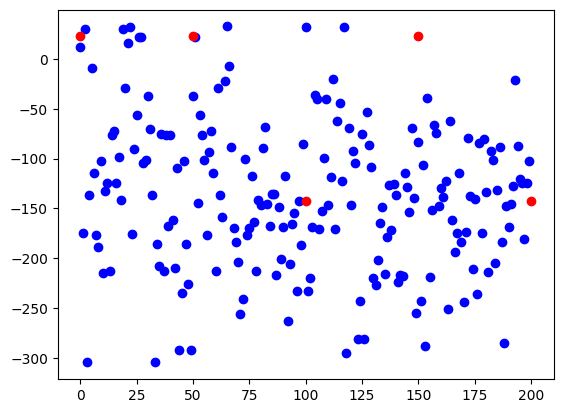

In [75]:
plt.plot(training_trace, 'bo')
eval_steps = np.arange(0,N_episodes+1,50)
plt.plot(eval_steps, eval_trace, 'ro')

In [66]:
""" Run the simulation """
log = []
finished = False
obs, info = env.reset(0)
while not finished:
    action = agent.act(obs, full_greedy=True)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
    

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

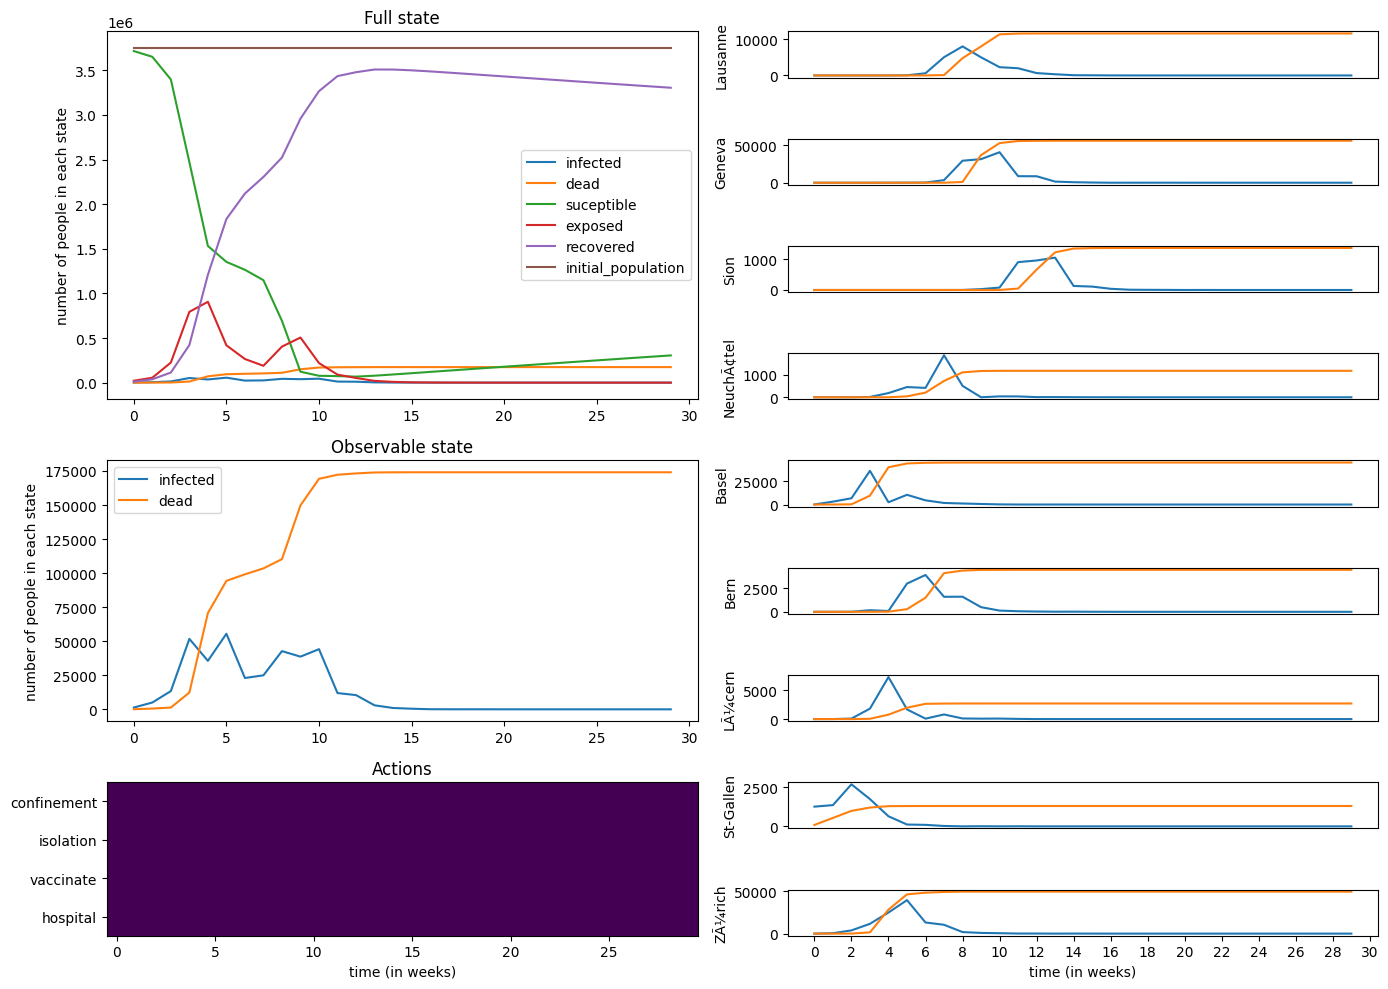

In [67]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()